In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import torch

#import custom modules
from choose_jurisdiction import *
from step_function import *
from PPO_baseline import *
from read_files import read_new_inf_input
from read_files import  M_x1_y1_value
from cost_benefit import calculate_initial_proportion_values

C:\Users\dsharma1\OneDrive - University of South Florida\My files\Paper health\HIV MARL 96 jur Sonza\IPPO_MARL_96-main\code_baseline\choose_jurisdiction.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_clus['Total MSM'] = total_msm


[ 19900000   2200000  13000000  23800000   8400000  20700000  24700000
  63800000  24100000  17300000  21100000  26300000  29400000  25400000
  25500000   7000000  46800000  16900000  33000000  23100000  27700000
  44300000  28400000  24600000  16900000  16500000  16500000  16500000
  48800000  16500000   3400000   8700000  21200000  49000000  15300000
  20200000  17500000   8900000  10900000   8000000  12700000  16300000
   1800000   8900000   8900000   8900000  11600000   9900000  20100000
  20200000  14400000  24800000   1400000  10500000   7500000  14900000
  26600000  27500000  14900000   4600000  32300000  26600000  26600000
 118700000  26600000  26000000  32700000    900000   6400000  11300000
  11300000   6400000   9400000  10800000  18600000  41500000   6500000
  24900000   2000000  21300000  23600000  23100000  29300000  44000000
  50200000  28600000  28700000   7200000   2200000  32000000  11300000
  18700000   7600000  17700000    800000]
Device set to : NVIDIA GeForce RTX 

In [2]:
# set device to cpu or cuda
device = torch.device('cpu')

#"""
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))

    gpu_t = torch.cuda.get_device_properties(0).total_memory 
    print("Total memory:", gpu_t/1024/1024/1024) #in GB #8GB
    
    gpu_r = torch.cuda.memory_reserved(0)
    print("Reserved memory:", gpu_r/1024/1024) #in MB #38MB

    gpu_a = torch.cuda.memory_allocated(0)
    print("Allocated memory:",gpu_a/1024/1024) #in MB #27.75MB
    
else:
    print("Device set to : cpu")
#"""
    
print("============================================================================================")

Device set to : NVIDIA GeForce RTX 3080 Laptop GPU
Total memory: 7.99951171875
Reserved memory: 0.0
Allocated memory: 0.0


In [3]:
################################### Training ###################################

#set num_jurisdictions
#instead use num_jur defined in choose_jurisdiction.ipynb

####### initialize environment hyperparameters ######

action_std_decay_rate = 0.0046
min_action_std = 0.05
action_std_decay_freq = 1000

has_continuous_action_space = True

max_ep_len = 12                   # max timesteps in one episode
max_training_timesteps = 12000 #12500 #50000 #100000   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 10     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = 2000      # save model frequency (in num timesteps)
plot_freq = 1200

action_std = 0.4

#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = 120     # update policy every n timesteps
K_epochs = 20               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma_ = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.0003       # learning rate for critic network

random_seed = 11   # set random seed if required (0 = no random seed)

#####################################################

env_name = 'HIV Jurisdiction'

print("training environment name : " + env_name)

# env = gym.make(env_name)

# state space dimension
obs_dim = 15
state_dim = 120

# action space dimension
if has_continuous_action_space:
    action_dim = 9
else:
    action_dim = 1
    
    
################### checkpointing ###################
 
run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder
 
directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)

############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("observation space dimension : ", obs_dim)
print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma_) : ", gamma_)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    #env.seed(random_seed) 
    np.random.seed(random_seed)

#####################################################


training environment name : HIV Jurisdiction
--------------------------------------------------------------------------------------------
max training timesteps :  12000
max timesteps per episode :  12
model saving frequency : 2000 timesteps
log frequency : 24 timesteps
printing average reward over episodes in last : 120 timesteps
--------------------------------------------------------------------------------------------
observation space dimension :  15
state space dimension :  120
action space dimension :  9
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting std of action distribution :  0.4
decay rate of std of action distribution :  0.0046
minimum std of action distribution :  0.05
decay frequency of std of action distribution : 1000 timesteps
---------------------------------------------------

In [4]:
print("Number of Jurisdictions being modeled:",num_jur)

#directory path code
# if no directory name provided use current date time
dir_name = "Exp_" + str(datetime.now()).split(".")[0].replace(" ", "_").replace(":","-")

#if using windows, save path
cwd = os.getcwd()
cwd = cwd + r"\results_baseline" 
save_path = os.path.join(cwd, dir_name)
#cwd = r'%s' % cwd
#os.mkdir(cwd)
os.makedirs(save_path)

print("============================================================================================")

Number of Jurisdictions being modeled: 95


In [5]:
################# training procedure ################

# initialize a PPO agent
ppo_agent = []
for i in range(num_jur):
    ppo_agent.append(PPO(obs_dim, state_dim, action_dim, lr_actor, lr_critic, gamma_, K_epochs, eps_clip, has_continuous_action_space, action_std))

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
"""
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')
"""

rew_list = [[] for x in range(num_jur)] 

# printing and logging variables
print_running_reward = np.zeros(num_jur) 

print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0

#calculate_initial_proportion_values(data_array_cluster)
# ESS_SOC_max = 1500
# T = 24
# training loop
while time_step <= max_training_timesteps:

    # INFO: This code block gets the initial data, states, prep values, and simulation time from the excel data file.
    # FUNCTION NAME: initial_state
    # FILE NAME: rate_prop_calculation_96.ipynb
    # NOTES: data_array_cluster and prep_values initialized in the called file; no hardcoding
    # NOTES: state is a tuple of 10 values -> 0 (inital data), 1-8 (states), 9 (prepvalues), 10(time)
    initial_data_ss, state, prep_values_ss, time_ss = initial_state(data_array_cluster,prep_values) 
    
    current_ep_reward = np.zeros(num_jur) 

    # INFO: this code block initializes the variables before the start of the t loop.
    data_in_t_loop = initial_data_ss
    #state                                  #already initialized above
    prep_values_in_t_loop = prep_values_ss
    time_in_t_loop = time_ss

    # INFO: This code reads excel file and assigns values related to new infections behavior
    # FUNCTION NAME: read_new_inf_input
    # FILE NAME: reading_files.ipynb
    new_infections_data = read_new_inf_input(age_begin, age_end, risk_groups)

    # INFO: This calculates something??? I think it reads transmission variables like num sex acts, condom efficacy, etc.
    # (Required to calculate new infections per month)
    # FUNCTION NAME: M_x1_y1_value
    # FILE NAME: reading_files.ipynb
    M_x1_y1_i = M_x1_y1_value(new_infections_data)

    # INFO: This code block gets the initial data, states, prep values, and simulation time from the excel data file.
    # FUNCTION NAME: new_infections_per_month
    # FILE NAME: rate_prop_calculation_96.ipynb
    #using a_prep:
    """
    #prep_rate = prep_values_ss + a_prep
    #new_inf_per_month_0 = new_infections_per_month(num_jur, initial_data_ss, new_infections_data, M_x1_y1_i, prep_rate)
    """
    #ignoring a_prep:
    new_inf_per_month_0 = new_infections_per_month(num_jur, initial_data_ss, new_infections_data, M_x1_y1_i, prep_values_ss)
    #print(np.sum(new_inf_per_month_0,axis=2))
    
    # INFO: This code reads excel file and assigns values related to death rate
    # FUNCTION NAME: read_death_rates
    # FILE NAME: reading_files.ipynb
    death_prob_data = read_death_rates(age_begin, age_end, risk_groups)

    # INFO: This code block stratifies death rate by risk, age and compartment
    # FUNCTION NAME: calculate_deaths_vector
    # FILE NAME: reading_files.ipynb
    death_rate_risk_age_compartments = np.zeros((num_jur, number_of_risk_groups, age_groups, number_of_compartments))

    for risk in range(len(risk_groups)):
        for age in range(age_groups):
            death_rate_risk_age_compartments[:,risk,age,] = calculate_deaths_vector(number_of_compartments, risk_groups, risk, age, death_prob_data).reshape(22)
    death_per_month_risk_age_compartments_0 = initial_data_ss * death_rate_risk_age_compartments * dt
    #print(death_per_month_risk_age_compartments_0)

    # INFO: This function call calculates the initial population, proportion unaware, proportion aware at time zero and diagnosis rate and time 1
    # FUNCTION NAME: calculate_initial_proportion_values
    # FILE NAME: cost_benefit_96.ipynb
    x_t_a_0 = calculate_initial_proportion_values(initial_data_ss, new_inf_per_month_0, death_per_month_risk_age_compartments_0, new_infections_data)
    #raise Exception("Stopping for debugging")
       
    # INFO: We run the following code for each timestep of the simulation.
    for t in range(0, max_ep_len+1):
        #print("t:",t)
        
        full_state = np.vstack(state).flatten() 
        #print(np.shape(full_state)) shape = 15 care cont states x num of jurisdictions

        # INFO: This line selects the action using the state of each jurisdiction from the policy
        # FUNCTION NAME: select_action
        # FILE NAME: PPO_algo_96.ipynb
        action = [ppo_agent[i].select_action(state[i].flatten()) for i in range(num_jur)]

        # INFO: This line calls the simulation step function, and returns the rewards for each jurisdiction
        # FUNCTION NAME: step
        # FILE NAME: step_function_96.ipynb
        data_in_t_loop, state, prep_values_in_t_loop, time_in_t_loop, reward, new_inf, penalty, done = step(data_in_t_loop, action, prep_values_in_t_loop, time_in_t_loop, x_t_a_0)
        #print("t:",t)
        

        # INFO: This loop calls saves the reward and is_terminals in the buffer
        for i in range(num_jur):
            ppo_agent[i].buffer.full_states.append(torch.FloatTensor(full_state).to(device))
            ppo_agent[i].buffer.rewards.append(reward[i])
            ppo_agent[i].buffer.is_terminals.append(done)
            current_ep_reward[i] += reward[i]
            ppo_agent[i].buffer.new_inf.append(new_inf[i])
            ppo_agent[i].buffer.penalty.append(penalty[i])

        
        time_step +=1
        #print("time_step:",time_step)
        #ltc_risk += ltc_increment

        if time_step % print_freq == 0:
            new_inf_list = []
            penalty_list = []
            for i in range(num_jur):
                new_inf_list.append(ppo_agent[i].buffer.new_inf)
                penalty_list.append(ppo_agent[i].buffer.penalty)
                #print("jurisdiction:",i)
                #print(np.array((ppo_agent[i].buffer.new_inf)).shape)
            np.savetxt("new_inf_baseline.csv", new_inf_list, delimiter=",")
            np.savetxt("penalty_baseline.csv", penalty_list, delimiter=",")
            #exit(0)
        
        # INFO: This code block updates the policy learned for each PPO agent
        # FUNCTION NAME: update
        # FILE NAME: PPO_algo_96.ipynb
        if time_step % update_timestep == 0:
            update_start = datetime.now()
            for i in range(num_jur):
                ppo_agent[i].update()
            print("Update Time Taken  : ", datetime.now() - update_start)

        # INFO: if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            for i in range(num_jur):
                ppo_agent[i].decay_action_std(action_std_decay_rate, min_action_std)

        # INFO: log in logging file - not really used? can remove??? check.
        """
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0
        """

        # INFO: printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = np.zeros(num_jur)
            for i in range(num_jur):
                print_avg_reward[i] = round((print_running_reward[i] / print_running_episodes),2)
                print("Agent{} => Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i+1, i_episode, time_step, print_avg_reward[i]))
                rew_list[i].append(print_avg_reward[i])

            print_running_reward = np.zeros(num_jur) #Sonza changes
            print_running_episodes = 0

            # INFO: save rewards as a csv file
            np.savetxt("avg_rew_baseline.csv", rew_list, delimiter=",")

        # INFO: Display and save result figures here    
        if time_step % plot_freq == 0:
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")

            x = 12 #2 #num_jur/4 #hardcoded
            y = 8 #hardcoded
            fig,ax = plt.subplots(x,y,sharex=False, sharey=False, figsize=(40,28)) #(20,14)
            fig.tight_layout(h_pad=3, w_pad=1)
            
            i = 0
            for j in range(x): #hardcoded
                for k in range(y): #hardcoded
                    if(i==num_jur):
                        break
                    ax[j][k].plot(range(len(rew_list[i])), rew_list[i])
                    #ax[j][k].set_ylim(-1e9,0.01)
                    ax[j][k].set_title("Rewards for Jurisdiction {}".format(all_jurisdictions[i]),pad=12)
                    i += 1

            # fig.suptitle('Rewards for all the agents')
            plt.savefig(os.path.join(save_path, str(time_step)))
            #plt.show()
            plt.close()
                        
        # INFO: save model weights - where is it being saved + how to load??? check.

        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model")

#            for i in range(num_jur):
#               ppo_agent[i].save(checkpoint_path[i])
                
            for i in range(num_jur):
                checkpoint_path = directory + 'Juri_{}' + "PPO_{}_{}_{}.pth".format(all_jurisdictions[i],env_name, random_seed, run_num_pretrained)
                ppo_agent[i].save(checkpoint_path)

            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")

            
        # break; if the episode is over
        #print("done?",done)
        if done:
            break
    #end of t loop
    #timestep currently = t + (12-1) ie (max ep len - 1)
      
    for i in range(num_jur):
        print_running_reward[i] += current_ep_reward[i]

    print_running_episodes += 1

    #log is only logging the first jurisdiction - do we need this??? check.
    log_running_reward += current_ep_reward[0] 
    log_running_episodes += 1

    i_episode += 1

# INFO: save rewards as a csv file
#np.savetxt("rew_baseline.csv", rew_list, delimiter=",")

#log_f.close()
# env.close()


C:\Users\dsharma1\Anaconda3\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Started training at (GMT) :  2025-09-15 14:03:04
Update Time Taken  :  0:00:09.006063
Agent1 => Episode : 9 		 Timestep : 120 		 Average Reward : -1827622581.15
Agent2 => Episode : 9 		 Timestep : 120 		 Average Reward : -381148119.97
Agent3 => Episode : 9 		 Timestep : 120 		 Average Reward : -1412547242.56
Agent4 => Episode : 9 		 Timestep : 120 		 Average Reward : -5614310108.05
Agent5 => Episode : 9 		 Timestep : 120 		 Average Reward : -1015050758.81
Agent6 => Episode : 9 		 Timestep : 120 		 Average Reward : -9380997304.8
Agent7 => Episode : 9 		 Timestep : 120 		 Average Reward : -1990848978.92
Agent8 => Episode : 9 		 Timestep : 120 		 Average Reward : -14484636061.46
Agent9 => Episode : 9 		 Timestep : 120 		 Average Reward : -5821122272.05
Agent10 => Episode : 9 		 Timestep : 120 		 Average Reward : -4154395032.09
Agent11 => Episode : 9 		 Timestep : 120 		 Average Reward : -1978774990.4
Agent12 => Episode : 9 		 Timestep : 120 		 Average Reward : -923953405.14
Agent13 => Epi

Update Time Taken  :  0:00:08.526003
Agent1 => Episode : 29 		 Timestep : 360 		 Average Reward : -1670773653.29
Agent2 => Episode : 29 		 Timestep : 360 		 Average Reward : -392367168.24
Agent3 => Episode : 29 		 Timestep : 360 		 Average Reward : -1384679217.05
Agent4 => Episode : 29 		 Timestep : 360 		 Average Reward : -5859717447.59
Agent5 => Episode : 29 		 Timestep : 360 		 Average Reward : -927189694.09
Agent6 => Episode : 29 		 Timestep : 360 		 Average Reward : -8919078945.0
Agent7 => Episode : 29 		 Timestep : 360 		 Average Reward : -1637564070.81
Agent8 => Episode : 29 		 Timestep : 360 		 Average Reward : -15632158212.49
Agent9 => Episode : 29 		 Timestep : 360 		 Average Reward : -5319169079.91
Agent10 => Episode : 29 		 Timestep : 360 		 Average Reward : -4095227111.56
Agent11 => Episode : 29 		 Timestep : 360 		 Average Reward : -1946972239.81
Agent12 => Episode : 29 		 Timestep : 360 		 Average Reward : -872799438.8
Agent13 => Episode : 29 		 Timestep : 360 		 Average

Update Time Taken  :  0:00:08.495667
Agent1 => Episode : 49 		 Timestep : 600 		 Average Reward : -1632233273.02
Agent2 => Episode : 49 		 Timestep : 600 		 Average Reward : -380703998.8
Agent3 => Episode : 49 		 Timestep : 600 		 Average Reward : -1251010823.38
Agent4 => Episode : 49 		 Timestep : 600 		 Average Reward : -5657640651.87
Agent5 => Episode : 49 		 Timestep : 600 		 Average Reward : -851861510.78
Agent6 => Episode : 49 		 Timestep : 600 		 Average Reward : -8893205781.95
Agent7 => Episode : 49 		 Timestep : 600 		 Average Reward : -1554765986.17
Agent8 => Episode : 49 		 Timestep : 600 		 Average Reward : -14285875797.99
Agent9 => Episode : 49 		 Timestep : 600 		 Average Reward : -5582328495.69
Agent10 => Episode : 49 		 Timestep : 600 		 Average Reward : -4188336770.26
Agent11 => Episode : 49 		 Timestep : 600 		 Average Reward : -1660876021.01
Agent12 => Episode : 49 		 Timestep : 600 		 Average Reward : -797189524.42
Agent13 => Episode : 49 		 Timestep : 600 		 Averag

Update Time Taken  :  0:00:08.767769
Agent1 => Episode : 69 		 Timestep : 840 		 Average Reward : -1361810131.8
Agent2 => Episode : 69 		 Timestep : 840 		 Average Reward : -373402519.96
Agent3 => Episode : 69 		 Timestep : 840 		 Average Reward : -1218848462.35
Agent4 => Episode : 69 		 Timestep : 840 		 Average Reward : -4772963185.34
Agent5 => Episode : 69 		 Timestep : 840 		 Average Reward : -839529691.12
Agent6 => Episode : 69 		 Timestep : 840 		 Average Reward : -8854804150.73
Agent7 => Episode : 69 		 Timestep : 840 		 Average Reward : -1411766138.22
Agent8 => Episode : 69 		 Timestep : 840 		 Average Reward : -12328363713.08
Agent9 => Episode : 69 		 Timestep : 840 		 Average Reward : -5083481304.0
Agent10 => Episode : 69 		 Timestep : 840 		 Average Reward : -4055214141.07
Agent11 => Episode : 69 		 Timestep : 840 		 Average Reward : -1638740769.62
Agent12 => Episode : 69 		 Timestep : 840 		 Average Reward : -603811864.47
Agent13 => Episode : 69 		 Timestep : 840 		 Average

Update Time Taken  :  0:00:08.632801
Agent1 => Episode : 89 		 Timestep : 1080 		 Average Reward : -1201879504.4
Agent2 => Episode : 89 		 Timestep : 1080 		 Average Reward : -382082272.07
Agent3 => Episode : 89 		 Timestep : 1080 		 Average Reward : -1144121050.53
Agent4 => Episode : 89 		 Timestep : 1080 		 Average Reward : -5040482683.44
Agent5 => Episode : 89 		 Timestep : 1080 		 Average Reward : -744229109.99
Agent6 => Episode : 89 		 Timestep : 1080 		 Average Reward : -8854514461.02
Agent7 => Episode : 89 		 Timestep : 1080 		 Average Reward : -1192916239.0
Agent8 => Episode : 89 		 Timestep : 1080 		 Average Reward : -11835010443.57
Agent9 => Episode : 89 		 Timestep : 1080 		 Average Reward : -5403921678.61
Agent10 => Episode : 89 		 Timestep : 1080 		 Average Reward : -4124094880.66
Agent11 => Episode : 89 		 Timestep : 1080 		 Average Reward : -1516562319.68
Agent12 => Episode : 89 		 Timestep : 1080 		 Average Reward : -654468802.05
Agent13 => Episode : 89 		 Timestep : 10

Update Time Taken  :  0:00:08.613895
Agent1 => Episode : 109 		 Timestep : 1320 		 Average Reward : -984185220.57
Agent2 => Episode : 109 		 Timestep : 1320 		 Average Reward : -358684608.84
Agent3 => Episode : 109 		 Timestep : 1320 		 Average Reward : -1130763949.94
Agent4 => Episode : 109 		 Timestep : 1320 		 Average Reward : -4812266163.79
Agent5 => Episode : 109 		 Timestep : 1320 		 Average Reward : -735886860.36
Agent6 => Episode : 109 		 Timestep : 1320 		 Average Reward : -7591694070.48
Agent7 => Episode : 109 		 Timestep : 1320 		 Average Reward : -986110079.5
Agent8 => Episode : 109 		 Timestep : 1320 		 Average Reward : -11340820450.64
Agent9 => Episode : 109 		 Timestep : 1320 		 Average Reward : -4853690237.03
Agent10 => Episode : 109 		 Timestep : 1320 		 Average Reward : -3694068089.99
Agent11 => Episode : 109 		 Timestep : 1320 		 Average Reward : -1330412680.36
Agent12 => Episode : 109 		 Timestep : 1320 		 Average Reward : -415758318.84
Agent13 => Episode : 109 		 T

Update Time Taken  :  0:00:08.484616
Agent1 => Episode : 129 		 Timestep : 1560 		 Average Reward : -912340751.44
Agent2 => Episode : 129 		 Timestep : 1560 		 Average Reward : -353475320.41
Agent3 => Episode : 129 		 Timestep : 1560 		 Average Reward : -993317076.69
Agent4 => Episode : 129 		 Timestep : 1560 		 Average Reward : -4027497660.52
Agent5 => Episode : 129 		 Timestep : 1560 		 Average Reward : -677780156.9
Agent6 => Episode : 129 		 Timestep : 1560 		 Average Reward : -7670328569.59
Agent7 => Episode : 129 		 Timestep : 1560 		 Average Reward : -572078871.25
Agent8 => Episode : 129 		 Timestep : 1560 		 Average Reward : -9360369594.81
Agent9 => Episode : 129 		 Timestep : 1560 		 Average Reward : -4921886953.77
Agent10 => Episode : 129 		 Timestep : 1560 		 Average Reward : -3333776394.72
Agent11 => Episode : 129 		 Timestep : 1560 		 Average Reward : -1182116969.19
Agent12 => Episode : 129 		 Timestep : 1560 		 Average Reward : -353762275.62
Agent13 => Episode : 129 		 Tim

Update Time Taken  :  0:00:08.468429
Agent1 => Episode : 149 		 Timestep : 1800 		 Average Reward : -743706764.98
Agent2 => Episode : 149 		 Timestep : 1800 		 Average Reward : -317830982.36
Agent3 => Episode : 149 		 Timestep : 1800 		 Average Reward : -943284718.22
Agent4 => Episode : 149 		 Timestep : 1800 		 Average Reward : -3420179694.23
Agent5 => Episode : 149 		 Timestep : 1800 		 Average Reward : -570955978.1
Agent6 => Episode : 149 		 Timestep : 1800 		 Average Reward : -7521935911.64
Agent7 => Episode : 149 		 Timestep : 1800 		 Average Reward : -480251535.65
Agent8 => Episode : 149 		 Timestep : 1800 		 Average Reward : -8801172371.88
Agent9 => Episode : 149 		 Timestep : 1800 		 Average Reward : -4664183113.61
Agent10 => Episode : 149 		 Timestep : 1800 		 Average Reward : -2925742336.32
Agent11 => Episode : 149 		 Timestep : 1800 		 Average Reward : -967124856.83
Agent12 => Episode : 149 		 Timestep : 1800 		 Average Reward : -179577888.14
Agent13 => Episode : 149 		 Time

--------------------------------------------------------------------------------------------
saving model
model saved
Elapsed Time  :  0:51:28
--------------------------------------------------------------------------------------------
Update Time Taken  :  0:00:08.453316
Agent1 => Episode : 169 		 Timestep : 2040 		 Average Reward : -656792480.63
Agent2 => Episode : 169 		 Timestep : 2040 		 Average Reward : -283449758.03
Agent3 => Episode : 169 		 Timestep : 2040 		 Average Reward : -834001024.75
Agent4 => Episode : 169 		 Timestep : 2040 		 Average Reward : -3227687602.98
Agent5 => Episode : 169 		 Timestep : 2040 		 Average Reward : -520385457.73
Agent6 => Episode : 169 		 Timestep : 2040 		 Average Reward : -6815335633.65
Agent7 => Episode : 169 		 Timestep : 2040 		 Average Reward : -414302047.69
Agent8 => Episode : 169 		 Timestep : 2040 		 Average Reward : -7957450003.91
Agent9 => Episode : 169 		 Timestep : 2040 		 Average Reward : -4477376782.59
Agent10 => Episode : 169 		 Ti

Update Time Taken  :  0:00:08.418739
Agent1 => Episode : 189 		 Timestep : 2280 		 Average Reward : -675166417.34
Agent2 => Episode : 189 		 Timestep : 2280 		 Average Reward : -263927652.14
Agent3 => Episode : 189 		 Timestep : 2280 		 Average Reward : -732346050.25
Agent4 => Episode : 189 		 Timestep : 2280 		 Average Reward : -2925969040.8
Agent5 => Episode : 189 		 Timestep : 2280 		 Average Reward : -386393107.65
Agent6 => Episode : 189 		 Timestep : 2280 		 Average Reward : -5696657149.16
Agent7 => Episode : 189 		 Timestep : 2280 		 Average Reward : -389137716.39
Agent8 => Episode : 189 		 Timestep : 2280 		 Average Reward : -8222403329.08
Agent9 => Episode : 189 		 Timestep : 2280 		 Average Reward : -4052930896.56
Agent10 => Episode : 189 		 Timestep : 2280 		 Average Reward : -2330863949.38
Agent11 => Episode : 189 		 Timestep : 2280 		 Average Reward : -613987002.94
Agent12 => Episode : 189 		 Timestep : 2280 		 Average Reward : -140211939.93
Agent13 => Episode : 189 		 Time

Update Time Taken  :  0:00:08.559135
Agent1 => Episode : 209 		 Timestep : 2520 		 Average Reward : -638911160.86
Agent2 => Episode : 209 		 Timestep : 2520 		 Average Reward : -269979565.92
Agent3 => Episode : 209 		 Timestep : 2520 		 Average Reward : -686334106.0
Agent4 => Episode : 209 		 Timestep : 2520 		 Average Reward : -2729349683.78
Agent5 => Episode : 209 		 Timestep : 2520 		 Average Reward : -408412062.15
Agent6 => Episode : 209 		 Timestep : 2520 		 Average Reward : -5627732710.67
Agent7 => Episode : 209 		 Timestep : 2520 		 Average Reward : -272787277.54
Agent8 => Episode : 209 		 Timestep : 2520 		 Average Reward : -7059184782.43
Agent9 => Episode : 209 		 Timestep : 2520 		 Average Reward : -4081599261.85
Agent10 => Episode : 209 		 Timestep : 2520 		 Average Reward : -2174379918.49
Agent11 => Episode : 209 		 Timestep : 2520 		 Average Reward : -422472348.3
Agent12 => Episode : 209 		 Timestep : 2520 		 Average Reward : -101177417.33
Agent13 => Episode : 209 		 Times

Update Time Taken  :  0:00:08.618108
Agent1 => Episode : 229 		 Timestep : 2760 		 Average Reward : -658985642.26
Agent2 => Episode : 229 		 Timestep : 2760 		 Average Reward : -245204568.02
Agent3 => Episode : 229 		 Timestep : 2760 		 Average Reward : -676084589.54
Agent4 => Episode : 229 		 Timestep : 2760 		 Average Reward : -2533424019.54
Agent5 => Episode : 229 		 Timestep : 2760 		 Average Reward : -370564994.13
Agent6 => Episode : 229 		 Timestep : 2760 		 Average Reward : -5072554706.65
Agent7 => Episode : 229 		 Timestep : 2760 		 Average Reward : -419568085.77
Agent8 => Episode : 229 		 Timestep : 2760 		 Average Reward : -6881292469.22
Agent9 => Episode : 229 		 Timestep : 2760 		 Average Reward : -3828328401.94
Agent10 => Episode : 229 		 Timestep : 2760 		 Average Reward : -2067314553.77
Agent11 => Episode : 229 		 Timestep : 2760 		 Average Reward : -307771138.06
Agent12 => Episode : 229 		 Timestep : 2760 		 Average Reward : -173620194.24
Agent13 => Episode : 229 		 Tim

Update Time Taken  :  0:00:08.554262
Agent1 => Episode : 249 		 Timestep : 3000 		 Average Reward : -613609461.16
Agent2 => Episode : 249 		 Timestep : 3000 		 Average Reward : -230280683.98
Agent3 => Episode : 249 		 Timestep : 3000 		 Average Reward : -620478602.12
Agent4 => Episode : 249 		 Timestep : 3000 		 Average Reward : -2394738112.95
Agent5 => Episode : 249 		 Timestep : 3000 		 Average Reward : -328760877.8
Agent6 => Episode : 249 		 Timestep : 3000 		 Average Reward : -4935612830.8
Agent7 => Episode : 249 		 Timestep : 3000 		 Average Reward : -347104633.58
Agent8 => Episode : 249 		 Timestep : 3000 		 Average Reward : -6423632630.27
Agent9 => Episode : 249 		 Timestep : 3000 		 Average Reward : -3686620315.27
Agent10 => Episode : 249 		 Timestep : 3000 		 Average Reward : -1807038027.08
Agent11 => Episode : 249 		 Timestep : 3000 		 Average Reward : -218877080.93
Agent12 => Episode : 249 		 Timestep : 3000 		 Average Reward : -149850577.82
Agent13 => Episode : 249 		 Times

Update Time Taken  :  0:00:08.661036
Agent1 => Episode : 269 		 Timestep : 3240 		 Average Reward : -575731431.72
Agent2 => Episode : 269 		 Timestep : 3240 		 Average Reward : -212126237.56
Agent3 => Episode : 269 		 Timestep : 3240 		 Average Reward : -591657388.04
Agent4 => Episode : 269 		 Timestep : 3240 		 Average Reward : -2403738536.77
Agent5 => Episode : 269 		 Timestep : 3240 		 Average Reward : -312804244.14
Agent6 => Episode : 269 		 Timestep : 3240 		 Average Reward : -4588477482.36
Agent7 => Episode : 269 		 Timestep : 3240 		 Average Reward : -357692692.96
Agent8 => Episode : 269 		 Timestep : 3240 		 Average Reward : -6617890065.66
Agent9 => Episode : 269 		 Timestep : 3240 		 Average Reward : -3570707936.53
Agent10 => Episode : 269 		 Timestep : 3240 		 Average Reward : -1899392200.96
Agent11 => Episode : 269 		 Timestep : 3240 		 Average Reward : -251827932.24
Agent12 => Episode : 269 		 Timestep : 3240 		 Average Reward : -148319696.62
Agent13 => Episode : 269 		 Tim

Update Time Taken  :  0:00:08.519808
Agent1 => Episode : 289 		 Timestep : 3480 		 Average Reward : -664560517.6
Agent2 => Episode : 289 		 Timestep : 3480 		 Average Reward : -214312297.28
Agent3 => Episode : 289 		 Timestep : 3480 		 Average Reward : -650965388.41
Agent4 => Episode : 289 		 Timestep : 3480 		 Average Reward : -2364876983.34
Agent5 => Episode : 289 		 Timestep : 3480 		 Average Reward : -377230377.27
Agent6 => Episode : 289 		 Timestep : 3480 		 Average Reward : -4126686853.72
Agent7 => Episode : 289 		 Timestep : 3480 		 Average Reward : -337075399.53
Agent8 => Episode : 289 		 Timestep : 3480 		 Average Reward : -6080917580.88
Agent9 => Episode : 289 		 Timestep : 3480 		 Average Reward : -3622481750.24
Agent10 => Episode : 289 		 Timestep : 3480 		 Average Reward : -1631992629.73
Agent11 => Episode : 289 		 Timestep : 3480 		 Average Reward : -237003379.73
Agent12 => Episode : 289 		 Timestep : 3480 		 Average Reward : -133921071.67
Agent13 => Episode : 289 		 Time

Update Time Taken  :  0:00:08.659402
Agent1 => Episode : 309 		 Timestep : 3720 		 Average Reward : -573704111.58
Agent2 => Episode : 309 		 Timestep : 3720 		 Average Reward : -200757871.27
Agent3 => Episode : 309 		 Timestep : 3720 		 Average Reward : -623757425.99
Agent4 => Episode : 309 		 Timestep : 3720 		 Average Reward : -2327307721.88
Agent5 => Episode : 309 		 Timestep : 3720 		 Average Reward : -356402159.11
Agent6 => Episode : 309 		 Timestep : 3720 		 Average Reward : -3764108533.78
Agent7 => Episode : 309 		 Timestep : 3720 		 Average Reward : -296673902.58
Agent8 => Episode : 309 		 Timestep : 3720 		 Average Reward : -6846588443.48
Agent9 => Episode : 309 		 Timestep : 3720 		 Average Reward : -3664253296.3
Agent10 => Episode : 309 		 Timestep : 3720 		 Average Reward : -1866427540.84
Agent11 => Episode : 309 		 Timestep : 3720 		 Average Reward : -188347860.31
Agent12 => Episode : 309 		 Timestep : 3720 		 Average Reward : -94039535.07
Agent13 => Episode : 309 		 Times

Update Time Taken  :  0:00:08.470116
Agent1 => Episode : 329 		 Timestep : 3960 		 Average Reward : -588878156.22
Agent2 => Episode : 329 		 Timestep : 3960 		 Average Reward : -198604223.33
Agent3 => Episode : 329 		 Timestep : 3960 		 Average Reward : -575869192.14
Agent4 => Episode : 329 		 Timestep : 3960 		 Average Reward : -2265903962.64
Agent5 => Episode : 329 		 Timestep : 3960 		 Average Reward : -357772112.73
Agent6 => Episode : 329 		 Timestep : 3960 		 Average Reward : -3624945430.35
Agent7 => Episode : 329 		 Timestep : 3960 		 Average Reward : -410965391.75
Agent8 => Episode : 329 		 Timestep : 3960 		 Average Reward : -6173997115.85
Agent9 => Episode : 329 		 Timestep : 3960 		 Average Reward : -3586378895.22
Agent10 => Episode : 329 		 Timestep : 3960 		 Average Reward : -1665205424.9
Agent11 => Episode : 329 		 Timestep : 3960 		 Average Reward : -254134271.8
Agent12 => Episode : 329 		 Timestep : 3960 		 Average Reward : -77968504.13
Agent13 => Episode : 329 		 Timest

Update Time Taken  :  0:00:08.501673
Agent1 => Episode : 349 		 Timestep : 4200 		 Average Reward : -547396512.82
Agent2 => Episode : 349 		 Timestep : 4200 		 Average Reward : -195879397.87
Agent3 => Episode : 349 		 Timestep : 4200 		 Average Reward : -588715889.63
Agent4 => Episode : 349 		 Timestep : 4200 		 Average Reward : -2128552150.58
Agent5 => Episode : 349 		 Timestep : 4200 		 Average Reward : -320788503.98
Agent6 => Episode : 349 		 Timestep : 4200 		 Average Reward : -3767375358.15
Agent7 => Episode : 349 		 Timestep : 4200 		 Average Reward : -331588124.05
Agent8 => Episode : 349 		 Timestep : 4200 		 Average Reward : -6011301696.15
Agent9 => Episode : 349 		 Timestep : 4200 		 Average Reward : -3556511330.04
Agent10 => Episode : 349 		 Timestep : 4200 		 Average Reward : -1725652012.6
Agent11 => Episode : 349 		 Timestep : 4200 		 Average Reward : -180345359.33
Agent12 => Episode : 349 		 Timestep : 4200 		 Average Reward : -121747362.44
Agent13 => Episode : 349 		 Time

Update Time Taken  :  0:00:08.794249
Agent1 => Episode : 369 		 Timestep : 4440 		 Average Reward : -588966950.3
Agent2 => Episode : 369 		 Timestep : 4440 		 Average Reward : -199721869.86
Agent3 => Episode : 369 		 Timestep : 4440 		 Average Reward : -606670080.5
Agent4 => Episode : 369 		 Timestep : 4440 		 Average Reward : -2392427524.13
Agent5 => Episode : 369 		 Timestep : 4440 		 Average Reward : -329641370.25
Agent6 => Episode : 369 		 Timestep : 4440 		 Average Reward : -3344308941.61
Agent7 => Episode : 369 		 Timestep : 4440 		 Average Reward : -269570054.79
Agent8 => Episode : 369 		 Timestep : 4440 		 Average Reward : -6217506527.42
Agent9 => Episode : 369 		 Timestep : 4440 		 Average Reward : -3502028439.46
Agent10 => Episode : 369 		 Timestep : 4440 		 Average Reward : -1886052571.37
Agent11 => Episode : 369 		 Timestep : 4440 		 Average Reward : -133284152.49
Agent12 => Episode : 369 		 Timestep : 4440 		 Average Reward : -150311153.02
Agent13 => Episode : 369 		 Times

Update Time Taken  :  0:00:08.869564
Agent1 => Episode : 389 		 Timestep : 4680 		 Average Reward : -556422105.2
Agent2 => Episode : 389 		 Timestep : 4680 		 Average Reward : -202577026.64
Agent3 => Episode : 389 		 Timestep : 4680 		 Average Reward : -615643256.89
Agent4 => Episode : 389 		 Timestep : 4680 		 Average Reward : -2320630298.42
Agent5 => Episode : 389 		 Timestep : 4680 		 Average Reward : -310158930.13
Agent6 => Episode : 389 		 Timestep : 4680 		 Average Reward : -3241967690.59
Agent7 => Episode : 389 		 Timestep : 4680 		 Average Reward : -339220967.21
Agent8 => Episode : 389 		 Timestep : 4680 		 Average Reward : -6161104253.8
Agent9 => Episode : 389 		 Timestep : 4680 		 Average Reward : -3435663254.55
Agent10 => Episode : 389 		 Timestep : 4680 		 Average Reward : -1665684344.46
Agent11 => Episode : 389 		 Timestep : 4680 		 Average Reward : -174346434.19
Agent12 => Episode : 389 		 Timestep : 4680 		 Average Reward : -83364239.52
Agent13 => Episode : 389 		 Timest

Update Time Taken  :  0:00:08.431140
Agent1 => Episode : 409 		 Timestep : 4920 		 Average Reward : -543701229.71
Agent2 => Episode : 409 		 Timestep : 4920 		 Average Reward : -209331596.1
Agent3 => Episode : 409 		 Timestep : 4920 		 Average Reward : -580069960.01
Agent4 => Episode : 409 		 Timestep : 4920 		 Average Reward : -2418693441.63
Agent5 => Episode : 409 		 Timestep : 4920 		 Average Reward : -301937273.31
Agent6 => Episode : 409 		 Timestep : 4920 		 Average Reward : -3427524676.71
Agent7 => Episode : 409 		 Timestep : 4920 		 Average Reward : -293834364.02
Agent8 => Episode : 409 		 Timestep : 4920 		 Average Reward : -6474483131.36
Agent9 => Episode : 409 		 Timestep : 4920 		 Average Reward : -3534902918.38
Agent10 => Episode : 409 		 Timestep : 4920 		 Average Reward : -1485196299.75
Agent11 => Episode : 409 		 Timestep : 4920 		 Average Reward : -193238320.53
Agent12 => Episode : 409 		 Timestep : 4920 		 Average Reward : -125304171.1
Agent13 => Episode : 409 		 Times

Update Time Taken  :  0:00:08.416822
Agent1 => Episode : 429 		 Timestep : 5160 		 Average Reward : -567435290.78
Agent2 => Episode : 429 		 Timestep : 5160 		 Average Reward : -194136051.22
Agent3 => Episode : 429 		 Timestep : 5160 		 Average Reward : -594142463.24
Agent4 => Episode : 429 		 Timestep : 5160 		 Average Reward : -2360970023.05
Agent5 => Episode : 429 		 Timestep : 5160 		 Average Reward : -323533814.97
Agent6 => Episode : 429 		 Timestep : 5160 		 Average Reward : -3170700543.03
Agent7 => Episode : 429 		 Timestep : 5160 		 Average Reward : -276778395.98
Agent8 => Episode : 429 		 Timestep : 5160 		 Average Reward : -6385000611.31
Agent9 => Episode : 429 		 Timestep : 5160 		 Average Reward : -3582613201.31
Agent10 => Episode : 429 		 Timestep : 5160 		 Average Reward : -1638404889.13
Agent11 => Episode : 429 		 Timestep : 5160 		 Average Reward : -231355178.71
Agent12 => Episode : 429 		 Timestep : 5160 		 Average Reward : -128504813.66
Agent13 => Episode : 429 		 Tim

Update Time Taken  :  0:00:08.248340
Agent1 => Episode : 449 		 Timestep : 5400 		 Average Reward : -582159994.14
Agent2 => Episode : 449 		 Timestep : 5400 		 Average Reward : -200784973.38
Agent3 => Episode : 449 		 Timestep : 5400 		 Average Reward : -587588365.71
Agent4 => Episode : 449 		 Timestep : 5400 		 Average Reward : -2081032325.23
Agent5 => Episode : 449 		 Timestep : 5400 		 Average Reward : -327559211.64
Agent6 => Episode : 449 		 Timestep : 5400 		 Average Reward : -3480991677.57
Agent7 => Episode : 449 		 Timestep : 5400 		 Average Reward : -290281199.93
Agent8 => Episode : 449 		 Timestep : 5400 		 Average Reward : -6543182303.25
Agent9 => Episode : 449 		 Timestep : 5400 		 Average Reward : -3484194519.83
Agent10 => Episode : 449 		 Timestep : 5400 		 Average Reward : -1727944015.06
Agent11 => Episode : 449 		 Timestep : 5400 		 Average Reward : -256881153.09
Agent12 => Episode : 449 		 Timestep : 5400 		 Average Reward : -135802332.58
Agent13 => Episode : 449 		 Tim

Update Time Taken  :  0:00:08.402298
Agent1 => Episode : 469 		 Timestep : 5640 		 Average Reward : -550717712.16
Agent2 => Episode : 469 		 Timestep : 5640 		 Average Reward : -196535129.44
Agent3 => Episode : 469 		 Timestep : 5640 		 Average Reward : -589017249.55
Agent4 => Episode : 469 		 Timestep : 5640 		 Average Reward : -2229478934.56
Agent5 => Episode : 469 		 Timestep : 5640 		 Average Reward : -358128081.36
Agent6 => Episode : 469 		 Timestep : 5640 		 Average Reward : -3230742552.18
Agent7 => Episode : 469 		 Timestep : 5640 		 Average Reward : -208573295.21
Agent8 => Episode : 469 		 Timestep : 5640 		 Average Reward : -6247918838.68
Agent9 => Episode : 469 		 Timestep : 5640 		 Average Reward : -3469065811.85
Agent10 => Episode : 469 		 Timestep : 5640 		 Average Reward : -1654408453.39
Agent11 => Episode : 469 		 Timestep : 5640 		 Average Reward : -269366642.96
Agent12 => Episode : 469 		 Timestep : 5640 		 Average Reward : -88679185.3
Agent13 => Episode : 469 		 Times

Update Time Taken  :  0:00:08.544691
Agent1 => Episode : 489 		 Timestep : 5880 		 Average Reward : -633292309.14
Agent2 => Episode : 489 		 Timestep : 5880 		 Average Reward : -193833195.47
Agent3 => Episode : 489 		 Timestep : 5880 		 Average Reward : -550120381.26
Agent4 => Episode : 489 		 Timestep : 5880 		 Average Reward : -2360444634.1
Agent5 => Episode : 489 		 Timestep : 5880 		 Average Reward : -345530658.1
Agent6 => Episode : 489 		 Timestep : 5880 		 Average Reward : -3346155141.66
Agent7 => Episode : 489 		 Timestep : 5880 		 Average Reward : -221024978.9
Agent8 => Episode : 489 		 Timestep : 5880 		 Average Reward : -6321085829.98
Agent9 => Episode : 489 		 Timestep : 5880 		 Average Reward : -3532089042.75
Agent10 => Episode : 489 		 Timestep : 5880 		 Average Reward : -1681265510.5
Agent11 => Episode : 489 		 Timestep : 5880 		 Average Reward : -179854129.54
Agent12 => Episode : 489 		 Timestep : 5880 		 Average Reward : -144434532.9
Agent13 => Episode : 489 		 Timestep

--------------------------------------------------------------------------------------------
saving model
model saved
Elapsed Time  :  2:34:27
--------------------------------------------------------------------------------------------
Update Time Taken  :  0:00:08.446737
Agent1 => Episode : 509 		 Timestep : 6120 		 Average Reward : -589720569.28
Agent2 => Episode : 509 		 Timestep : 6120 		 Average Reward : -187914176.24
Agent3 => Episode : 509 		 Timestep : 6120 		 Average Reward : -588428960.43
Agent4 => Episode : 509 		 Timestep : 6120 		 Average Reward : -2360723172.64
Agent5 => Episode : 509 		 Timestep : 6120 		 Average Reward : -332521043.15
Agent6 => Episode : 509 		 Timestep : 6120 		 Average Reward : -3275898108.79
Agent7 => Episode : 509 		 Timestep : 6120 		 Average Reward : -229079106.94
Agent8 => Episode : 509 		 Timestep : 6120 		 Average Reward : -6401819703.93
Agent9 => Episode : 509 		 Timestep : 6120 		 Average Reward : -3398042936.89
Agent10 => Episode : 509 		 Ti

Update Time Taken  :  0:00:08.478264
Agent1 => Episode : 529 		 Timestep : 6360 		 Average Reward : -540396990.1
Agent2 => Episode : 529 		 Timestep : 6360 		 Average Reward : -198712149.56
Agent3 => Episode : 529 		 Timestep : 6360 		 Average Reward : -533425903.38
Agent4 => Episode : 529 		 Timestep : 6360 		 Average Reward : -2196953419.45
Agent5 => Episode : 529 		 Timestep : 6360 		 Average Reward : -347607098.37
Agent6 => Episode : 529 		 Timestep : 6360 		 Average Reward : -3649825496.61
Agent7 => Episode : 529 		 Timestep : 6360 		 Average Reward : -234822894.38
Agent8 => Episode : 529 		 Timestep : 6360 		 Average Reward : -6256647502.18
Agent9 => Episode : 529 		 Timestep : 6360 		 Average Reward : -3503209865.01
Agent10 => Episode : 529 		 Timestep : 6360 		 Average Reward : -1655501536.54
Agent11 => Episode : 529 		 Timestep : 6360 		 Average Reward : -216144664.16
Agent12 => Episode : 529 		 Timestep : 6360 		 Average Reward : -123915228.05
Agent13 => Episode : 529 		 Time

Update Time Taken  :  0:00:08.272489
Agent1 => Episode : 549 		 Timestep : 6600 		 Average Reward : -611066117.91
Agent2 => Episode : 549 		 Timestep : 6600 		 Average Reward : -194262623.41
Agent3 => Episode : 549 		 Timestep : 6600 		 Average Reward : -588321022.51
Agent4 => Episode : 549 		 Timestep : 6600 		 Average Reward : -2323341945.19
Agent5 => Episode : 549 		 Timestep : 6600 		 Average Reward : -310246935.52
Agent6 => Episode : 549 		 Timestep : 6600 		 Average Reward : -3571571659.98
Agent7 => Episode : 549 		 Timestep : 6600 		 Average Reward : -312998565.84
Agent8 => Episode : 549 		 Timestep : 6600 		 Average Reward : -6255806014.09
Agent9 => Episode : 549 		 Timestep : 6600 		 Average Reward : -3410627139.52
Agent10 => Episode : 549 		 Timestep : 6600 		 Average Reward : -1733084485.95
Agent11 => Episode : 549 		 Timestep : 6600 		 Average Reward : -238101363.94
Agent12 => Episode : 549 		 Timestep : 6600 		 Average Reward : -122283164.57
Agent13 => Episode : 549 		 Tim

Update Time Taken  :  0:00:08.391600
Agent1 => Episode : 569 		 Timestep : 6840 		 Average Reward : -568275970.02
Agent2 => Episode : 569 		 Timestep : 6840 		 Average Reward : -189244293.54
Agent3 => Episode : 569 		 Timestep : 6840 		 Average Reward : -549356573.48
Agent4 => Episode : 569 		 Timestep : 6840 		 Average Reward : -2079961071.06
Agent5 => Episode : 569 		 Timestep : 6840 		 Average Reward : -313717293.39
Agent6 => Episode : 569 		 Timestep : 6840 		 Average Reward : -3205471201.04
Agent7 => Episode : 569 		 Timestep : 6840 		 Average Reward : -272586398.17
Agent8 => Episode : 569 		 Timestep : 6840 		 Average Reward : -6264952838.07
Agent9 => Episode : 569 		 Timestep : 6840 		 Average Reward : -3457252610.44
Agent10 => Episode : 569 		 Timestep : 6840 		 Average Reward : -1760431077.62
Agent11 => Episode : 569 		 Timestep : 6840 		 Average Reward : -227346755.38
Agent12 => Episode : 569 		 Timestep : 6840 		 Average Reward : -124806132.58
Agent13 => Episode : 569 		 Tim

Update Time Taken  :  0:00:08.362570
Agent1 => Episode : 589 		 Timestep : 7080 		 Average Reward : -569177311.29
Agent2 => Episode : 589 		 Timestep : 7080 		 Average Reward : -192835369.64
Agent3 => Episode : 589 		 Timestep : 7080 		 Average Reward : -554854898.12
Agent4 => Episode : 589 		 Timestep : 7080 		 Average Reward : -2105554398.08
Agent5 => Episode : 589 		 Timestep : 7080 		 Average Reward : -302170315.23
Agent6 => Episode : 589 		 Timestep : 7080 		 Average Reward : -3436516964.73
Agent7 => Episode : 589 		 Timestep : 7080 		 Average Reward : -253952573.26
Agent8 => Episode : 589 		 Timestep : 7080 		 Average Reward : -6281945988.07
Agent9 => Episode : 589 		 Timestep : 7080 		 Average Reward : -3481102193.23
Agent10 => Episode : 589 		 Timestep : 7080 		 Average Reward : -1609118741.07
Agent11 => Episode : 589 		 Timestep : 7080 		 Average Reward : -224393498.41
Agent12 => Episode : 589 		 Timestep : 7080 		 Average Reward : -125114138.13
Agent13 => Episode : 589 		 Tim

Update Time Taken  :  0:00:08.318601
Agent1 => Episode : 609 		 Timestep : 7320 		 Average Reward : -589365928.7
Agent2 => Episode : 609 		 Timestep : 7320 		 Average Reward : -183889977.95
Agent3 => Episode : 609 		 Timestep : 7320 		 Average Reward : -608403790.46
Agent4 => Episode : 609 		 Timestep : 7320 		 Average Reward : -2272346167.74
Agent5 => Episode : 609 		 Timestep : 7320 		 Average Reward : -334657748.69
Agent6 => Episode : 609 		 Timestep : 7320 		 Average Reward : -3293957393.24
Agent7 => Episode : 609 		 Timestep : 7320 		 Average Reward : -236318555.39
Agent8 => Episode : 609 		 Timestep : 7320 		 Average Reward : -6501961666.34
Agent9 => Episode : 609 		 Timestep : 7320 		 Average Reward : -3476057360.83
Agent10 => Episode : 609 		 Timestep : 7320 		 Average Reward : -1672720030.97
Agent11 => Episode : 609 		 Timestep : 7320 		 Average Reward : -199180638.59
Agent12 => Episode : 609 		 Timestep : 7320 		 Average Reward : -185964886.58
Agent13 => Episode : 609 		 Time

Update Time Taken  :  0:00:08.712659
Agent1 => Episode : 629 		 Timestep : 7560 		 Average Reward : -551167537.6
Agent2 => Episode : 629 		 Timestep : 7560 		 Average Reward : -188385694.26
Agent3 => Episode : 629 		 Timestep : 7560 		 Average Reward : -595117374.47
Agent4 => Episode : 629 		 Timestep : 7560 		 Average Reward : -2177276516.02
Agent5 => Episode : 629 		 Timestep : 7560 		 Average Reward : -346826128.88
Agent6 => Episode : 629 		 Timestep : 7560 		 Average Reward : -3546796144.73
Agent7 => Episode : 629 		 Timestep : 7560 		 Average Reward : -244365897.6
Agent8 => Episode : 629 		 Timestep : 7560 		 Average Reward : -6600852522.51
Agent9 => Episode : 629 		 Timestep : 7560 		 Average Reward : -3499840097.54
Agent10 => Episode : 629 		 Timestep : 7560 		 Average Reward : -1704084960.83
Agent11 => Episode : 629 		 Timestep : 7560 		 Average Reward : -205517835.21
Agent12 => Episode : 629 		 Timestep : 7560 		 Average Reward : -90441661.84
Agent13 => Episode : 629 		 Timest

Update Time Taken  :  0:00:08.493473
Agent1 => Episode : 649 		 Timestep : 7800 		 Average Reward : -571743877.56
Agent2 => Episode : 649 		 Timestep : 7800 		 Average Reward : -189090180.71
Agent3 => Episode : 649 		 Timestep : 7800 		 Average Reward : -582256302.57
Agent4 => Episode : 649 		 Timestep : 7800 		 Average Reward : -2330677918.46
Agent5 => Episode : 649 		 Timestep : 7800 		 Average Reward : -308805986.7
Agent6 => Episode : 649 		 Timestep : 7800 		 Average Reward : -3341280159.91
Agent7 => Episode : 649 		 Timestep : 7800 		 Average Reward : -318290164.91
Agent8 => Episode : 649 		 Timestep : 7800 		 Average Reward : -6255129554.24
Agent9 => Episode : 649 		 Timestep : 7800 		 Average Reward : -3596153471.82
Agent10 => Episode : 649 		 Timestep : 7800 		 Average Reward : -1775227204.36
Agent11 => Episode : 649 		 Timestep : 7800 		 Average Reward : -229441925.11
Agent12 => Episode : 649 		 Timestep : 7800 		 Average Reward : -116985431.19
Agent13 => Episode : 649 		 Time

--------------------------------------------------------------------------------------------
saving model
model saved
Elapsed Time  :  3:24:23
--------------------------------------------------------------------------------------------
Update Time Taken  :  0:00:08.624481
Agent1 => Episode : 669 		 Timestep : 8040 		 Average Reward : -574929783.03
Agent2 => Episode : 669 		 Timestep : 8040 		 Average Reward : -195581034.12
Agent3 => Episode : 669 		 Timestep : 8040 		 Average Reward : -615152139.74
Agent4 => Episode : 669 		 Timestep : 8040 		 Average Reward : -2434153666.3
Agent5 => Episode : 669 		 Timestep : 8040 		 Average Reward : -333249939.07
Agent6 => Episode : 669 		 Timestep : 8040 		 Average Reward : -3285691907.67
Agent7 => Episode : 669 		 Timestep : 8040 		 Average Reward : -328244142.5
Agent8 => Episode : 669 		 Timestep : 8040 		 Average Reward : -6702813122.74
Agent9 => Episode : 669 		 Timestep : 8040 		 Average Reward : -3546390346.88
Agent10 => Episode : 669 		 Time

Update Time Taken  :  0:00:08.527328
Agent1 => Episode : 689 		 Timestep : 8280 		 Average Reward : -573744440.23
Agent2 => Episode : 689 		 Timestep : 8280 		 Average Reward : -191649853.74
Agent3 => Episode : 689 		 Timestep : 8280 		 Average Reward : -598223753.43
Agent4 => Episode : 689 		 Timestep : 8280 		 Average Reward : -2285690120.26
Agent5 => Episode : 689 		 Timestep : 8280 		 Average Reward : -311032046.06
Agent6 => Episode : 689 		 Timestep : 8280 		 Average Reward : -3442756858.45
Agent7 => Episode : 689 		 Timestep : 8280 		 Average Reward : -270254802.15
Agent8 => Episode : 689 		 Timestep : 8280 		 Average Reward : -6261529187.83
Agent9 => Episode : 689 		 Timestep : 8280 		 Average Reward : -3442229094.1
Agent10 => Episode : 689 		 Timestep : 8280 		 Average Reward : -1748461295.22
Agent11 => Episode : 689 		 Timestep : 8280 		 Average Reward : -223595589.33
Agent12 => Episode : 689 		 Timestep : 8280 		 Average Reward : -103064480.01
Agent13 => Episode : 689 		 Time

Update Time Taken  :  0:00:08.731309
Agent1 => Episode : 709 		 Timestep : 8520 		 Average Reward : -581039221.72
Agent2 => Episode : 709 		 Timestep : 8520 		 Average Reward : -188261200.21
Agent3 => Episode : 709 		 Timestep : 8520 		 Average Reward : -578564154.35
Agent4 => Episode : 709 		 Timestep : 8520 		 Average Reward : -2340147544.58
Agent5 => Episode : 709 		 Timestep : 8520 		 Average Reward : -310326005.71
Agent6 => Episode : 709 		 Timestep : 8520 		 Average Reward : -3190020936.76
Agent7 => Episode : 709 		 Timestep : 8520 		 Average Reward : -219504316.67
Agent8 => Episode : 709 		 Timestep : 8520 		 Average Reward : -6320886585.69
Agent9 => Episode : 709 		 Timestep : 8520 		 Average Reward : -3541092886.08
Agent10 => Episode : 709 		 Timestep : 8520 		 Average Reward : -1718024712.27
Agent11 => Episode : 709 		 Timestep : 8520 		 Average Reward : -275148756.62
Agent12 => Episode : 709 		 Timestep : 8520 		 Average Reward : -83136713.46
Agent13 => Episode : 709 		 Time

Update Time Taken  :  0:00:08.312278
Agent1 => Episode : 729 		 Timestep : 8760 		 Average Reward : -517182919.03
Agent2 => Episode : 729 		 Timestep : 8760 		 Average Reward : -195568999.94
Agent3 => Episode : 729 		 Timestep : 8760 		 Average Reward : -567683646.67
Agent4 => Episode : 729 		 Timestep : 8760 		 Average Reward : -2221409035.84
Agent5 => Episode : 729 		 Timestep : 8760 		 Average Reward : -309638443.72
Agent6 => Episode : 729 		 Timestep : 8760 		 Average Reward : -3229963874.36
Agent7 => Episode : 729 		 Timestep : 8760 		 Average Reward : -217767604.39
Agent8 => Episode : 729 		 Timestep : 8760 		 Average Reward : -6061228559.48
Agent9 => Episode : 729 		 Timestep : 8760 		 Average Reward : -3475587359.67
Agent10 => Episode : 729 		 Timestep : 8760 		 Average Reward : -1631566991.55
Agent11 => Episode : 729 		 Timestep : 8760 		 Average Reward : -169924362.34
Agent12 => Episode : 729 		 Timestep : 8760 		 Average Reward : -100331885.51
Agent13 => Episode : 729 		 Tim

Update Time Taken  :  0:00:08.351038
Agent1 => Episode : 749 		 Timestep : 9000 		 Average Reward : -576256344.46
Agent2 => Episode : 749 		 Timestep : 9000 		 Average Reward : -195600342.48
Agent3 => Episode : 749 		 Timestep : 9000 		 Average Reward : -551514342.99
Agent4 => Episode : 749 		 Timestep : 9000 		 Average Reward : -2257698472.88
Agent5 => Episode : 749 		 Timestep : 9000 		 Average Reward : -339448441.12
Agent6 => Episode : 749 		 Timestep : 9000 		 Average Reward : -3452710965.24
Agent7 => Episode : 749 		 Timestep : 9000 		 Average Reward : -275766202.37
Agent8 => Episode : 749 		 Timestep : 9000 		 Average Reward : -6254609524.03
Agent9 => Episode : 749 		 Timestep : 9000 		 Average Reward : -3476799187.55
Agent10 => Episode : 749 		 Timestep : 9000 		 Average Reward : -1896824001.45
Agent11 => Episode : 749 		 Timestep : 9000 		 Average Reward : -169967963.75
Agent12 => Episode : 749 		 Timestep : 9000 		 Average Reward : -120399171.48
Agent13 => Episode : 749 		 Tim

Update Time Taken  :  0:00:08.752226
Agent1 => Episode : 769 		 Timestep : 9240 		 Average Reward : -505743165.05
Agent2 => Episode : 769 		 Timestep : 9240 		 Average Reward : -188371076.19
Agent3 => Episode : 769 		 Timestep : 9240 		 Average Reward : -560999387.05
Agent4 => Episode : 769 		 Timestep : 9240 		 Average Reward : -2348614521.55
Agent5 => Episode : 769 		 Timestep : 9240 		 Average Reward : -315720676.93
Agent6 => Episode : 769 		 Timestep : 9240 		 Average Reward : -3313792057.86
Agent7 => Episode : 769 		 Timestep : 9240 		 Average Reward : -275813656.98
Agent8 => Episode : 769 		 Timestep : 9240 		 Average Reward : -6526725369.97
Agent9 => Episode : 769 		 Timestep : 9240 		 Average Reward : -3591663012.9
Agent10 => Episode : 769 		 Timestep : 9240 		 Average Reward : -1670867521.03
Agent11 => Episode : 769 		 Timestep : 9240 		 Average Reward : -172451284.38
Agent12 => Episode : 769 		 Timestep : 9240 		 Average Reward : -96399700.64
Agent13 => Episode : 769 		 Times

Update Time Taken  :  0:00:08.455436
Agent1 => Episode : 789 		 Timestep : 9480 		 Average Reward : -568576999.26
Agent2 => Episode : 789 		 Timestep : 9480 		 Average Reward : -192980688.98
Agent3 => Episode : 789 		 Timestep : 9480 		 Average Reward : -537058271.93
Agent4 => Episode : 789 		 Timestep : 9480 		 Average Reward : -2295887028.56
Agent5 => Episode : 789 		 Timestep : 9480 		 Average Reward : -331793595.7
Agent6 => Episode : 789 		 Timestep : 9480 		 Average Reward : -3290764551.43
Agent7 => Episode : 789 		 Timestep : 9480 		 Average Reward : -272048763.66
Agent8 => Episode : 789 		 Timestep : 9480 		 Average Reward : -6104094797.99
Agent9 => Episode : 789 		 Timestep : 9480 		 Average Reward : -3399893414.28
Agent10 => Episode : 789 		 Timestep : 9480 		 Average Reward : -1664353599.03
Agent11 => Episode : 789 		 Timestep : 9480 		 Average Reward : -217669421.25
Agent12 => Episode : 789 		 Timestep : 9480 		 Average Reward : -90798656.49
Agent13 => Episode : 789 		 Times

Update Time Taken  :  0:00:08.273266
Agent1 => Episode : 809 		 Timestep : 9720 		 Average Reward : -560786074.34
Agent2 => Episode : 809 		 Timestep : 9720 		 Average Reward : -186276948.77
Agent3 => Episode : 809 		 Timestep : 9720 		 Average Reward : -575549750.03
Agent4 => Episode : 809 		 Timestep : 9720 		 Average Reward : -2267928648.63
Agent5 => Episode : 809 		 Timestep : 9720 		 Average Reward : -332132015.01
Agent6 => Episode : 809 		 Timestep : 9720 		 Average Reward : -3328217264.57
Agent7 => Episode : 809 		 Timestep : 9720 		 Average Reward : -197416507.83
Agent8 => Episode : 809 		 Timestep : 9720 		 Average Reward : -6218798423.27
Agent9 => Episode : 809 		 Timestep : 9720 		 Average Reward : -3369802615.32
Agent10 => Episode : 809 		 Timestep : 9720 		 Average Reward : -1768147027.18
Agent11 => Episode : 809 		 Timestep : 9720 		 Average Reward : -182674891.9
Agent12 => Episode : 809 		 Timestep : 9720 		 Average Reward : -74326029.63
Agent13 => Episode : 809 		 Times

Update Time Taken  :  0:00:08.480894
Agent1 => Episode : 829 		 Timestep : 9960 		 Average Reward : -551170243.9
Agent2 => Episode : 829 		 Timestep : 9960 		 Average Reward : -188500656.28
Agent3 => Episode : 829 		 Timestep : 9960 		 Average Reward : -593622392.88
Agent4 => Episode : 829 		 Timestep : 9960 		 Average Reward : -2312479802.04
Agent5 => Episode : 829 		 Timestep : 9960 		 Average Reward : -338103069.3
Agent6 => Episode : 829 		 Timestep : 9960 		 Average Reward : -3184195362.75
Agent7 => Episode : 829 		 Timestep : 9960 		 Average Reward : -222109264.06
Agent8 => Episode : 829 		 Timestep : 9960 		 Average Reward : -6529809807.62
Agent9 => Episode : 829 		 Timestep : 9960 		 Average Reward : -3508455929.91
Agent10 => Episode : 829 		 Timestep : 9960 		 Average Reward : -1612569667.08
Agent11 => Episode : 829 		 Timestep : 9960 		 Average Reward : -197847158.86
Agent12 => Episode : 829 		 Timestep : 9960 		 Average Reward : -124159615.92
Agent13 => Episode : 829 		 Times

Update Time Taken  :  0:00:08.580405
Agent1 => Episode : 849 		 Timestep : 10200 		 Average Reward : -533238985.62
Agent2 => Episode : 849 		 Timestep : 10200 		 Average Reward : -191232351.91
Agent3 => Episode : 849 		 Timestep : 10200 		 Average Reward : -544395834.1
Agent4 => Episode : 849 		 Timestep : 10200 		 Average Reward : -2124353561.52
Agent5 => Episode : 849 		 Timestep : 10200 		 Average Reward : -338750965.97
Agent6 => Episode : 849 		 Timestep : 10200 		 Average Reward : -3546113396.99
Agent7 => Episode : 849 		 Timestep : 10200 		 Average Reward : -271483298.2
Agent8 => Episode : 849 		 Timestep : 10200 		 Average Reward : -6283114184.36
Agent9 => Episode : 849 		 Timestep : 10200 		 Average Reward : -3444278463.78
Agent10 => Episode : 849 		 Timestep : 10200 		 Average Reward : -1726515472.63
Agent11 => Episode : 849 		 Timestep : 10200 		 Average Reward : -208687117.21
Agent12 => Episode : 849 		 Timestep : 10200 		 Average Reward : -101961963.96
Agent13 => Episode : 

Update Time Taken  :  0:00:08.518204
Agent1 => Episode : 869 		 Timestep : 10440 		 Average Reward : -557998376.63
Agent2 => Episode : 869 		 Timestep : 10440 		 Average Reward : -188944502.42
Agent3 => Episode : 869 		 Timestep : 10440 		 Average Reward : -542453201.93
Agent4 => Episode : 869 		 Timestep : 10440 		 Average Reward : -2273602712.03
Agent5 => Episode : 869 		 Timestep : 10440 		 Average Reward : -330472144.03
Agent6 => Episode : 869 		 Timestep : 10440 		 Average Reward : -3286272739.06
Agent7 => Episode : 869 		 Timestep : 10440 		 Average Reward : -247416356.22
Agent8 => Episode : 869 		 Timestep : 10440 		 Average Reward : -6020947116.07
Agent9 => Episode : 869 		 Timestep : 10440 		 Average Reward : -3463689425.95
Agent10 => Episode : 869 		 Timestep : 10440 		 Average Reward : -1679284260.57
Agent11 => Episode : 869 		 Timestep : 10440 		 Average Reward : -232386045.26
Agent12 => Episode : 869 		 Timestep : 10440 		 Average Reward : -81233631.19
Agent13 => Episode :

Update Time Taken  :  0:00:08.606437
Agent1 => Episode : 889 		 Timestep : 10680 		 Average Reward : -554900407.98
Agent2 => Episode : 889 		 Timestep : 10680 		 Average Reward : -188733635.81
Agent3 => Episode : 889 		 Timestep : 10680 		 Average Reward : -559867486.99
Agent4 => Episode : 889 		 Timestep : 10680 		 Average Reward : -2298905751.18
Agent5 => Episode : 889 		 Timestep : 10680 		 Average Reward : -317922168.79
Agent6 => Episode : 889 		 Timestep : 10680 		 Average Reward : -3372600336.43
Agent7 => Episode : 889 		 Timestep : 10680 		 Average Reward : -254472155.18
Agent8 => Episode : 889 		 Timestep : 10680 		 Average Reward : -6337577294.94
Agent9 => Episode : 889 		 Timestep : 10680 		 Average Reward : -3426608693.3
Agent10 => Episode : 889 		 Timestep : 10680 		 Average Reward : -1672072269.1
Agent11 => Episode : 889 		 Timestep : 10680 		 Average Reward : -211634777.17
Agent12 => Episode : 889 		 Timestep : 10680 		 Average Reward : -96812553.63
Agent13 => Episode : 8

Update Time Taken  :  0:00:08.774900
Agent1 => Episode : 909 		 Timestep : 10920 		 Average Reward : -542891447.87
Agent2 => Episode : 909 		 Timestep : 10920 		 Average Reward : -197278254.17
Agent3 => Episode : 909 		 Timestep : 10920 		 Average Reward : -560225686.18
Agent4 => Episode : 909 		 Timestep : 10920 		 Average Reward : -2370521788.43
Agent5 => Episode : 909 		 Timestep : 10920 		 Average Reward : -308964468.37
Agent6 => Episode : 909 		 Timestep : 10920 		 Average Reward : -3127549802.17
Agent7 => Episode : 909 		 Timestep : 10920 		 Average Reward : -241598469.84
Agent8 => Episode : 909 		 Timestep : 10920 		 Average Reward : -5923850925.55
Agent9 => Episode : 909 		 Timestep : 10920 		 Average Reward : -3445202715.81
Agent10 => Episode : 909 		 Timestep : 10920 		 Average Reward : -1683947049.92
Agent11 => Episode : 909 		 Timestep : 10920 		 Average Reward : -181501863.9
Agent12 => Episode : 909 		 Timestep : 10920 		 Average Reward : -107268623.79
Agent13 => Episode :

Update Time Taken  :  0:00:08.596244
Agent1 => Episode : 929 		 Timestep : 11160 		 Average Reward : -518166092.06
Agent2 => Episode : 929 		 Timestep : 11160 		 Average Reward : -190886318.04
Agent3 => Episode : 929 		 Timestep : 11160 		 Average Reward : -566849972.96
Agent4 => Episode : 929 		 Timestep : 11160 		 Average Reward : -2271117738.68
Agent5 => Episode : 929 		 Timestep : 11160 		 Average Reward : -323645295.56
Agent6 => Episode : 929 		 Timestep : 11160 		 Average Reward : -3431088524.14
Agent7 => Episode : 929 		 Timestep : 11160 		 Average Reward : -212784591.93
Agent8 => Episode : 929 		 Timestep : 11160 		 Average Reward : -6263543848.86
Agent9 => Episode : 929 		 Timestep : 11160 		 Average Reward : -3489721798.47
Agent10 => Episode : 929 		 Timestep : 11160 		 Average Reward : -1645813439.23
Agent11 => Episode : 929 		 Timestep : 11160 		 Average Reward : -211278019.36
Agent12 => Episode : 929 		 Timestep : 11160 		 Average Reward : -122007389.23
Agent13 => Episode 

Update Time Taken  :  0:00:08.676663
Agent1 => Episode : 949 		 Timestep : 11400 		 Average Reward : -587781482.85
Agent2 => Episode : 949 		 Timestep : 11400 		 Average Reward : -186622120.9
Agent3 => Episode : 949 		 Timestep : 11400 		 Average Reward : -562887412.87
Agent4 => Episode : 949 		 Timestep : 11400 		 Average Reward : -2246375121.3
Agent5 => Episode : 949 		 Timestep : 11400 		 Average Reward : -341808511.14
Agent6 => Episode : 949 		 Timestep : 11400 		 Average Reward : -3368977211.93
Agent7 => Episode : 949 		 Timestep : 11400 		 Average Reward : -279691858.63
Agent8 => Episode : 949 		 Timestep : 11400 		 Average Reward : -6148739567.22
Agent9 => Episode : 949 		 Timestep : 11400 		 Average Reward : -3437400695.64
Agent10 => Episode : 949 		 Timestep : 11400 		 Average Reward : -1687056139.62
Agent11 => Episode : 949 		 Timestep : 11400 		 Average Reward : -267982597.12
Agent12 => Episode : 949 		 Timestep : 11400 		 Average Reward : -93378444.53
Agent13 => Episode : 9

Update Time Taken  :  0:00:08.336810
Agent1 => Episode : 969 		 Timestep : 11640 		 Average Reward : -547767348.62
Agent2 => Episode : 969 		 Timestep : 11640 		 Average Reward : -183845387.16
Agent3 => Episode : 969 		 Timestep : 11640 		 Average Reward : -574159028.52
Agent4 => Episode : 969 		 Timestep : 11640 		 Average Reward : -2128074775.45
Agent5 => Episode : 969 		 Timestep : 11640 		 Average Reward : -305755641.89
Agent6 => Episode : 969 		 Timestep : 11640 		 Average Reward : -3095155138.25
Agent7 => Episode : 969 		 Timestep : 11640 		 Average Reward : -258319475.21
Agent8 => Episode : 969 		 Timestep : 11640 		 Average Reward : -6500156933.46
Agent9 => Episode : 969 		 Timestep : 11640 		 Average Reward : -3620699455.49
Agent10 => Episode : 969 		 Timestep : 11640 		 Average Reward : -1608304203.57
Agent11 => Episode : 969 		 Timestep : 11640 		 Average Reward : -250099439.44
Agent12 => Episode : 969 		 Timestep : 11640 		 Average Reward : -88389737.28
Agent13 => Episode :

Update Time Taken  :  0:00:08.351934
Agent1 => Episode : 989 		 Timestep : 11880 		 Average Reward : -550592192.71
Agent2 => Episode : 989 		 Timestep : 11880 		 Average Reward : -190527085.84
Agent3 => Episode : 989 		 Timestep : 11880 		 Average Reward : -550450183.24
Agent4 => Episode : 989 		 Timestep : 11880 		 Average Reward : -2230862411.99
Agent5 => Episode : 989 		 Timestep : 11880 		 Average Reward : -310212663.22
Agent6 => Episode : 989 		 Timestep : 11880 		 Average Reward : -3218613160.22
Agent7 => Episode : 989 		 Timestep : 11880 		 Average Reward : -296408275.64
Agent8 => Episode : 989 		 Timestep : 11880 		 Average Reward : -6186415858.17
Agent9 => Episode : 989 		 Timestep : 11880 		 Average Reward : -3492619398.74
Agent10 => Episode : 989 		 Timestep : 11880 		 Average Reward : -1800291683.82
Agent11 => Episode : 989 		 Timestep : 11880 		 Average Reward : -205379869.43
Agent12 => Episode : 989 		 Timestep : 11880 		 Average Reward : -106255460.94
Agent13 => Episode 

--------------------------------------------------------------------------------------------
saving model
model saved
Elapsed Time  :  5:11:14
--------------------------------------------------------------------------------------------


In [8]:
def test_step(data_array, action, prep_values, current_time, x_t_a_0):

    #print("current_time",current_time)
    #raise Exception("Stopping for debugging")
    
    a_unaware = np.zeros((num_jur, 3))
    a_art = np.zeros((num_jur, 3))
    a_prep = np.zeros((num_jur, 3))
    for i in range(num_jur):
        action[i] = change_action_range(action[i]) #(3,3)
        #a_unaware[[i],:] = action[i][0]
        a_unaware[[i],:] = action[i][0]
        a_art[[i],:] = action[i][1]
        a_prep[[i],:] = action[i][2]
        #print(action[i].shape)
    #print(np.array(a_unaware).shape) #(8,3)
    #print(a_unaware)
    #raise Exception("Stopping for debugging")

    #prep
    prep_rate = prep_values + a_prep    
    #print(prep_rate.shape)
    #raise Exception("Stopping for debugging")
    
    pop_susceptible_12_years = data_array[:,:,0,0]
    
    total_reward = 0
    total_inf = 0
    total_cost = 0
    done = False

    # FUNCTION NAME: calculate_proportions
    # FILE NAME: rate_prop_calculation_96.ipynb
    total_pop, prevalence_prop, unaware_prop, aware_no_art_prop, aware_art_vls_prop,_ = \
        calculate_proportions(data_array, num_jur, number_of_risk_groups, unaware_index, aware_no_care_index, ART_VLS_index, VLS_index)

    new_inf_per_month = new_infections_per_month(num_jur, data_array, new_infections_data, M_x1_y1_i, prep_rate)
    #print("new_inf_per_month",new_inf_per_month)
    death_per_month_risk_age_compartments = data_array*death_rate_risk_age_compartments*dt
    #print("death_per_month_risk_age_comp",death_per_month_risk_age_compartments)

    # FUNCTION NAME: diagnosis_rate
    # FILE NAME: rate_prop_calculation_96.ipynb
    diagnosis_rate_risk = diagnosis_rate(data_array, num_jur, a_unaware, unaware_index, number_of_risk_groups, new_inf_per_month, unaware_prop, death_per_month_risk_age_compartments)

    dropout_rate_risk = dropout_rate(num_jur, a_art, ART_VLS_index, diagnosis_rate_risk, ltc_risk, gamma, number_of_risk_groups, data_array, new_inf_per_month, unaware_prop, aware_no_art_prop, aware_art_vls_prop, death_per_month_risk_age_compartments)

    Q_matrix = q_matrix(num_jur, new_infections_data, diagnosis_rate_risk, dropout_rate_risk, ltc_risk)

    Q_matrix_diagonal = q_mat_diag(Q_matrix, num_jur)

    #environment step is happening here - i think -ss
    for i in range(12):

        #print("i",i)

        new_data = np.zeros((num_jur, number_of_risk_groups, age_groups, number_of_compartments))

        data_t_1 = data_array.copy()

        # For each risk group:
        for risk in range(number_of_risk_groups):

            #calculate flow of infected to diff compartments and subtract from that compartment
            new_data[:,risk,:,:] = data_array[:,risk,:,:] + \
                                    np.matmul(data_array[:,risk,:,:], Q_matrix[:,risk,:,:]) - \
                                    np.matmul(data_array[:,risk,:,:], Q_matrix_diagonal[:,risk,:,:]) - \
                                    death_per_month_risk_age_compartments[:,risk,:,:]

            #subtract from susceptible and add to acute unaware
            new_data[:,risk,:,0] = new_data[:,risk,:,0] - new_inf_per_month[:,risk,:]
            
            new_data[:,risk,:,1] = new_data[:,risk,:,1] + new_inf_per_month[:,risk,:]

            #add the total deaths to last column
            new_data[:,risk,:,21] = np.sum(death_per_month_risk_age_compartments[:,risk,:,:], axis=2)

        # FUNCTION NAME: cost
        # FILE NAME: cost_benefit_96.ipynb
        cost_per_month = cost(data_t_1, new_data, unaware_prop, aware_art_vls_prop, diagnosis_rate_risk, dropout_rate_risk, prep_rate, x_t_a_0)

        benefit_per_month = benefit(new_data)

        reward_per_month = benefit_per_month - cost_per_month

        total_reward += reward_per_month
        
        total_cost += cost_per_month
        
        total_inf += new_inf_per_month

        data_array = new_data.copy()
        
    new_pop_dist = aging(data_array, pop_susceptible_12_years*(1+pop_growth_rate)) # adding new pop
    
    new_state = extract_state(new_pop_dist, prep_rate)                        
    #next_state = (new_pop_dist,new_state1,new_state2,new_state3,new_state4,new_state5,new_state6,new_state7,new_state8, prep_rate, current_time+1)

    reward_cluster = []
    inf_cluster = []
    total_cost_list = []
    reward_list = []
    total_new_inf_list = []
    for i in range(num_jur):
        reward_cluster.append(total_reward[[i],:])
        inf_cluster.append(total_inf[[i],:])
        total_cost_list.append(total_cost[[i],:])
        reward_list.append(-np.sum(inf_cluster[i]))
        total_new_inf_list.append(np.sum(inf_cluster[i]))
    #print(reward_list)
    #print("reached after reward")
    #raise Exception("Stopping for debugging")

    penalty_list = []
    for i in range(num_jur):
        penalty_list.append(np.sum(total_cost_list[i]) - budget_values[i])
        if (np.sum(total_cost_list[i]) > budget_values[i]):
            reward_list[i] -= (np.sum(total_cost_list[i])-budget_values[i])
    #raise Exception("Stopping for debugging")

    if current_time+1 == 12:
        done = True
    
    #print("reached after cost")
    
    return new_pop_dist, new_state, prep_rate, current_time+1, reward_list, total_new_inf_list, penalty_list, done, diagnosis_rate_risk, dropout_rate_risk

In [9]:
################# testing procedure ################

# initialize a PPO agent
# ppo_agent = []
# for i in range(num_jur):
#     ppo_agent.append(PPO(obs_dim, state_dim, action_dim, lr_actor, lr_critic, gamma_, K_epochs, eps_clip, has_continuous_action_space, action_std))

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
"""
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')
"""

test_rew_list = [[] for x in range(num_jur)] 
max_testing_timesteps = 12
max_ep_len = 12
# printing and logging variables
print_running_reward = np.zeros(num_jur) 

print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0

inf_list = []
diag_list = []
drop_list = []
prep_list = []


while time_step < max_testing_timesteps:

    initial_data_ss, state, prep_values_ss, time_ss = initial_state(data_array_cluster,prep_values) 
    
    current_ep_reward = np.zeros(num_jur) 
    
    data_in_t_loop = initial_data_ss
    prep_values_in_t_loop = prep_values_ss
    time_in_t_loop = time_ss

    new_infections_data = read_new_inf_input(age_begin, age_end, risk_groups)
    M_x1_y1_i = M_x1_y1_value(new_infections_data)

    new_inf_per_month_0 = new_infections_per_month(num_jur, initial_data_ss, new_infections_data, M_x1_y1_i, prep_values_ss)
    death_prob_data = read_death_rates(age_begin, age_end, risk_groups)
    death_rate_risk_age_compartments = np.zeros((num_jur, number_of_risk_groups, age_groups, number_of_compartments))

    for risk in range(len(risk_groups)):
        for age in range(age_groups):
            death_rate_risk_age_compartments[:,risk,age,] = calculate_deaths_vector(number_of_compartments, risk_groups, risk, age, death_prob_data).reshape(22)
    death_per_month_risk_age_compartments_0 = initial_data_ss * death_rate_risk_age_compartments * dt

    x_t_a_0 = calculate_initial_proportion_values(initial_data_ss, new_inf_per_month_0, death_per_month_risk_age_compartments_0, new_infections_data)

    for t in range(0, max_ep_len):
        
        full_state = np.vstack(state).flatten() 
        
        action = [ppo_agent[i].select_action(state[i].flatten()) for i in range(num_jur)]

        data_in_t_loop, state, prep_values_in_t_loop, time_in_t_loop, reward, new_inf, penalty, done, diag_rate_risk, drop_rate_risk = test_step(data_in_t_loop, action, prep_values_in_t_loop, time_in_t_loop, x_t_a_0)

#         for i in range(num_jur):
#             ppo_agent[i].buffer.full_states.append(torch.FloatTensor(full_state).to(device))
#             ppo_agent[i].buffer.rewards.append(reward[i])
#             ppo_agent[i].buffer.is_terminals.append(done)
#             current_ep_reward[i] += reward[i]
#             ppo_agent[i].buffer.new_inf.append(new_inf[i])
#             ppo_agent[i].buffer.penalty.append(penalty[i])

        
        time_step +=1
        print("time_step:",time_step)
        
        inf_list.append(new_inf)
        diag_list.append(diag_rate_risk)
        drop_list.append(drop_rate_risk)
        prep_list.append(prep_values_in_t_loop)
        


#         np.savetxt("new_inf_baseline.csv", new_inf_list, delimiter=",")
#         np.savetxt("penalty_baseline.csv", penalty_list, delimiter=",")

        if done:
            break


Started training at (GMT) :  2025-09-15 21:34:05
time_step: 1
time_step: 2
time_step: 3
time_step: 4
time_step: 5
time_step: 6
time_step: 7
time_step: 8
time_step: 9
time_step: 10
time_step: 11
time_step: 12


In [22]:
# --- Save outputs: each CSV has 12 rows (t=0..11) and num_jur columns ---
np.save("./test_results/test_new_infections_by_step.csv", inf_list)
np.save("./test_results/test_diag_rate_by_step.csv",     diag_list)
np.save("./test_results/test_dropout_rate_by_step.csv",  drop_list)
np.save("./test_results/test_prep_rate_by_step.csv",     prep_list)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
inf_list = np.load("./test_results/test_new_infections_by_step.csv.npy")
diag_list = np.load("./test_results/test_diag_rate_by_step.csv.npy")
drop_list = np.load("./test_results/test_dropout_rate_by_step.csv.npy")
prep_list = np.load("./test_results/test_prep_rate_by_step.csv.npy")

In [9]:
inf_list.shape

(12, 95)

In [10]:
year1 = inf_list[0, :]   # shape (95,)
year12 = inf_list[11, :] # shape (95,)

# percent change per jurisdiction
percent_change = ((year1 - year12) / year1) * 100

print(percent_change.shape)  # (95,)
print(percent_change)

(95,)
[ 30.18288256  13.09910717  27.20631526  20.4445882    9.89545263
  -2.27857799  22.83836136  17.34413823  42.61628211  43.25831207
  35.85746193  36.03460527  23.99976545  40.39709687  34.98627553
  47.8320765   48.89157113  57.97623699  40.33673324  41.95012793
  28.95448183  57.27505628  57.88446927  46.88868232  49.83552644
  15.2122212   47.48701923  48.63891782  37.82094111  17.71831402
  60.51131692  48.59190864  52.80636478  52.14272104  28.95895144
  28.84654686  43.51435879  52.58051197  42.38164523  41.07713767
  46.21035456  40.58269418  44.55941966  32.90076883  23.1779345
  44.53044994  15.73878345  38.62402378  42.5912628   30.68520058
  22.19649856  14.66962331  18.87440002  60.26883931  35.4897647
  46.92164332  32.44343944   3.69050399  44.45348134  19.51060251
  11.54753686   3.2145958   22.35204964  56.44878466  -3.2586625
  44.3346194   35.00410933  19.72848988  24.98844983  56.22350347
  31.04636204 -18.82875614   8.86327066  25.60612573  49.19501304
  23.79

In [11]:
df = pd.read_excel('inf_comp.xlsx')

In [12]:
df['Inf 2019'] = year1
df['Inf 2030'] = year12

In [13]:
df

JUR   FIPS    Inf 2019    Inf 2030
0           Alabama      1  257.151083  179.535474
1            Alaska      2   33.673364   29.262454
2           Arizona      4  135.461647   98.607524
3   Maricopa County   4013  471.756836  375.308094
4          Arkansas      5  122.276773  110.176932
..              ...    ...         ...         ...
90       Washington     53  404.126854  240.602255
91      King County  53033  224.995628  179.915766
92    West Virginia     54   86.476586   67.377956
93        Wisconsin     55  254.027621  180.059873
94          Wyoming     56   15.169561   13.376737

[95 rows x 4 columns]

In [14]:
df['Percent change'] = percent_change

In [15]:
df

JUR   FIPS    Inf 2019    Inf 2030  Percent change
0           Alabama      1  257.151083  179.535474       30.182883
1            Alaska      2   33.673364   29.262454       13.099107
2           Arizona      4  135.461647   98.607524       27.206315
3   Maricopa County   4013  471.756836  375.308094       20.444588
4          Arkansas      5  122.276773  110.176932        9.895453
..              ...    ...         ...         ...             ...
90       Washington     53  404.126854  240.602255       40.463680
91      King County  53033  224.995628  179.915766       20.035884
92    West Virginia     54   86.476586   67.377956       22.085319
93        Wisconsin     55  254.027621  180.059873       29.117994
94          Wyoming     56   15.169561   13.376737       11.818562

[95 rows x 5 columns]

In [16]:
df.to_excel('inf_comp_percentage.xlsx')

In [17]:
len(inf_list)

12

In [18]:
len(inf_list[0])

95

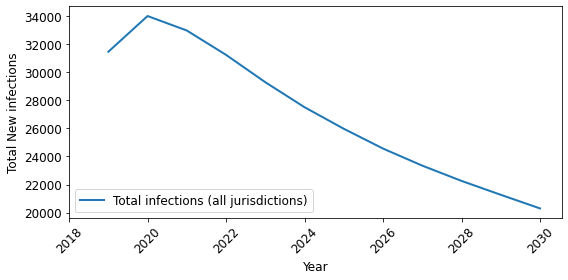

In [40]:
# inf_list: length 12; each element is a list of 95 jurisdiction values
# (If a jurisdiction value is an array per risk/age, we sum it below.)

def _sum_per_jurisdiction(step):
    """step: list of 95 items; each item may be scalar or array. Return (95,) sums."""
    return np.array([np.sum(np.asarray(x, dtype=float)) for x in step], dtype=float)

# Build (T, J) = (12, 95) matrix of jurisdiction totals
inf_mat = np.stack([ _sum_per_jurisdiction(step) for step in inf_list ], axis=0)

# Overall total per timestep (sum of all jurisdictions)
total_infections = inf_mat.sum(axis=1)            # shape (12,)

# # (Optional) distribution across jurisdictions per timestep
# median_j = np.median(inf_mat, axis=1)             # (12,)
# q25_j    = np.percentile(inf_mat, 25, axis=1)     # (12,)
# q75_j    = np.percentile(inf_mat, 75, axis=1)     # (12,)

# X-axis (timesteps 1..12)
x = np.arange(1, inf_mat.shape[0] + 1)

fig, ax = plt.subplots(1,1,sharex=False, sharey=False, figsize=(8,4))
label=['2018', '2020','2022','2024','2026','2028','2030']
ind = np.arange(0,13,2)

ax.plot(x, total_infections, label="Total infections (all jurisdictions)", linewidth=2)
# ax.set_title("Overall New Infections Across All Jurisdictions")
ax.set_xticks(ind)
ax.set_xticklabels(label, rotation=45, fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total New infections', fontsize=12)
ax.legend(loc='lower left', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()

# for i in range(8):

# plt.figure(figsize=(10,6))
# # Main line: total infections (all jurisdictions)
# line_tot, = plt.plot(x, total_infections, label="Total infections (all jurisdictions)", linewidth=2)

# # # Optional: show dispersion across jurisdictions (median + IQR)
# # color = line_tot.get_color()
# # plt.plot(x, median_j, linestyle="--", label="Median per jurisdiction", color=color, alpha=0.7)
# # plt.fill_between(x, q25_j, q75_j, color=color, alpha=0.15, label="IQR per jurisdiction")

# plt.xlabel("Timestep (years)")
# plt.ylabel("New infections")
# plt.title("Overall New Infections Across All Jurisdictions")
# plt.grid(True, linestyle="--", linewidth=0.5)
# plt.legend()
# plt.xticks(ind)
# plt.xticklabels(label, rotation=45)
# plt.tight_layout()
plt.savefig("total_incidence_all_jur.pdf", format="pdf")
plt.show()

In [16]:
len(diag_list)

12

In [18]:
diag_list[0].shape

(95, 3)

In [19]:
sum(inf_list[0])

31449.07017193667

In [20]:
sum(inf_list[11])

20298.599855209493

In [8]:
(31449.07 - 20298.59)/31449.07

0.35455674841895163

In [25]:
prep_list[0].shape

(95, 3)

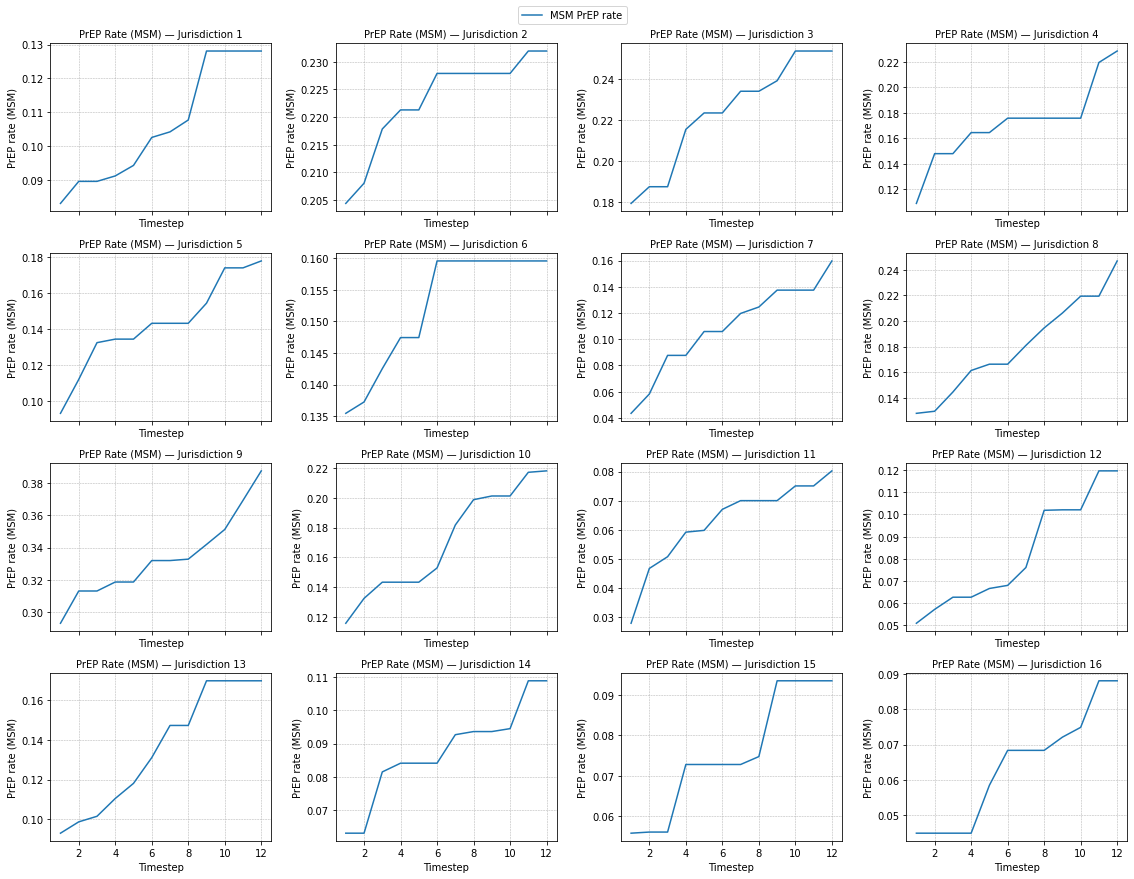

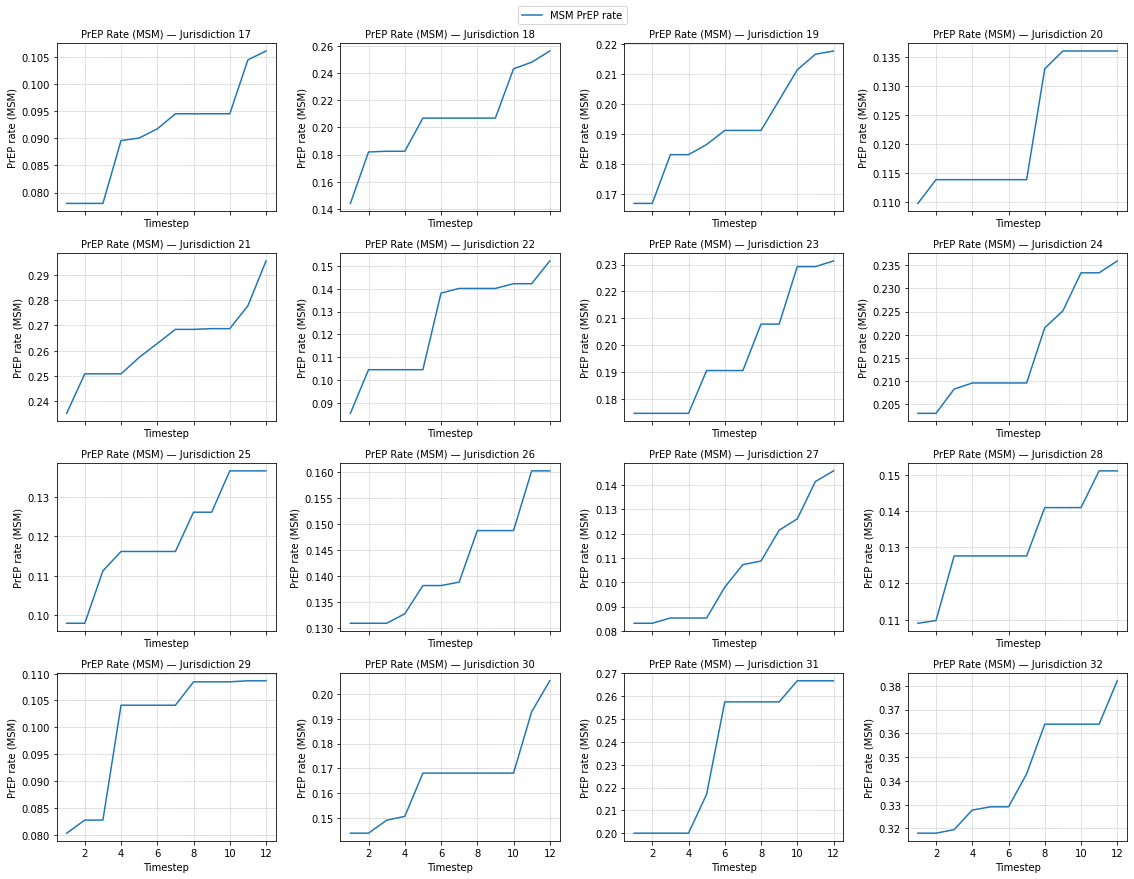

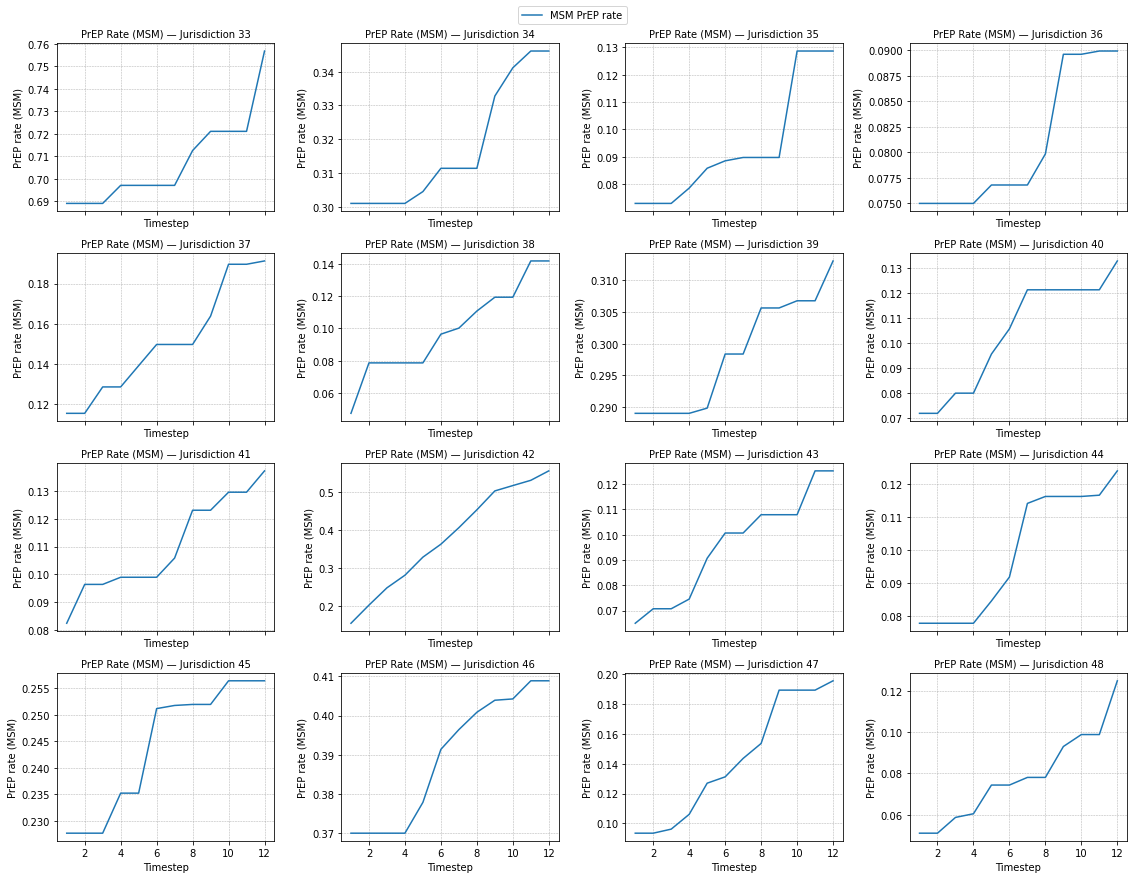

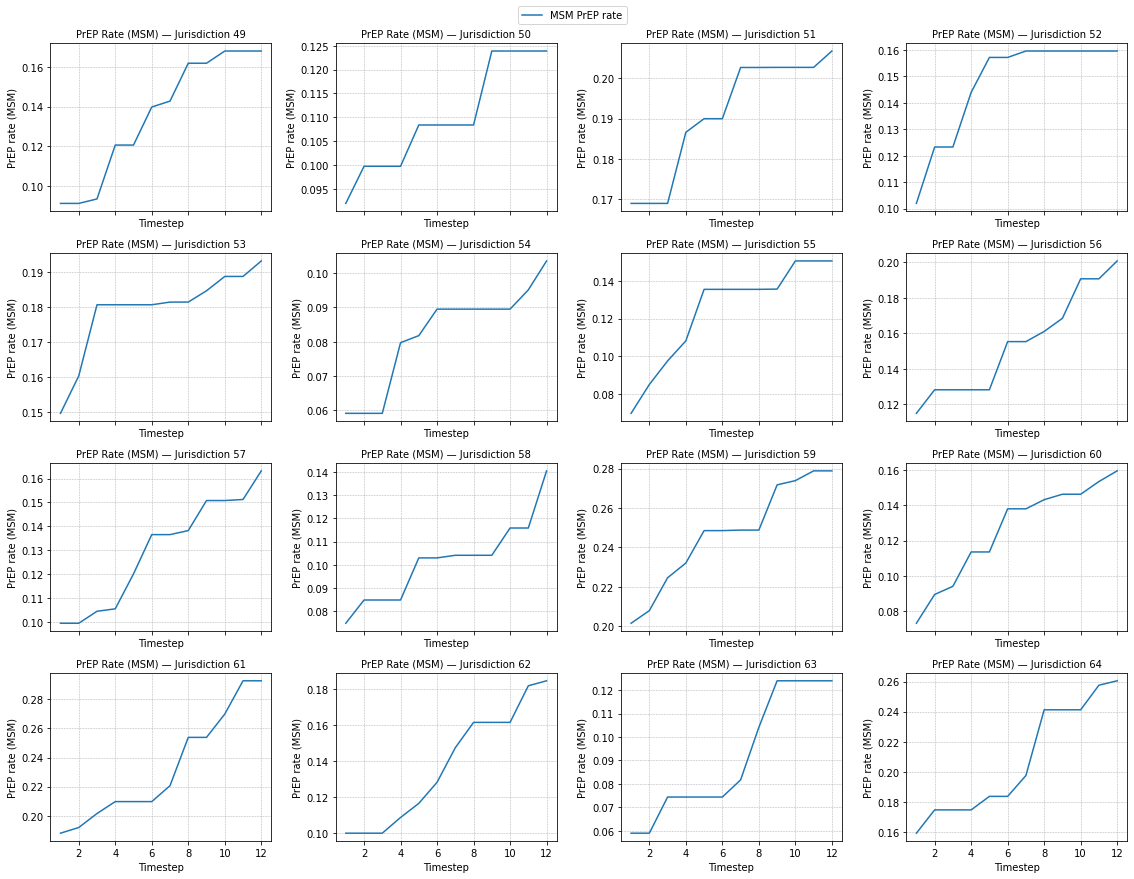

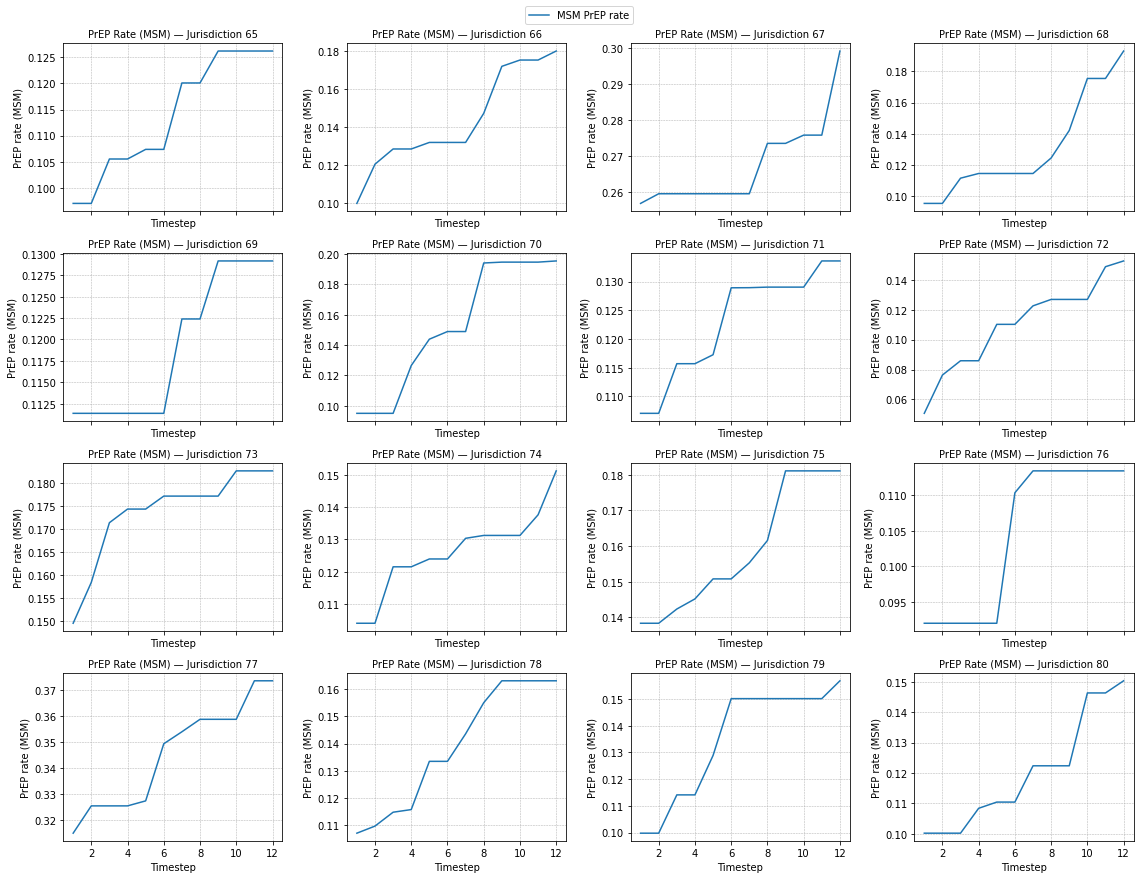

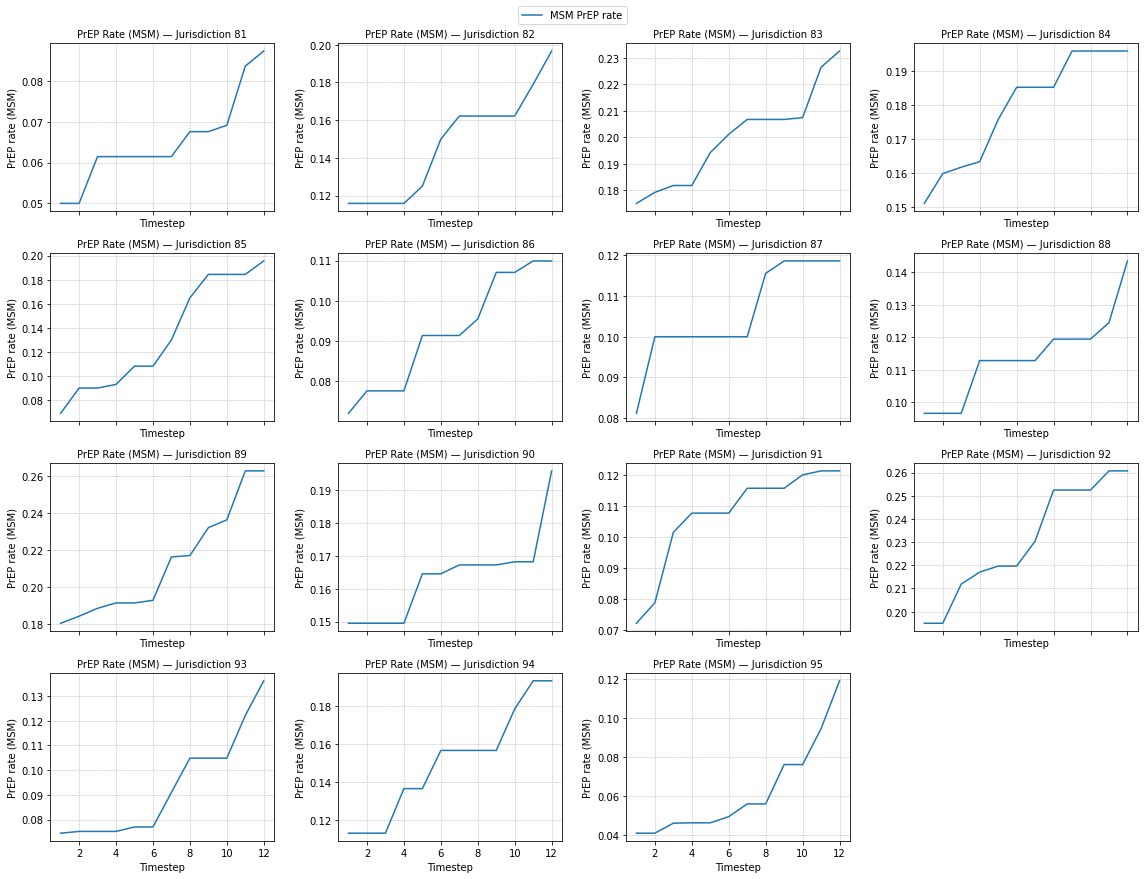

In [54]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

def plot_prep_msm_pages(
    prep_list,
    rows=4,
    cols=4,
    jur_names=None,
    title_prefix="PrEP Rate (MSM) — ",
    sharey=False
):
    """
    prep_list: list length T=12; each element shape (J, 3) with MSM in last column (index 2).
    rows, cols: grid layout per page (jurisdictions per figure = rows * cols)
    jur_names: optional list of J names. If None, uses 'Jurisdiction i'
    sharey: share y-axis across subplots on each page
    """
    # Stack to (T, J, 3)
    prep_arr = np.stack(prep_list, axis=0)  # (12, J, 3)
    T, J, R = prep_arr.shape
    assert T == 12 and R == 3, f"Expected (12, J, 3); got {prep_arr.shape}"

    # MSM column (last)
    msm = prep_arr[..., 2]  # (12, J)

    if jur_names is None:
        jur_names = [f"Jurisdiction {j+1}" for j in range(J)]

    x = np.arange(1, T + 1)

    per_page = rows * cols
    num_pages = ceil(J / per_page)

    for p in range(num_pages):
        start = p * per_page
        end = min((p + 1) * per_page, J)
        count = end - start

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=sharey)
        axes = np.atleast_2d(axes)

        for idx, j in enumerate(range(start, end)):
            r_i, c_i = divmod(idx, cols)
            ax = axes[r_i, c_i]

            y = msm[:, j]
            ax.plot(x, y, label="MSM PrEP rate")
            ax.set_title(f"{title_prefix}{jur_names[j]}", fontsize=10)
            ax.set_xlabel("Timestep")
            ax.set_ylabel("PrEP rate (MSM)")
            ax.grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)

        # Hide unused subplots on last page
        for idx in range(count, per_page):
            r_i, c_i = divmod(idx, cols)
            axes[r_i, c_i].axis("off")

        # Figure-level legend
        first_ax = axes.flat[0]
        handles, labels = first_ax.get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="upper center", ncol=1, bbox_to_anchor=(0.5, 1.02))

        fig.tight_layout()
        plt.savefig('./test_results/prep_96_jur.pdf', format='pdf')
        plt.show()

# ---- Example call ----
# If you have names: jur_names = [...]  # length 95
plot_prep_msm_pages(
    prep_list,
    rows=4,
    cols=4,
    jur_names=None,     # or your list of 95 names
    sharey=False        # set True to keep y-scale identical across a page
)

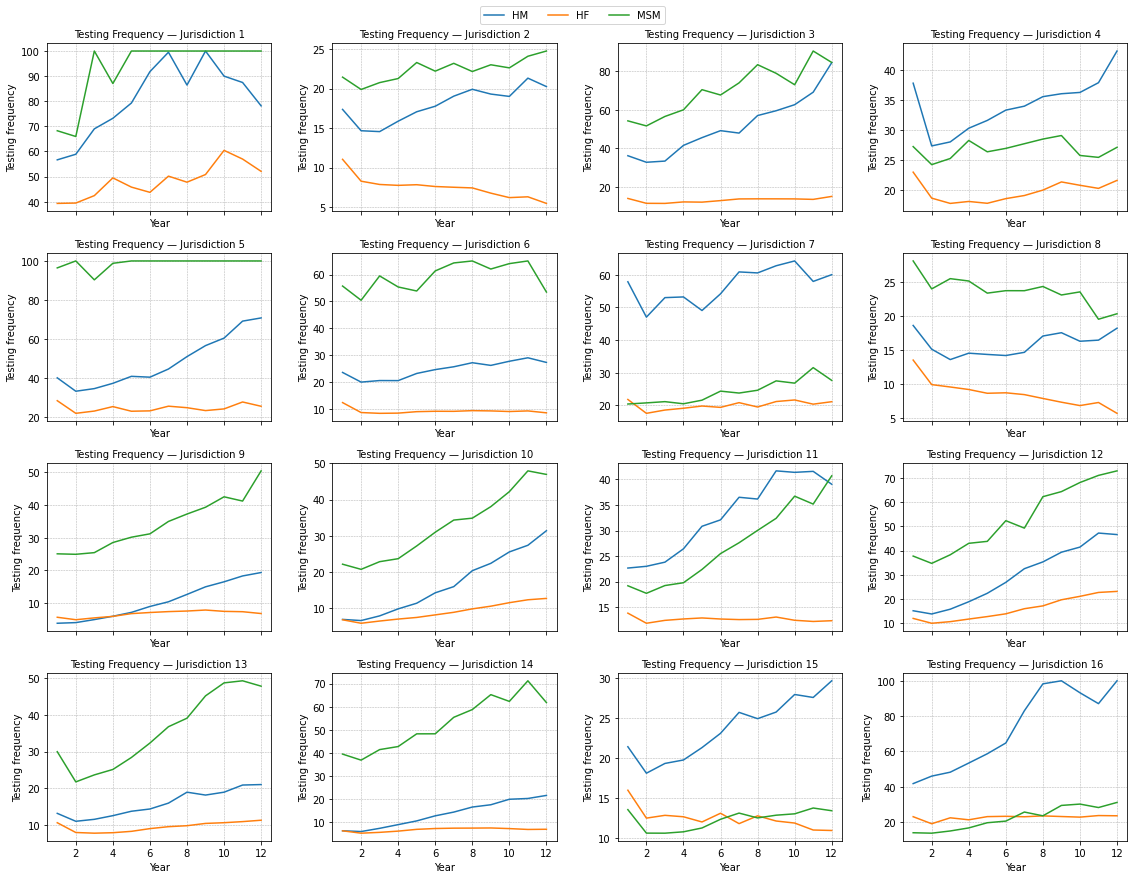

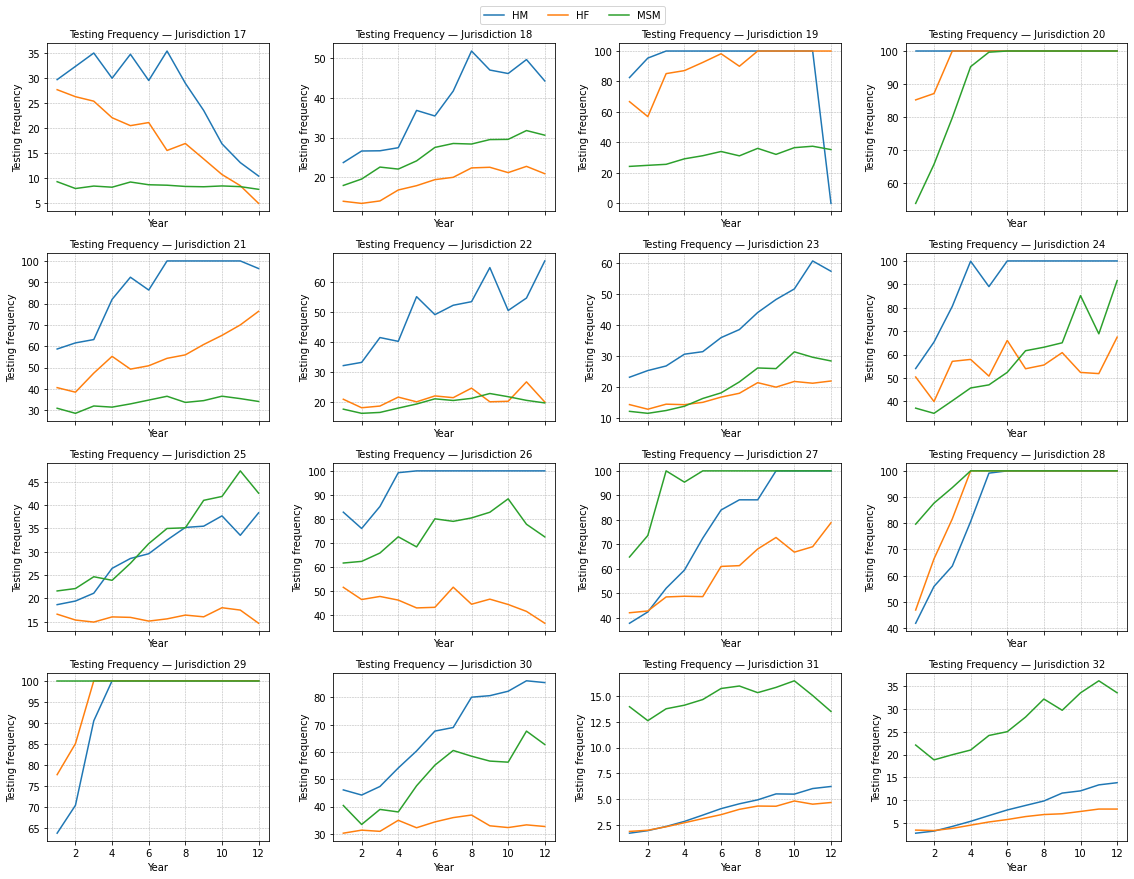

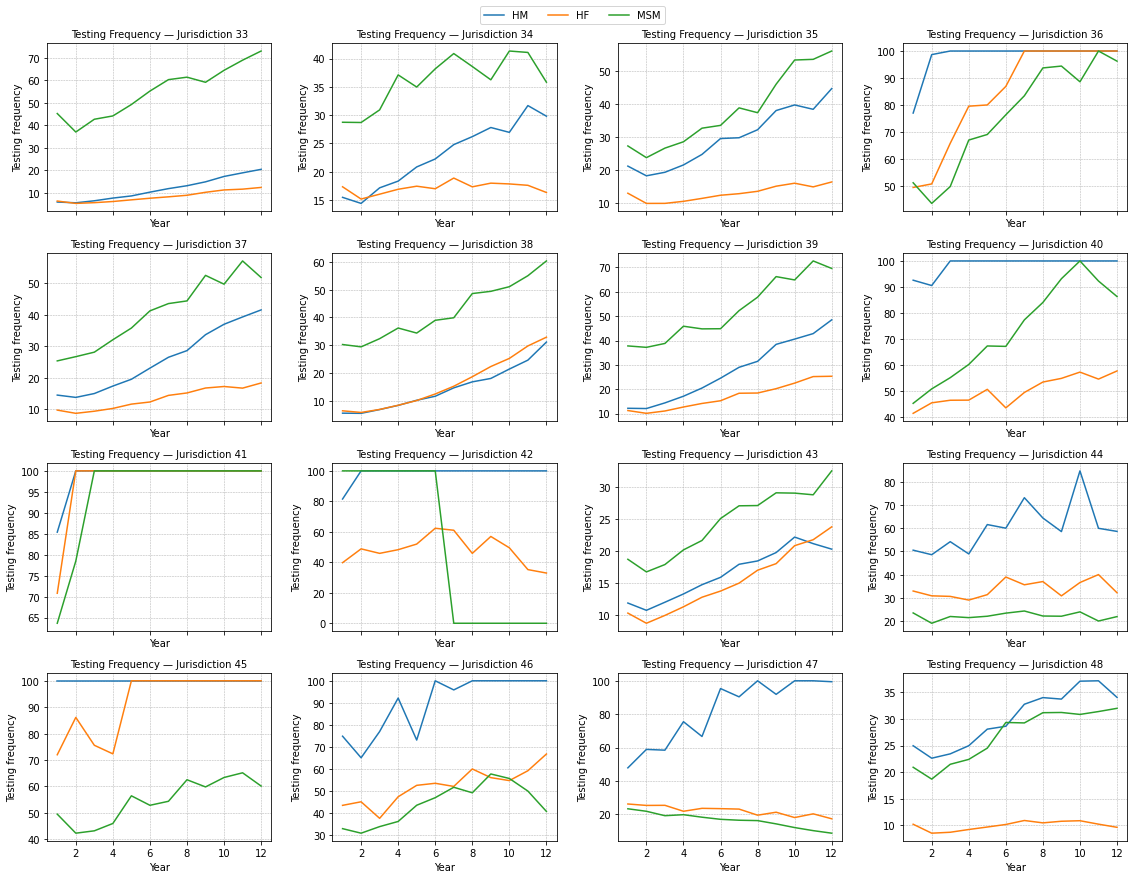

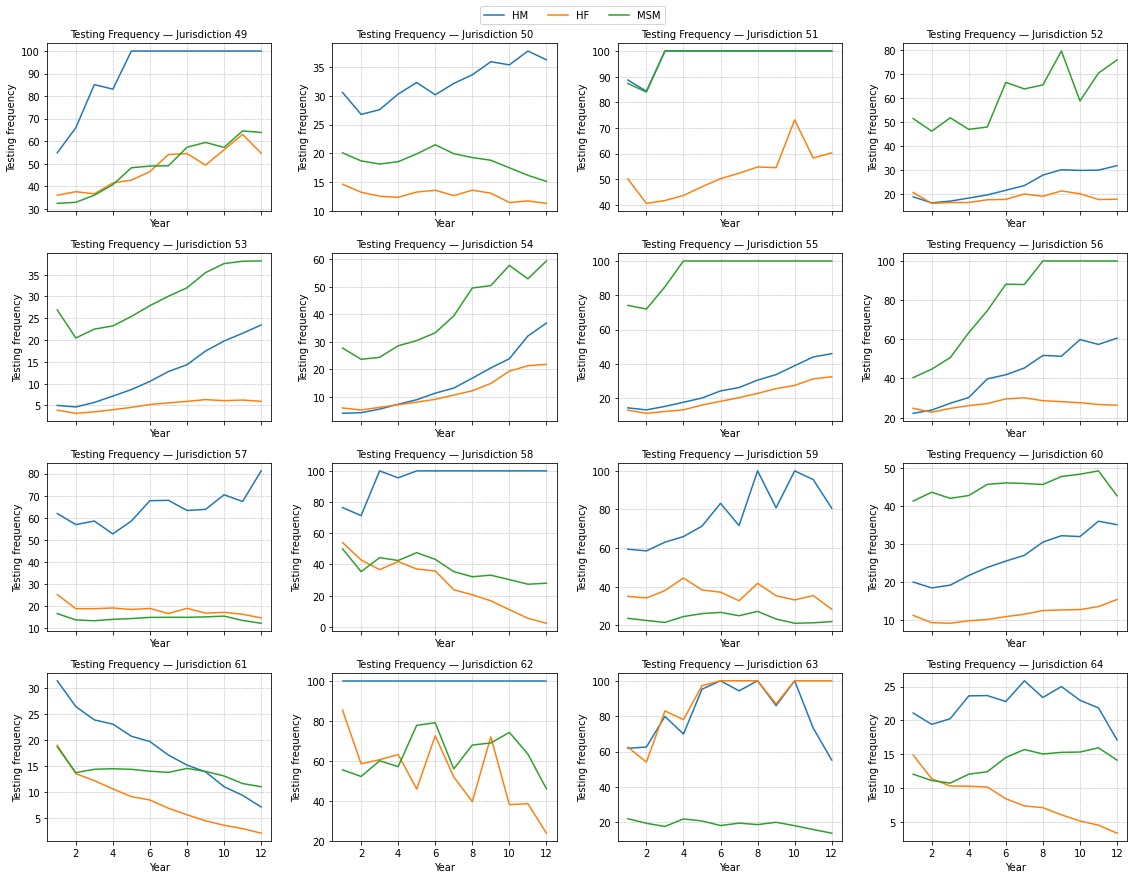

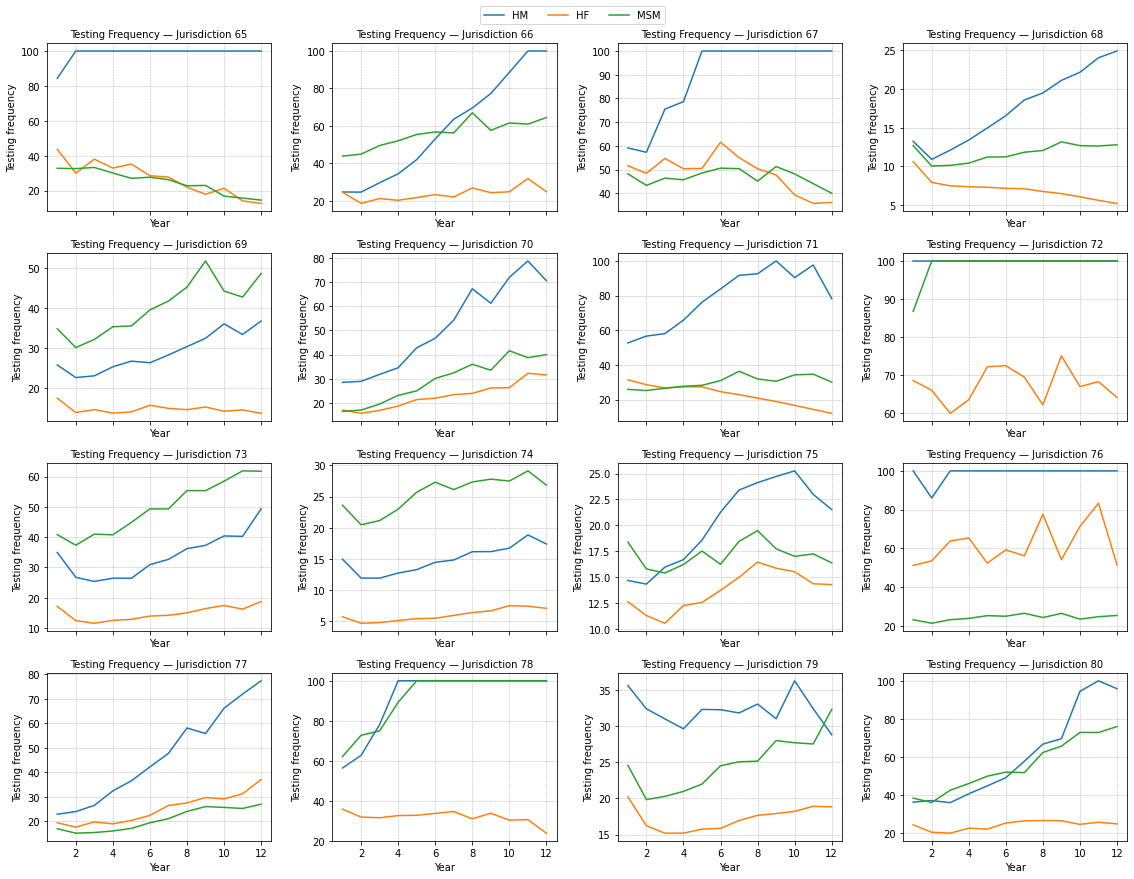

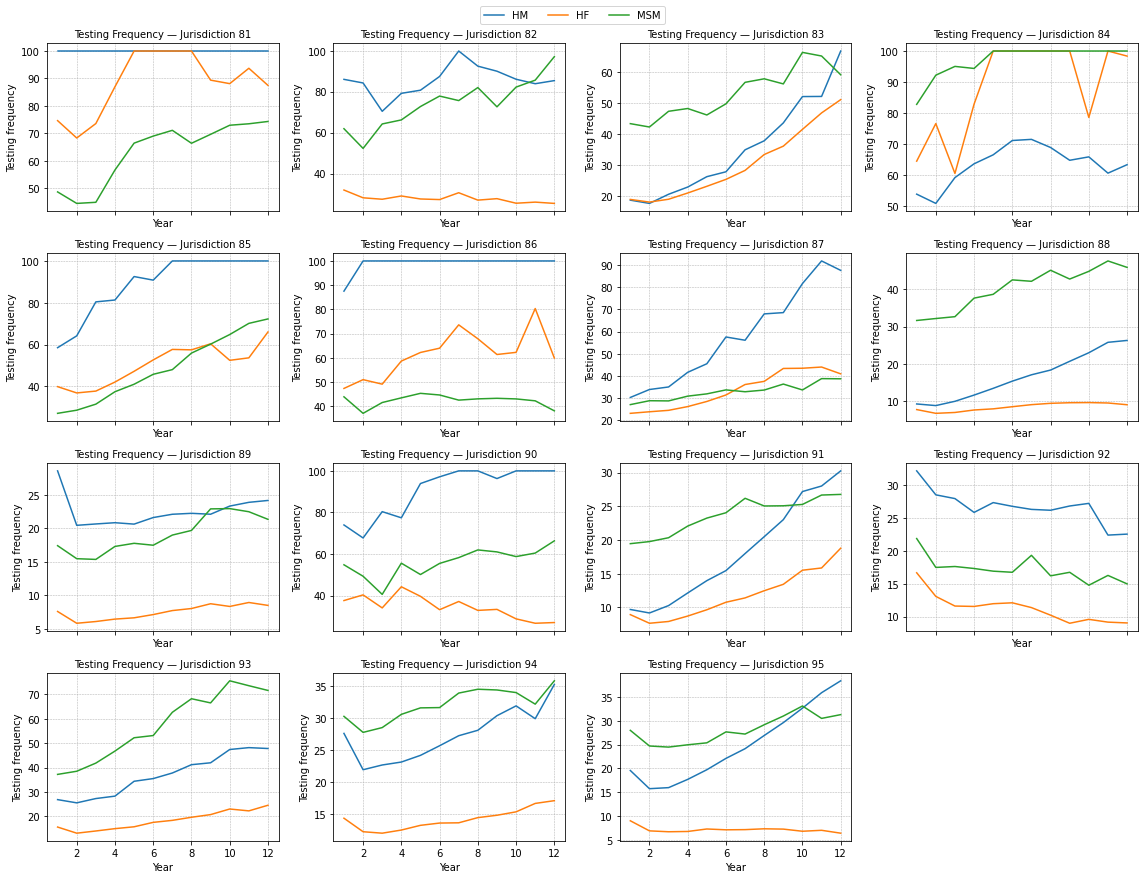

In [55]:
def plot_testing_frequency_pages(
    diag_list,
    rows=3,
    cols=4,
    risk_labels=("Risk 1", "Risk 2", "Risk 3"),
    jur_names=None,
    title_prefix="Testing Frequency — ",
    sharey=False
):
    # Stack to (T, J, R)
    diag_arr = np.stack(diag_list, axis=0)  # (12, J, 3)
    T, J, R = diag_arr.shape
    assert R == 3

    # Compute frequency, cap at 100
    with np.errstate(divide="ignore", invalid="ignore"):
        freq_arr = np.where(diag_arr > 0, 1.0 / diag_arr, 0.0)
    freq_arr = np.clip(freq_arr, 0, 100)

    x = np.arange(1, T + 1)

    if jur_names is None:
        jur_names = [f"Jurisdiction {j+1}" for j in range(J)]

    per_page = rows * cols
    num_pages = ceil(J / per_page)

    for p in range(num_pages):
        start, end = p * per_page, min((p+1)*per_page, J)
        count = end - start

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3),
                                 sharex=True, sharey=sharey)
        axes = np.atleast_2d(axes)

        for idx, j in enumerate(range(start, end)):
            r_i, c_i = divmod(idx, cols)
            ax = axes[r_i, c_i]

            for r in range(R):
                ax.plot(x, freq_arr[:, j, r], label=risk_labels[r])

            ax.set_title(f"{title_prefix}{jur_names[j]}", fontsize=10)
            ax.set_xlabel("Year")
            ax.set_ylabel("Testing frequency")
            ax.grid(True, linestyle="--", linewidth=0.5)

        # Hide unused subplots
        for idx in range(count, per_page):
            r_i, c_i = divmod(idx, cols)
            axes[r_i, c_i].axis("off")

        # Figure-level legend
        handles, labels = axes.flat[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="upper center", ncol=R, bbox_to_anchor=(0.5, 1.02))

        fig.tight_layout()
        plt.savefig('./test_results/testing_96_jur.pdf', format='pdf')
        plt.show()
        
plot_testing_frequency_pages(
    diag_list,
    rows=4,
    cols=4,
    risk_labels=("HM", "HF", "MSM"),  # edit to your risk group names
    jur_names=None,                    # or pass a list of 95 names
    sharey=False                       # set True if you want same y-scale across a page
)

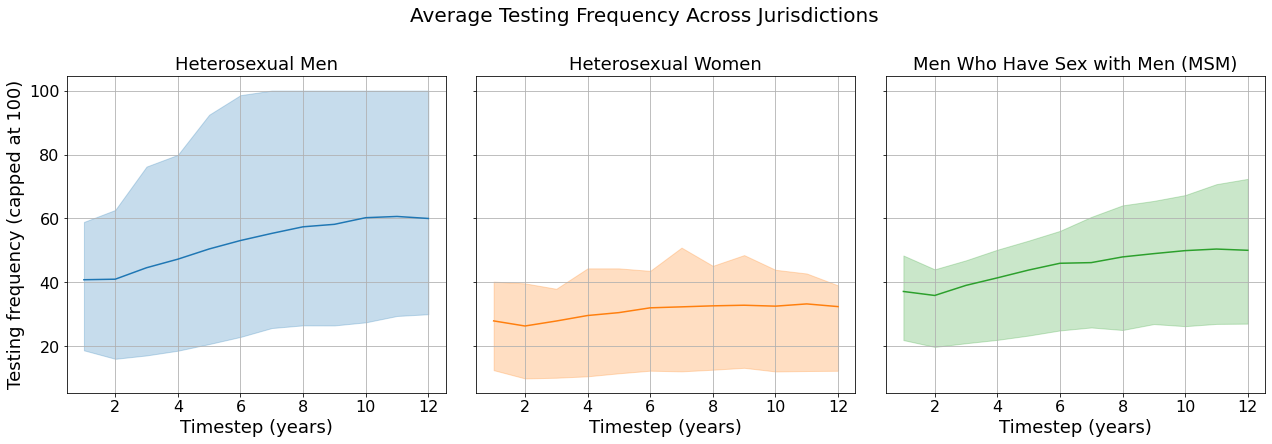

In [56]:
# diag_list: length 12, each (95, 3)
diag_arr = np.stack(diag_list, axis=0)  # shape (12, 95, 3)

# Compute testing frequency, capped at 100
with np.errstate(divide="ignore", invalid="ignore"):
    freq_arr = np.where(diag_arr > 0, 1.0 / diag_arr, 0.0)
freq_arr = np.clip(freq_arr, 0, 100)

T, J, R = freq_arr.shape
x = np.arange(1, T + 1)

# Full titles instead of abbreviations
risk_titles = ["Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"]
colors = ["tab:blue", "tab:orange", "tab:green"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for r, ax in enumerate(axes):
    mean = freq_arr[:, :, r].mean(axis=1)
    lo   = np.percentile(freq_arr[:, :, r], 25, axis=1)
    hi   = np.percentile(freq_arr[:, :, r], 75, axis=1)

    ax.plot(x, mean, label=risk_titles[r], color=colors[r])
    ax.fill_between(x, lo, hi, color=colors[r], alpha=0.25)
    ax.set_title(risk_titles[r], fontsize=18)
    ax.set_xlabel("Timestep (years)", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True)

axes[0].set_ylabel("Testing frequency (capped at 100)", fontsize=18)
fig.suptitle("Average Testing Frequency Across Jurisdictions", y=1.02, fontsize=20)
fig.tight_layout()
plt.savefig('./test_results/testing_avg_all_jur.pdf', format='pdf')
plt.show()

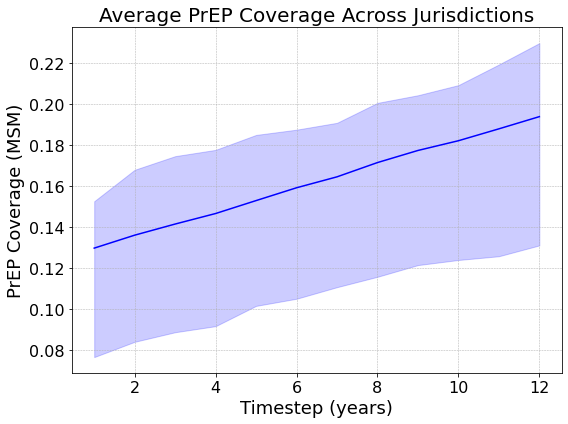

In [57]:
    # Stack to (T, J, 3)
prep_arr = np.stack(prep_list, axis=0)  # (12, J, 3)
T, J, R = prep_arr.shape
assert T == 12 and R == 3, f"Expected (12, J, 3); got {prep_arr.shape}"

# --- MSM PrEP rate ---
prep_msm = prep_arr[:,:,2]  # shape (12, 95)

plt.figure(figsize=(8, 6))
mean = prep_msm.mean(axis=1)
lo   = np.percentile(prep_msm, 25, axis=1)
hi   = np.percentile(prep_msm, 75, axis=1)

plt.plot(x, mean, label="MSM – PrEP Rate", color="blue")
plt.fill_between(x, lo, hi, color="blue", alpha=0.2)

plt.xlabel("Timestep (years)", fontsize=18)
plt.ylabel("PrEP Coverage (MSM)", fontsize=18)
plt.title("Average PrEP Coverage Across Jurisdictions", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.legend(fontsize=16)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig('./test_results/prep_avg_all_jur.pdf', format='pdf')
plt.show()

In [45]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

def plot_retention_pages(
    drop_list,
    rows=4,
    cols=4,
    jur_names=None,
    risk_titles=("Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"),
    colors=("tab:blue", "tab:orange", "tab:green"),
    title_prefix="Retention Rate — ",
    sharey=True
):
    """
    drop_list: list length T=12; each element array (J, 3) for 3 risk groups
    Plots multiple jurisdictions per page, each with 3 risk-group lines.
    """
    drop_arr = np.stack(drop_list, axis=0)            # (12, J, 3)
    drop_arr = np.nan_to_num(drop_arr, nan=0.0)
    retention = 1.0 - drop_arr                         # (12, J, 3)
    retention = np.clip(retention, 0.0, 1.0)

    T, J, R = retention.shape
    x = np.arange(1, T + 1)

    if jur_names is None:
        jur_names = [f"Jurisdiction {j+1}" for j in range(J)]

    per_page = rows * cols
    num_pages = ceil(J / per_page)

    for p in range(num_pages):
        start = p * per_page
        end   = min((p + 1) * per_page, J)
        count = end - start

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 3.8),
                                 sharex=True, sharey=sharey)
        axes = np.atleast_2d(axes)

        for idx, j in enumerate(range(start, end)):
            r_i, c_i = divmod(idx, cols)
            ax = axes[r_i, c_i]
            for r in range(R):
                ax.plot(x, retention[:, j, r], label=risk_titles[r], color=colors[r])
            ax.set_title(f"{title_prefix}{jur_names[j]}", fontsize=18)
            ax.set_xlabel("Timestep (years)", fontsize=18)
            ax.grid(True, linestyle="--", linewidth=0.5)
            ax.tick_params(axis='both', labelsize=16)

        # Hide unused subplots on last page
        for idx in range(count, per_page):
            r_i, c_i = divmod(idx, cols)
            axes[r_i, c_i].axis("off")

        axes[0, 0].set_ylabel("Retention Rate", fontsize=18)
        if sharey:
            for ax in axes.flat:
                if hasattr(ax, "set_ylim"):
                    ax.set_ylim(0, 1.1)

        # Figure-level legend
        handles, labels = axes.flat[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="upper center",
                       ncol=3, bbox_to_anchor=(0.5, 1.02), fontsize=16)

        fig.tight_layout()
        plt.savefig("./test_results/retention_96_jur.pdf", format='pdf')
        plt.show()

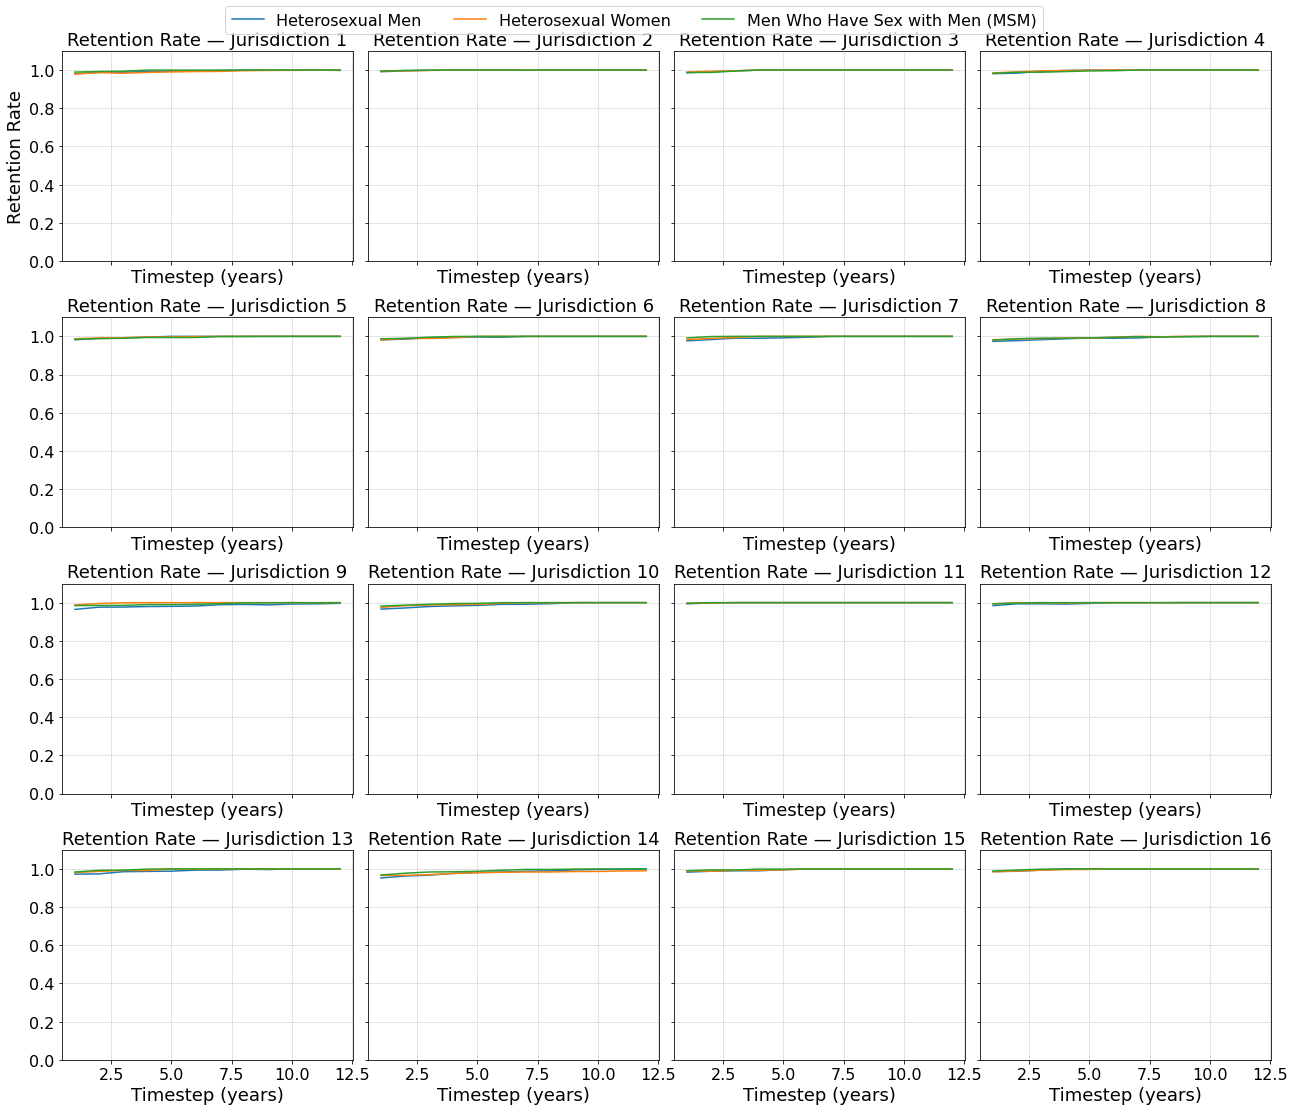

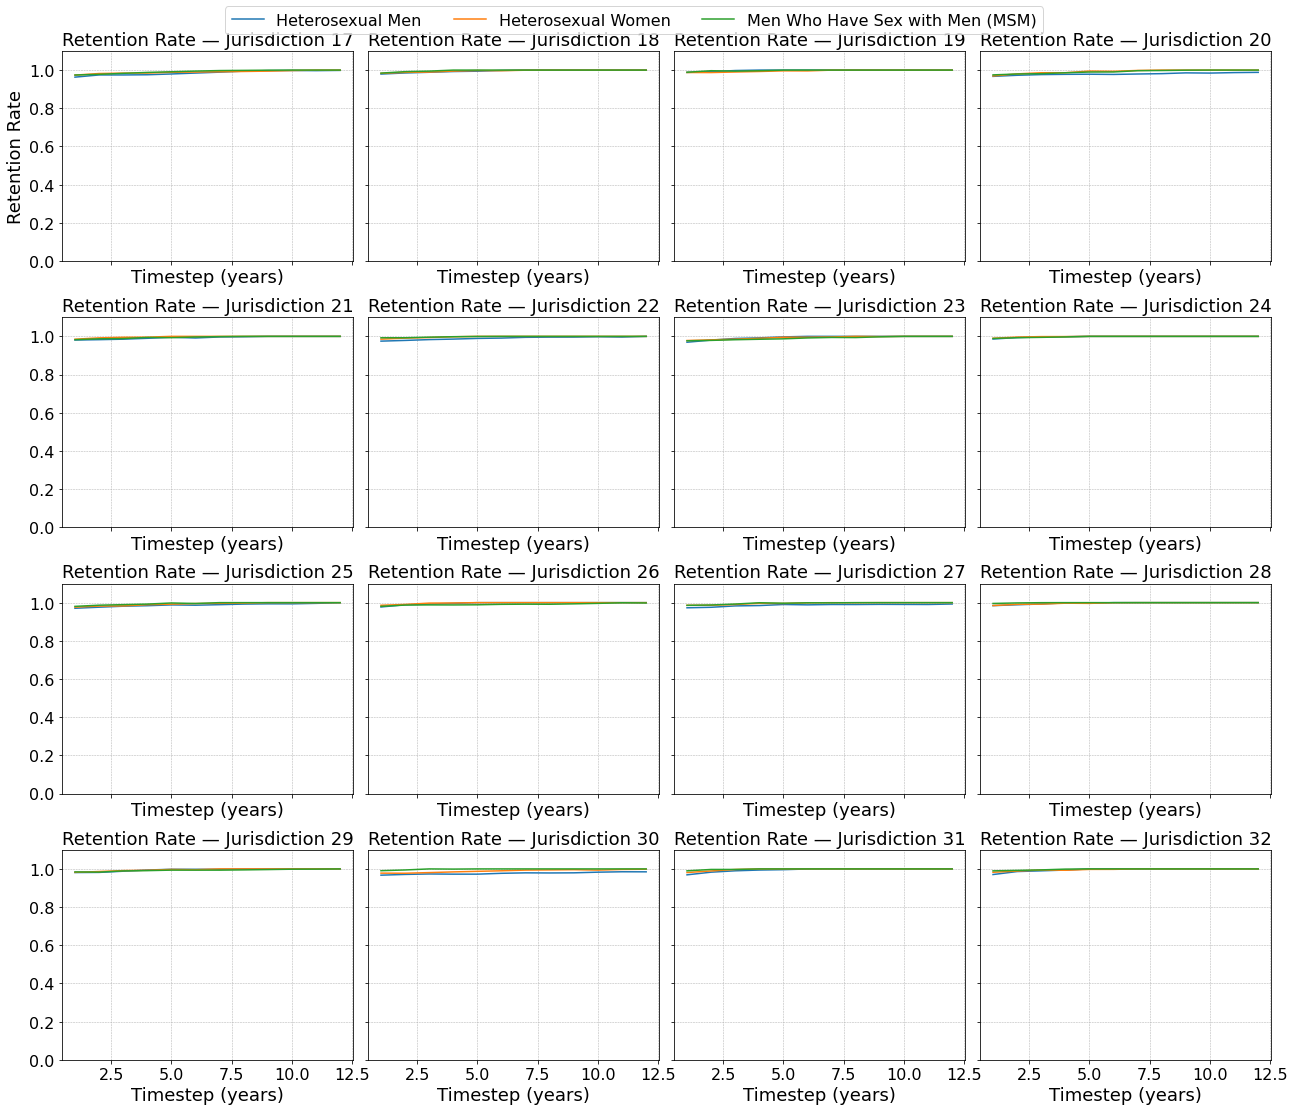

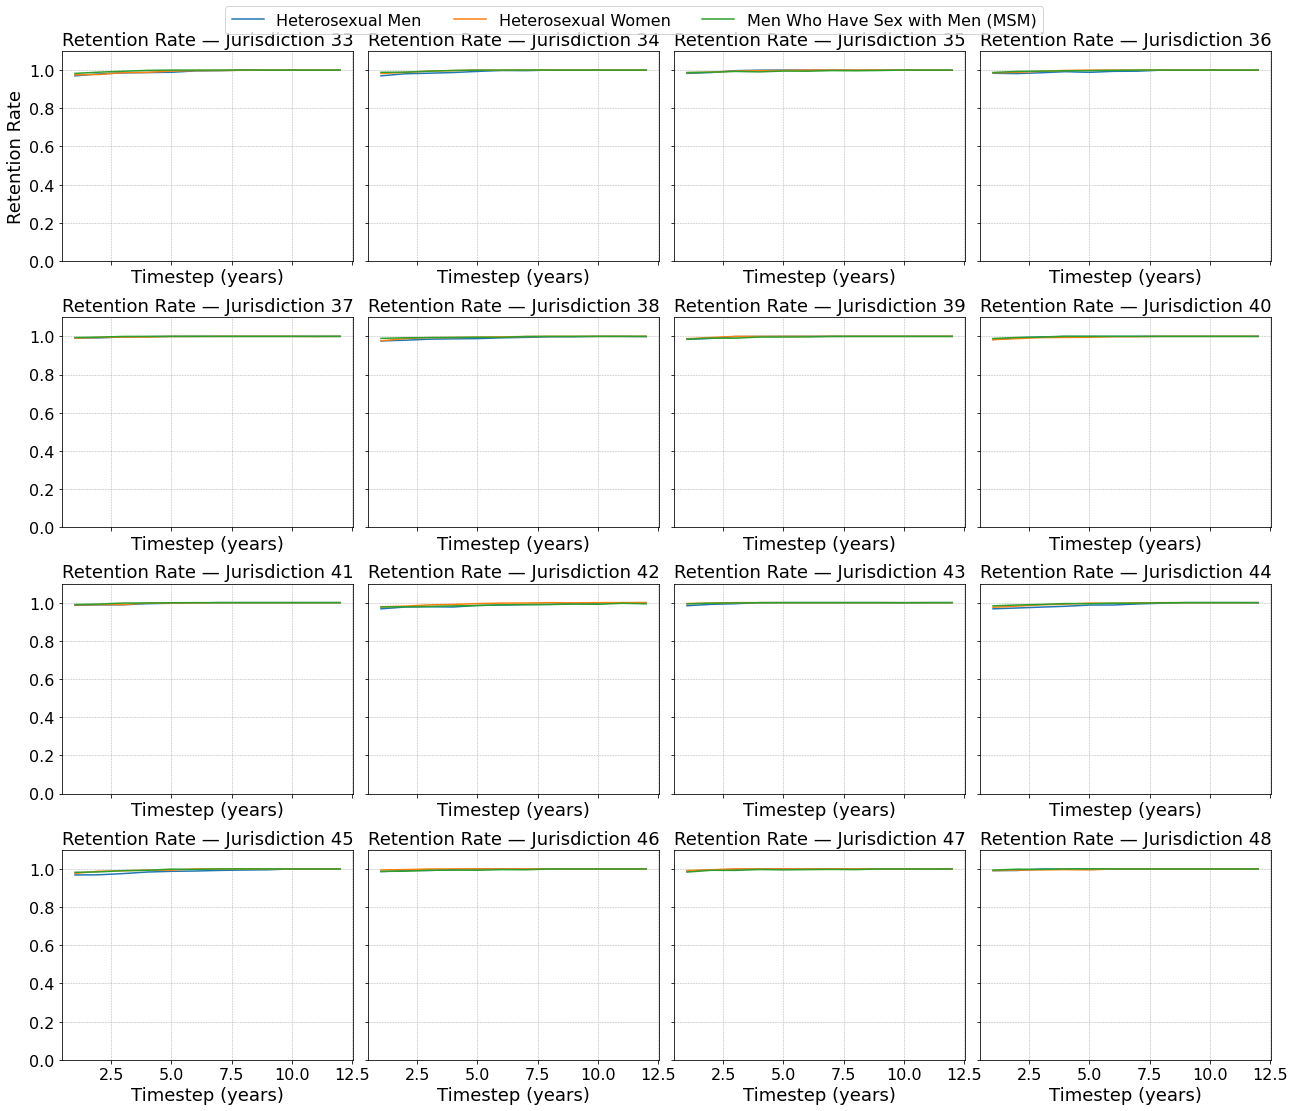

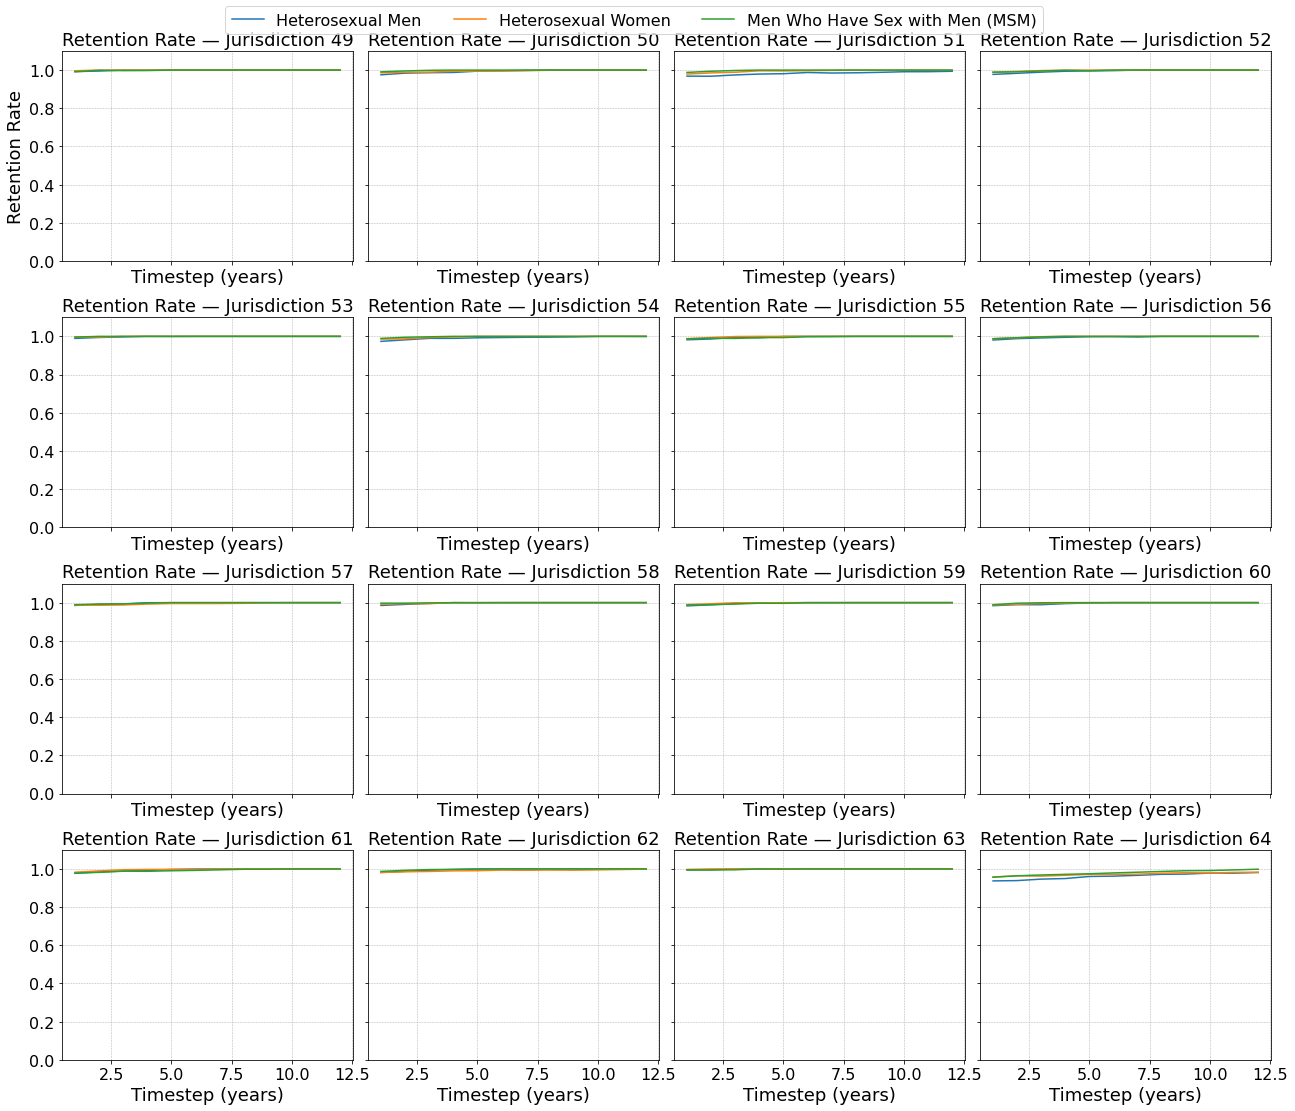

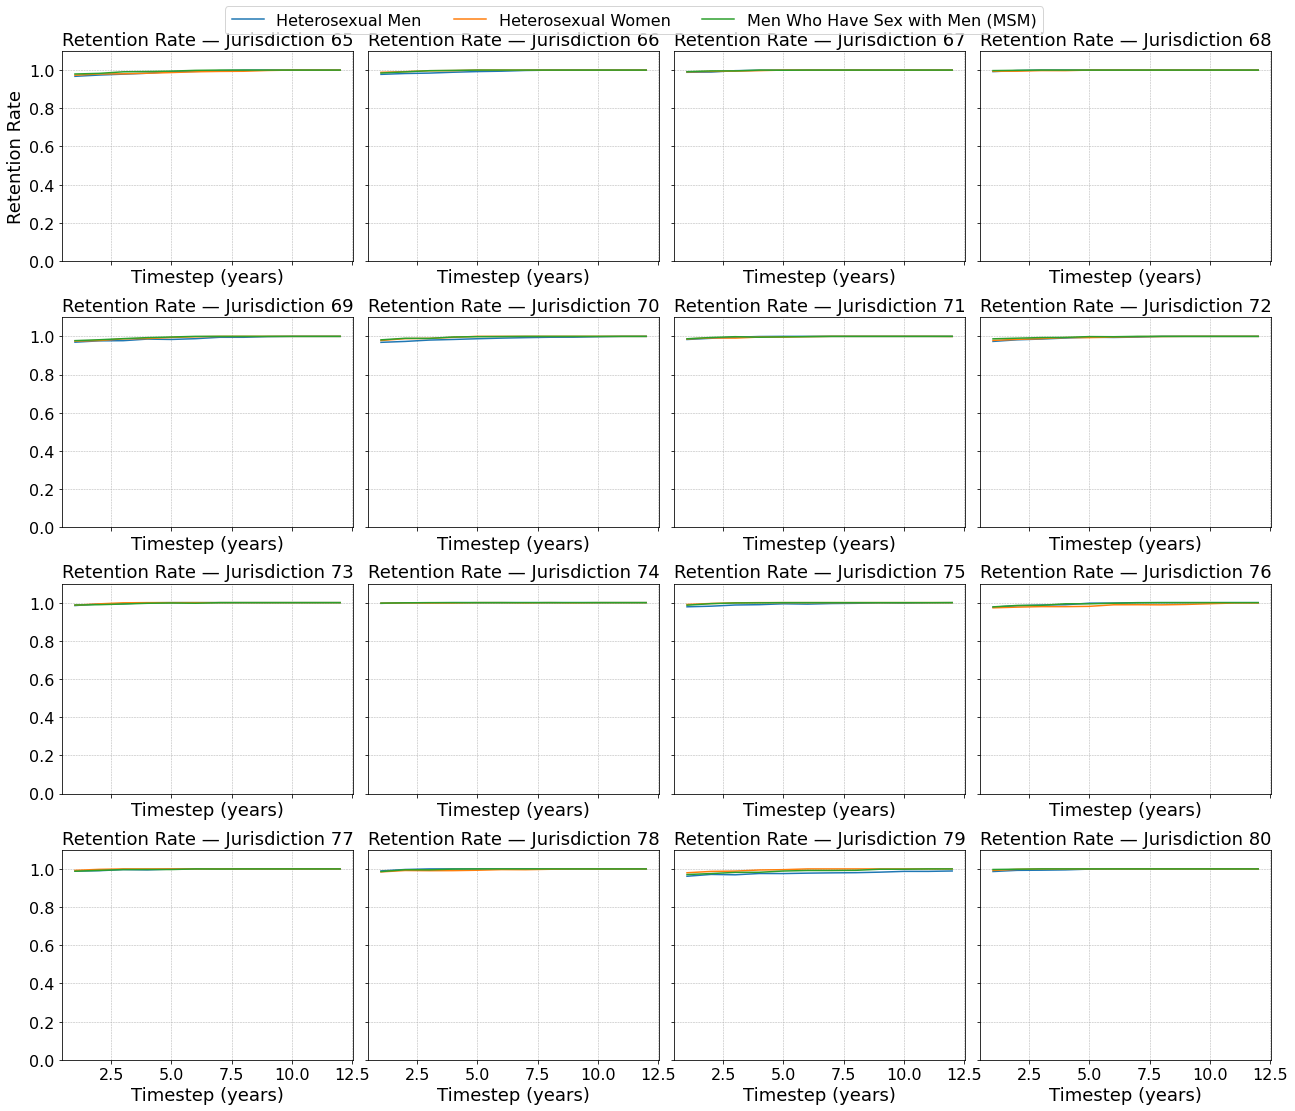

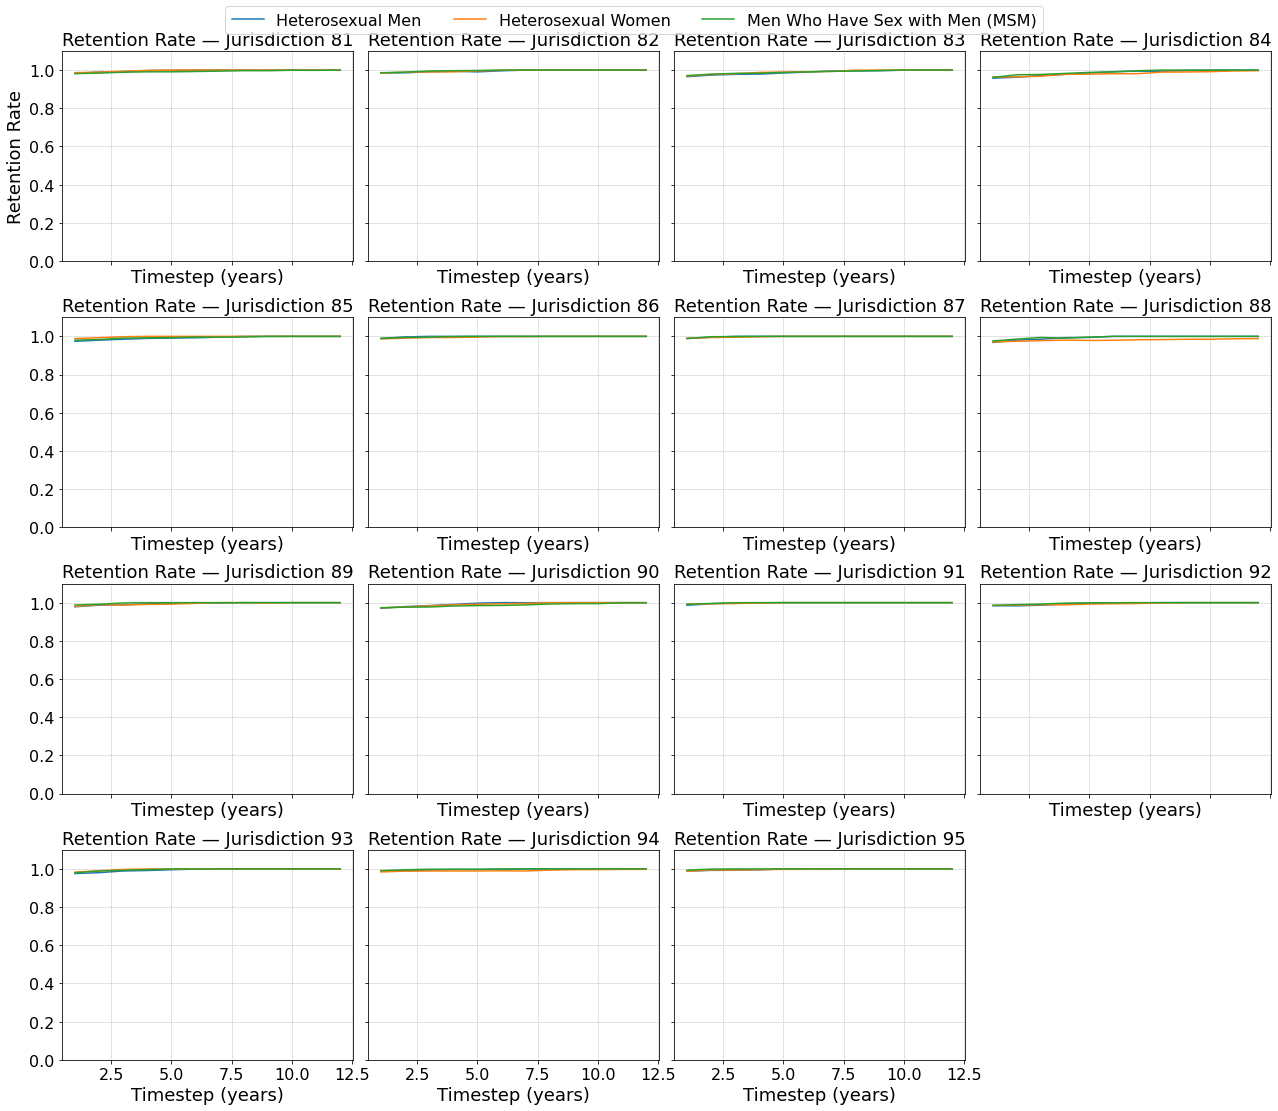

In [46]:
plot_retention_pages(drop_list, rows=4, cols=4)

In [47]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from matplotlib.backends.backend_pdf import PdfPages

def plot_retention_pages(
    drop_list,
    rows=4,
    cols=4,
    jur_names=None,
    risk_titles=("Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"),
    colors=("tab:blue", "tab:orange", "tab:green"),
    title_prefix="Retention Rate — ",
    sharey=True,
    pdf_path="./test_results/retention_96_jur.pdf"
):
    """
    drop_list: list length T=12; each element array (J, 3) for 3 risk groups
    Saves multiple pages (jurisdictions per page) into a single PDF.
    """
    drop_arr = np.stack(drop_list, axis=0)            # (12, J, 3)
    drop_arr = np.nan_to_num(drop_arr, nan=0.0)
    retention = 1.0 - drop_arr                         # (12, J, 3)
    retention = np.clip(retention, 0.0, 1.0)

    T, J, R = retention.shape
    x = np.arange(1, T + 1)

    if jur_names is None:
        jur_names = [f"Jurisdiction {j+1}" for j in range(J)]

    per_page = rows * cols
    num_pages = ceil(J / per_page)

    # Open a single PDF file to collect all figures
    with PdfPages(pdf_path) as pdf:
        for p in range(num_pages):
            start = p * per_page
            end   = min((p + 1) * per_page, J)
            count = end - start

            fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 3.8),
                                     sharex=True, sharey=sharey)
            axes = np.atleast_2d(axes)

            for idx, j in enumerate(range(start, end)):
                r_i, c_i = divmod(idx, cols)
                ax = axes[r_i, c_i]
                for r in range(R):
                    ax.plot(x, retention[:, j, r], label=risk_titles[r], color=colors[r])
                ax.set_title(f"{title_prefix}{jur_names[j]}", fontsize=12)
                ax.set_xlabel("Timestep (years)", fontsize=10)
                ax.grid(True, linestyle="--", linewidth=0.5)
                ax.tick_params(axis='both', labelsize=8)

            # Hide unused subplots on last page
            for idx in range(count, per_page):
                r_i, c_i = divmod(idx, cols)
                axes[r_i, c_i].axis("off")

            axes[0, 0].set_ylabel("Retention Rate", fontsize=12)
            if sharey:
                for ax in axes.flat:
                    if hasattr(ax, "set_ylim"):
                        ax.set_ylim(0, 1.1)

            # Figure-level legend
            handles, labels = axes.flat[0].get_legend_handles_labels()
            if handles:
                fig.legend(handles, labels, loc="upper center",
                           ncol=3, bbox_to_anchor=(0.5, 1.02), fontsize=10)

            fig.tight_layout()

            # Save this page into the PDF
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ Saved all {num_pages} pages into {pdf_path}")

In [48]:
plot_retention_pages(
    drop_list,
    rows=4,
    cols=4,
    jur_names=None,
    pdf_path="./test_results/retention_96_jur.pdf"
)

✅ Saved all 6 pages into ./test_results/retention_96_jur.pdf


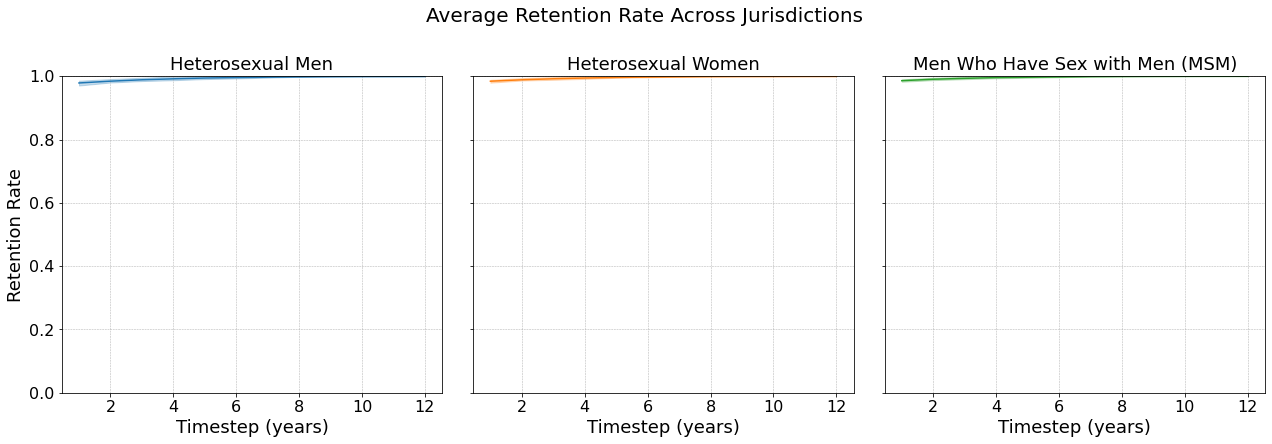

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Stack and compute retention
drop_arr = np.stack(drop_list, axis=0)          # (12, 95, 3)
drop_arr = np.nan_to_num(drop_arr, nan=0.0)
ret_arr  = np.clip(1.0 - drop_arr, 0.0, 1.0)    # (12, 95, 3)

T, J, R = ret_arr.shape
x = np.arange(1, T + 1)

risk_titles = ["Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"]
colors = ["tab:blue", "tab:orange", "tab:green"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for r, ax in enumerate(axes):
    mean = ret_arr[:, :, r].mean(axis=1)
    lo   = np.percentile(ret_arr[:, :, r], 25, axis=1)
    hi   = np.percentile(ret_arr[:, :, r], 75, axis=1)

    ax.plot(x, mean, label=risk_titles[r], color=colors[r])
    ax.fill_between(x, lo, hi, color=colors[r], alpha=0.25)
    ax.set_title(risk_titles[r], fontsize=18)
    ax.set_xlabel("Timestep (years)", fontsize=18)
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylim(0, 1)

axes[0].set_ylabel("Retention Rate", fontsize=18)
fig.suptitle("Average Retention Rate Across Jurisdictions", y=1.02, fontsize=20)
fig.tight_layout()
plt.show()

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from matplotlib.backends.backend_pdf import PdfPages

def plot_testing_frequency_pages(
    diag_list,
    rows=3,
    cols=4,
    risk_labels=("Risk 1", "Risk 2", "Risk 3"),
    jur_names=None,
    title_prefix="Testing Frequency — ",
    sharey=False,
    pdf_path="./test_results/testing_frequency_pages.pdf"  # save path
):
    # Stack to (T, J, R)
    diag_arr = np.stack(diag_list, axis=0)  # (12, J, 3)
    T, J, R = diag_arr.shape
    assert R == 3

    # Compute frequency, cap at 100
    with np.errstate(divide="ignore", invalid="ignore"):
        freq_arr = np.where(diag_arr > 0, 1.0 / diag_arr, 0.0)
    freq_arr = np.clip(freq_arr, 0, 100)

    x = np.arange(1, T + 1)

    if jur_names is None:
        jur_names = [f"Jurisdiction {j+1}" for j in range(J)]

    per_page = rows * cols
    num_pages = ceil(J / per_page)

    # Open a PDF to collect all pages
    with PdfPages(pdf_path) as pdf:
        for p in range(num_pages):
            start, end = p * per_page, min((p+1)*per_page, J)
            count = end - start

            fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3),
                                     sharex=True, sharey=sharey)
            axes = np.atleast_2d(axes)

            for idx, j in enumerate(range(start, end)):
                r_i, c_i = divmod(idx, cols)
                ax = axes[r_i, c_i]

                for r in range(R):
                    ax.plot(x, freq_arr[:, j, r], label=risk_labels[r])

                ax.set_title(f"{title_prefix}{jur_names[j]}", fontsize=10)
                ax.set_xlabel("Year")
                ax.set_ylabel("Testing frequency")
                ax.grid(True, linestyle="--", linewidth=0.5)

            # Hide unused subplots
            for idx in range(count, per_page):
                r_i, c_i = divmod(idx, cols)
                axes[r_i, c_i].axis("off")

            # Figure-level legend
            handles, labels = axes.flat[0].get_legend_handles_labels()
            if handles:
                fig.legend(handles, labels, loc="upper center",
                           ncol=R, bbox_to_anchor=(0.5, 1.02))

            fig.tight_layout()

            # Save this page into the PDF
            pdf.savefig(fig)
            plt.close(fig)  # close so memory doesn’t blow up

    print(f"✅ Saved all {num_pages} pages into {pdf_path}")

In [59]:
plot_testing_frequency_pages(
    diag_list,
    rows=4,
    cols=4,
    risk_labels=("Heterosexual Men", "Heterosexual Women", "MSM"),
    jur_names=None,
    sharey=False,
    pdf_path="./test_results/testing_96_jur.pdf"
)


✅ Saved all 6 pages into ./test_results/testing_96_jur.pdf


In [60]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from matplotlib.backends.backend_pdf import PdfPages

def plot_prep_msm_pages(
    prep_list,
    rows=4,
    cols=4,
    jur_names=None,
    title_prefix="PrEP Rate (MSM) — ",
    sharey=False,
    pdf_path="./test_results/prep_96_jur.pdf"
):
    """
    prep_list: list length T=12; each element shape (J, 3) with MSM in last column (index 2).
    rows, cols: grid layout per page (jurisdictions per figure = rows * cols)
    jur_names: optional list of J names. If None, uses 'Jurisdiction i'
    sharey: share y-axis across subplots on each page
    pdf_path: file path for the combined PDF
    """
    # Stack to (T, J, 3)
    prep_arr = np.stack(prep_list, axis=0)  # (12, J, 3)
    T, J, R = prep_arr.shape
    assert R == 3, f"Expected last dimension = 3; got {R}"

    # MSM column (last)
    msm = prep_arr[..., 2]  # (12, J)

    if jur_names is None:
        jur_names = [f"Jurisdiction {j+1}" for j in range(J)]

    x = np.arange(1, T + 1)
    per_page = rows * cols
    num_pages = ceil(J / per_page)

    with PdfPages(pdf_path) as pdf:
        for p in range(num_pages):
            start = p * per_page
            end = min((p + 1) * per_page, J)
            count = end - start

            fig, axes = plt.subplots(rows, cols,
                                     figsize=(cols * 4, rows * 3),
                                     sharex=True, sharey=sharey)
            axes = np.atleast_2d(axes)

            for idx, j in enumerate(range(start, end)):
                r_i, c_i = divmod(idx, cols)
                ax = axes[r_i, c_i]

                y = msm[:, j]
                ax.plot(x, y, label="MSM PrEP rate", color="tab:green")
                ax.set_title(f"{title_prefix}{jur_names[j]}", fontsize=10)
                ax.set_xlabel("Timestep")
                ax.set_ylabel("PrEP rate (MSM)")
                ax.grid(True, linestyle="--", linewidth=0.5)

            # Hide unused subplots
            for idx in range(count, per_page):
                r_i, c_i = divmod(idx, cols)
                axes[r_i, c_i].axis("off")

            # Figure-level legend
            first_ax = axes.flat[0]
            handles, labels = first_ax.get_legend_handles_labels()
            if handles:
                fig.legend(handles, labels, loc="upper center",
                           ncol=1, bbox_to_anchor=(0.5, 1.02))

            fig.tight_layout()

            # Save this page
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ Saved all {num_pages} pages into {pdf_path}")

In [61]:
plot_prep_msm_pages(
    prep_list,
    rows=4,
    cols=4,
    jur_names=None,     # or your list of 95 names
    sharey=False,
    pdf_path="./test_results/prep_96_jur.pdf"
)

✅ Saved all 6 pages into ./test_results/prep_96_jur.pdf


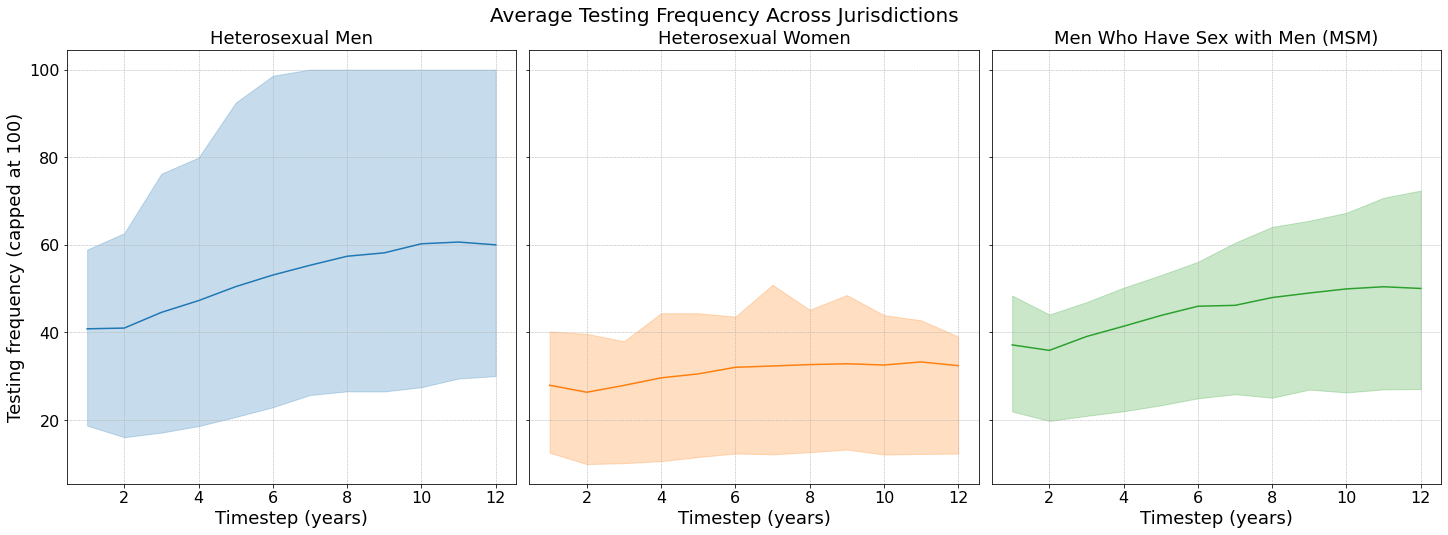

Saved to ./test_results/testing_avg_all_jur.pdf


In [67]:
import os
os.makedirs("./test_results", exist_ok=True)

# diag_list: length 12, each (95, 3)
diag_arr = np.stack(diag_list, axis=0)  # shape (12, 95, 3)

# Compute testing frequency, capped at 100
with np.errstate(divide="ignore", invalid="ignore"):
    freq_arr = np.where(diag_arr > 0, 1.0 / diag_arr, 0.0)
freq_arr = np.clip(freq_arr, 0, 100)

T, J, R = freq_arr.shape
x = np.arange(1, T + 1)

risk_titles = ["Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"]
colors = ["tab:blue", "tab:orange", "tab:green"]

# Use constrained_layout to let Matplotlib manage margins
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharex=True, sharey=True, constrained_layout=True)

for r, ax in enumerate(axes):
    mean = freq_arr[:, :, r].mean(axis=1)
    lo   = np.percentile(freq_arr[:, :, r], 25, axis=1)
    hi   = np.percentile(freq_arr[:, :, r], 75, axis=1)

    ax.plot(x, mean, label=risk_titles[r], color=colors[r])
    ax.fill_between(x, lo, hi, color=colors[r], alpha=0.25)
    ax.set_title(risk_titles[r], fontsize=18)
    ax.set_xlabel("Timestep (years)", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, linestyle="--", linewidth=0.5)

axes[0].set_ylabel("Testing frequency (capped at 100)", fontsize=18)

# Add suptitle and nudge layout so it isn't clipped
fig.suptitle("Average Testing Frequency Across Jurisdictions", fontsize=20, y=1.04)
# If you prefer tight_layout instead of constrained_layout, use:
# fig.tight_layout(rect=[0, 0, 1, 0.95])  # leaves 5% top margin for suptitle

# Save with tight bounding box and a tiny padding
out_path = "./test_results/testing_avg_all_jur.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

print(f"Saved to {out_path}")

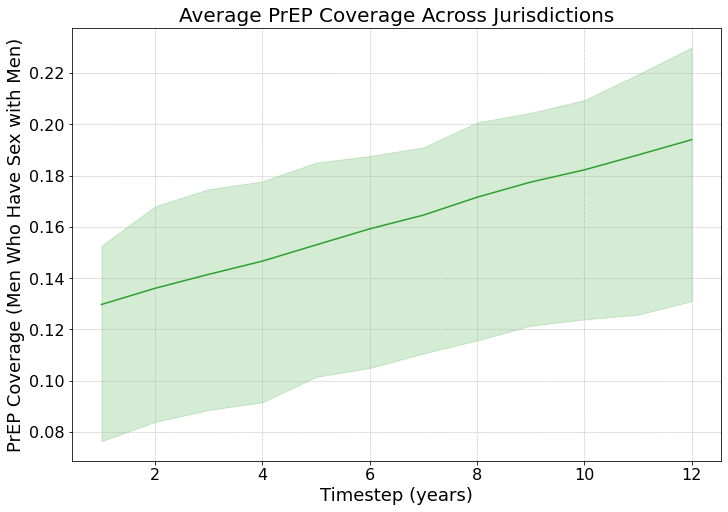

Saved to ./test_results/prep_avg_all_jur.pdf


In [68]:
import os
os.makedirs("./test_results", exist_ok=True)

# Stack to (T, J, 3)
prep_arr = np.stack(prep_list, axis=0)  # (12, J, 3)
T, J, R = prep_arr.shape
assert T == 12 and R == 3, f"Expected (12, J, 3); got {prep_arr.shape}"

# --- MSM PrEP rate ---
prep_msm = prep_arr[:, :, 2]  # shape (12, 95)

fig, ax = plt.subplots(figsize=(10, 7), constrained_layout=True)

mean = prep_msm.mean(axis=1)
lo   = np.percentile(prep_msm, 25, axis=1)
hi   = np.percentile(prep_msm, 75, axis=1)

ax.plot(x, mean, label="Men Who Have Sex with Men (MSM) – PrEP Coverage", color="tab:green")
ax.fill_between(x, lo, hi, color="tab:green", alpha=0.2)

ax.set_xlabel("Timestep (years)", fontsize=18)
ax.set_ylabel("PrEP Coverage (Men Who Have Sex with Men)", fontsize=18)
ax.set_title("Average PrEP Coverage Across Jurisdictions", fontsize=20)
ax.tick_params(axis='both', labelsize=16)
# ax.legend(fontsize=16)  # optional
ax.grid(True, linestyle="--", linewidth=0.5)

# Save with bounding box to prevent clipping
out_path = "./test_results/prep_avg_all_jur.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

print(f"Saved to {out_path}")

In [6]:
# 1) Overlay of 96 jurisdiction trajectories colored by normalized incidence

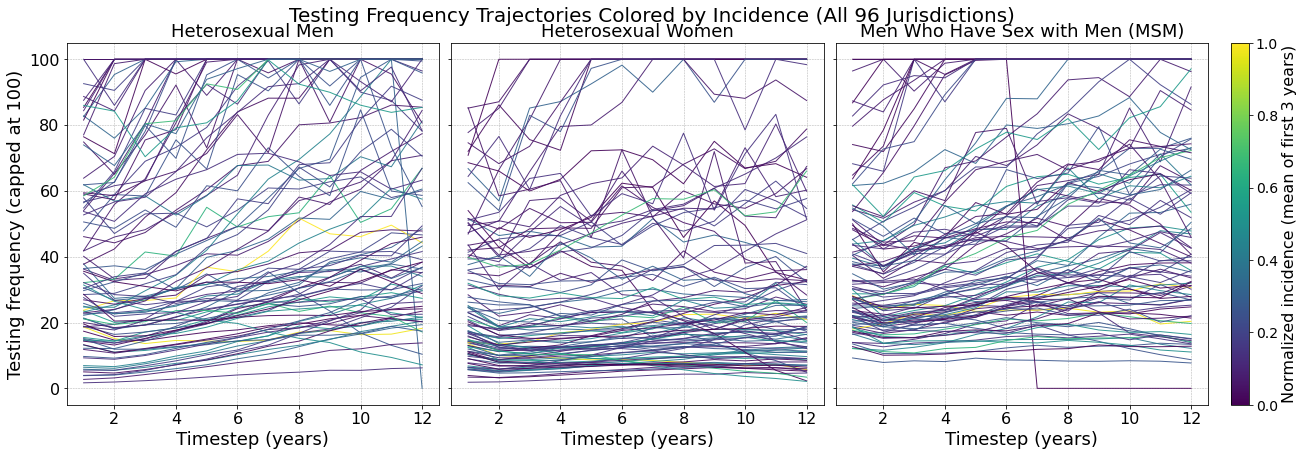

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ---------- Prepare inputs ----------
# inf_list: length 12; each item: list/array of 95 (total infections per jurisdiction)
# diag_list: length 12; each item: (95, 3) array (diagnosis rate per risk group)

# (T, J)
# inf_mat = np.stack([np.array(step, dtype=float) for step in inf_list], axis=0)  # shape (12, 95)

# incidence metric per jurisdiction = mean infections over first 3 years
incidence_j = inf_list[:3, :].mean(axis=0)  # shape (95,)

# normalize to [0, 1] for coloring
inc_min, inc_max = incidence_j.min(), incidence_j.max()
den = (inc_max - inc_min) if (inc_max > inc_min) else 1.0
inc_norm = (incidence_j - inc_min) / den  # shape (95,)

# (T, J, R)
diag_arr = np.stack(diag_list, axis=0).astype(float)

# testing frequency = 1 / diag (0 -> 0), then clip to 100
with np.errstate(divide="ignore", invalid="ignore"):
    freq_arr = np.where(diag_arr > 0, 1.0 / diag_arr, 0.0)
freq_arr = np.clip(freq_arr, 0.0, 100.0)

T, J, R = freq_arr.shape
x = np.arange(1, T + 1)

risk_titles = ["Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"]
cmap = plt.cm.viridis  # choose your colormap (e.g., viridis, plasma, etc.)
norm = Normalize(vmin=0.0, vmax=1.0)

# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True, constrained_layout=True)

for r, ax in enumerate(axes):
    # plot each jurisdiction line colored by its normalized incidence
    for j in range(J):
        ax.plot(x, freq_arr[:, j, r],
                color=cmap(norm(inc_norm[j])),
                linewidth=1.0,
                alpha=0.9)

    ax.set_title(risk_titles[r], fontsize=18)
    ax.set_xlabel("Timestep (years)", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, linestyle="--", linewidth=0.5)

axes[0].set_ylabel("Testing frequency (capped at 100)", fontsize=18)

# add a colorbar to explain the coloring by incidence
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.025, pad=0.02)
cbar.set_label("Normalized incidence (mean of first 3 years)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.suptitle("Testing Frequency Trajectories Colored by Incidence (All 96 Jurisdictions)", fontsize=20, y=1.03)

# save without clipping
import os
os.makedirs("./test_results", exist_ok=True)
# fig.savefig("./test_results/testing_overlay_colored_by_incidence.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

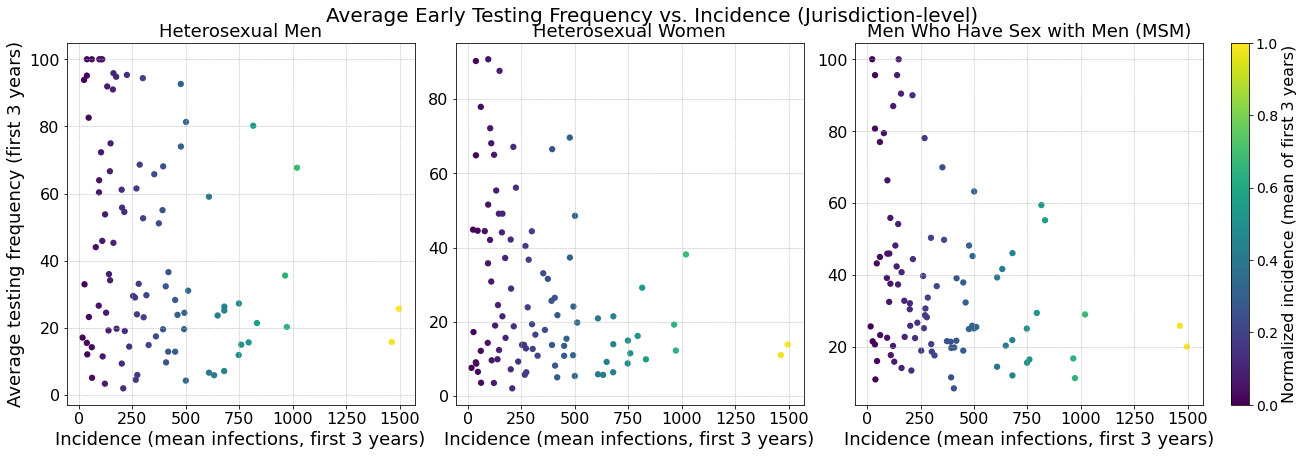

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Using the same inf_mat, incidence_j, incidence normalization, and freq_arr computed above

# average testing frequency over first 3 years, per jurisdiction & risk group
avg3_freq = freq_arr[:3, :, :].mean(axis=0)  # shape (J, R)

risk_titles = ["Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"]
colors = ["tab:blue", "tab:orange", "tab:green"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=False, constrained_layout=True)

for r, ax in enumerate(axes):
    ax.scatter(incidence_j, avg3_freq[:, r],
               c=inc_norm, cmap=plt.cm.viridis, s=40, edgecolors="none")
    ax.set_title(risk_titles[r], fontsize=18)
    ax.set_xlabel("Incidence (mean infections, first 3 years)", fontsize=18)
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.tick_params(axis='both', labelsize=16)

axes[0].set_ylabel("Average testing frequency (first 3 years)", fontsize=18)

# shared colorbar for incidence normalization
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
norm = Normalize(vmin=0.0, vmax=1.0)
sm = ScalarMappable(norm=norm, cmap=plt.cm.viridis)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.025, pad=0.02)
cbar.set_label("Normalized incidence (mean of first 3 years)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.suptitle("Average Early Testing Frequency vs. Incidence (Jurisdiction-level)", fontsize=20, y=1.03)

# save without clipping
# fig.savefig("./test_results/testing_scatter_incidence_vs_avg3freq.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

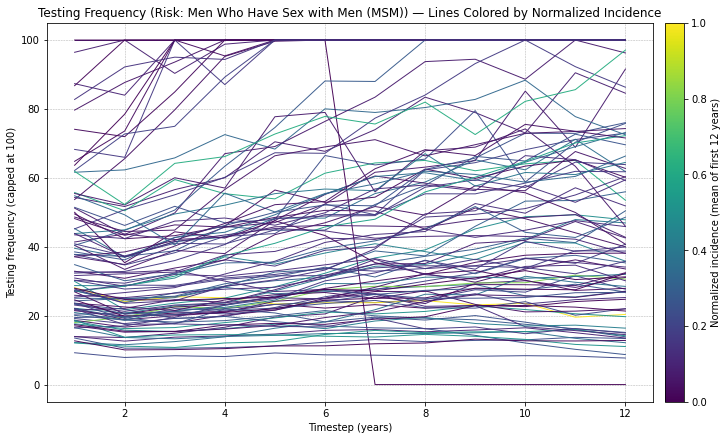

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_overlay_by_incidence(inf_list, diag_list, risk_index=2, title=None,
                              cap_freq=100.0, incidence_years=3):
    """
    Overlay all jurisdictions on one graph, colored by normalized incidence.

    inf_list   : length T list; each item list/array of length J (total infections per jurisdiction)
    diag_list  : length T list; each item array (J, 3) of diagnosis rates per risk group
    risk_index : 0=Heterosexual Men, 1=Heterosexual Women, 2=MSM
    cap_freq   : cap for testing frequency (after 1/diag); default 100
    incidence_years : how many initial timesteps to average for incidence normalization
    """
    # Stack inputs
    inf_mat  = np.stack([np.asarray(step, dtype=float) for step in inf_list], axis=0)       # (T, J)
    diag_arr = np.stack(diag_list, axis=0).astype(float)                                    # (T, J, 3)
    T, J, _  = diag_arr.shape
    x = np.arange(1, T + 1)

    # Testing frequency = 1 / diagnosis rate (0 -> 0), then cap
    with np.errstate(divide="ignore", invalid="ignore"):
        freq_arr = np.where(diag_arr > 0, 1.0 / diag_arr, 0.0)
    freq_arr = np.clip(freq_arr, 0.0, cap_freq)                                            # (T, J, 3)

    # Incidence metric per jurisdiction (mean of first N timesteps)
    k = max(1, min(incidence_years, T))
    incidence_j = inf_mat[:k, :].mean(axis=0)                                              # (J,)
    # Normalize to [0,1] for coloring
    inc_min, inc_max = incidence_j.min(), incidence_j.max()
    inc_norm = (incidence_j - inc_min) / (inc_max - inc_min) if inc_max > inc_min else np.zeros_like(incidence_j)

    # Colormap & normalization
    cmap = plt.cm.viridis
    norm = Normalize(vmin=0.0, vmax=1.0)

    # Titles
    risk_titles = ["Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"]
    ttl = title or f"Testing Frequency (Risk: {risk_titles[risk_index]}) — Lines Colored by Normalized Incidence"

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    for j in range(J):
        ax.plot(x, freq_arr[:, j, risk_index],
                color=cmap(norm(inc_norm[j])),
                linewidth=1.0, alpha=0.95)

    ax.set_xlabel("Timestep (years)")
    ax.set_ylabel(f"Testing frequency (capped at {int(cap_freq)})")
    ax.set_title(ttl)
    ax.grid(True, linestyle="--", linewidth=0.5)

    # Colorbar explaining incidence coloring
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.045, pad=0.02)
    cbar.set_label(f"Normalized incidence (mean of first {k} years)")

    plt.show()

# ---- Example usage ----
# plot MSM (risk_index=2). Change to 0 or 1 for other groups.
plot_overlay_by_incidence(inf_list, diag_list, risk_index=2, incidence_years=12)

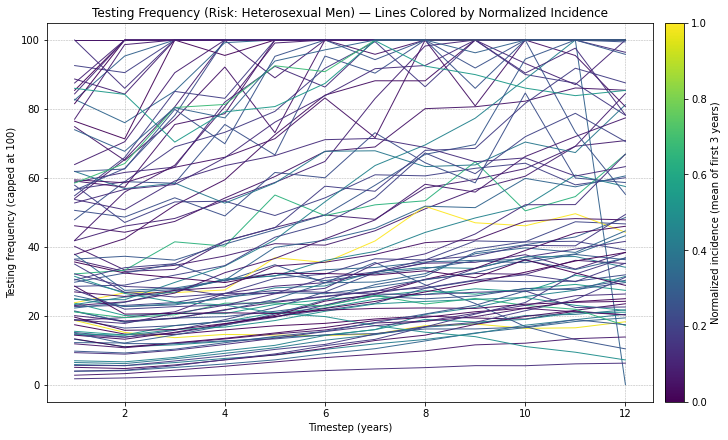

In [20]:
plot_overlay_by_incidence(inf_list, diag_list, risk_index=0, incidence_years=3)

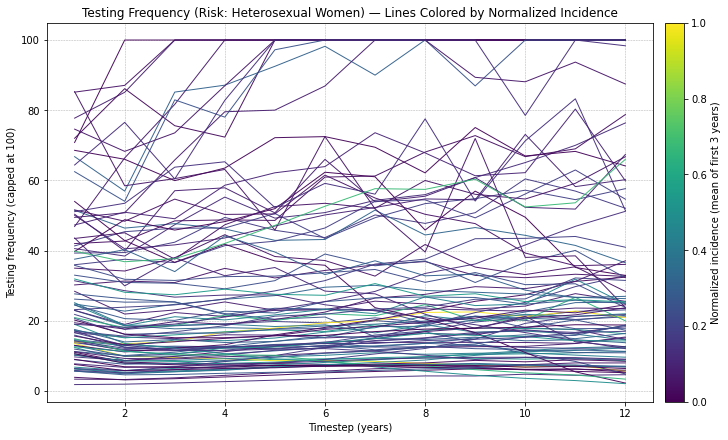

In [22]:
plot_overlay_by_incidence(inf_list, diag_list, risk_index=1, incidence_years=3)

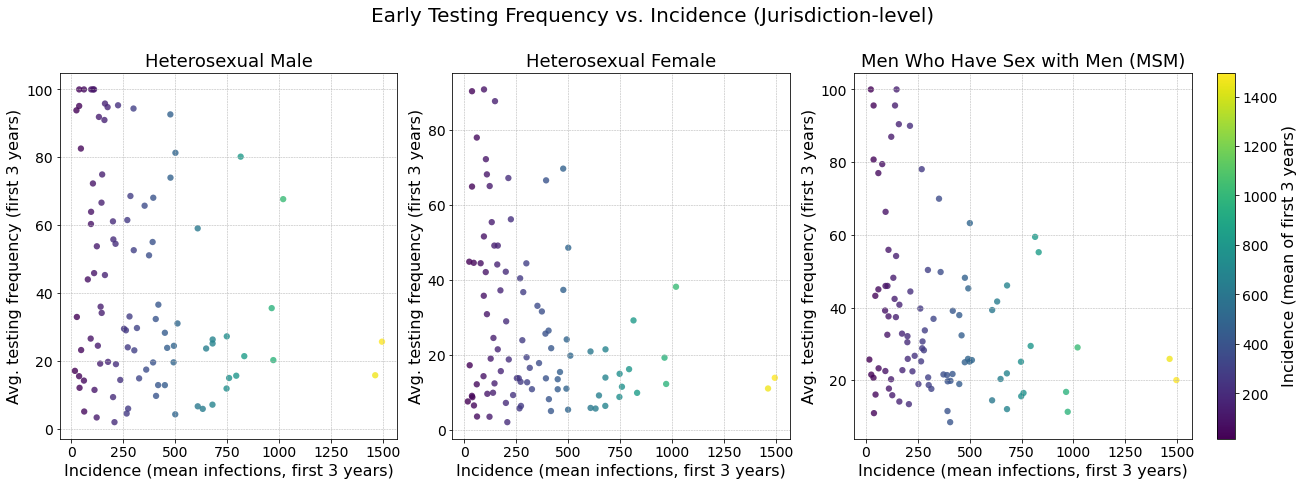

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ---- Prepare incidence data ----
# inf_list: length T=12, each element length J=95 (new infections per jurisdiction)
inf_mat = np.stack([np.asarray(step, dtype=float) for step in inf_list], axis=0)  # (12, J)
T, J = inf_mat.shape
# incidence metric = average infections in first 3 timesteps
incidence_j = inf_mat[:3, :].mean(axis=0)  # (J,)

# ---- Prepare testing frequency ----
# diag_list: length T=12, each element (J, 3) (diagnosis rates per risk group)
diag_arr = np.stack(diag_list, axis=0).astype(float)  # (12, J, 3)

with np.errstate(divide="ignore", invalid="ignore"):
    freq_arr = np.where(diag_arr > 0, 1.0 / diag_arr, 0.0)
freq_arr = np.clip(freq_arr, 0.0, 100.0)  # cap at 100

# average testing frequency in first 3 timesteps, per jurisdiction and risk group
avg3_freq = freq_arr[:3, :, :].mean(axis=0)  # shape (J, 3)

# ---- Plot scatter per risk group ----
risk_titles = ["Heterosexual Male", "Heterosexual Female", "Men Who Have Sex with Men (MSM)"]
colors = ["tab:blue", "tab:orange", "tab:green"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False, constrained_layout=True)

# Normalize incidence for coloring
norm = Normalize(vmin=incidence_j.min(), vmax=incidence_j.max())
cmap = plt.cm.viridis

for r, ax in enumerate(axes):
    sc = ax.scatter(incidence_j, avg3_freq[:, r],
                    c=incidence_j, cmap=cmap, norm=norm,
                    s=40, edgecolors="none", alpha=0.8)
    ax.set_title(risk_titles[r], fontsize=18)
    ax.set_xlabel("Incidence (mean infections, first 3 years)", fontsize=16)
    ax.set_ylabel("Avg. testing frequency (first 3 years)", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, linestyle="--", linewidth=0.5)

# Shared colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.025, pad=0.02)
cbar.set_label("Incidence (mean of first 3 years)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

fig.suptitle("Early Testing Frequency vs. Incidence (Jurisdiction-level)", fontsize=20, y=1.1)
plt.savefig("./test_results/testing_scatter_3years.pdf", format='pdf')
plt.show()

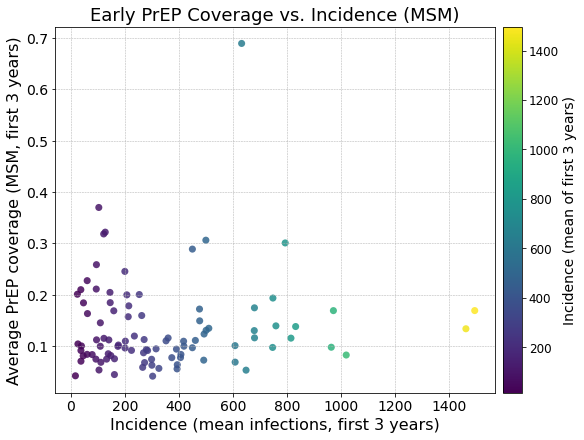

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ---- Prepare incidence data (same as before) ----
inf_mat = np.stack([np.asarray(step, dtype=float) for step in inf_list], axis=0)  # (12, J)
T, J = inf_mat.shape
incidence_j = inf_mat[:3, :].mean(axis=0)  # mean infections first 3 years

# ---- Prepare PrEP coverage ----
prep_arr = np.stack(prep_list, axis=0).astype(float)  # (12, J, 3)
prep_msm = prep_arr[:, :, 2]                         # (T, J) MSM only

avg3_prep = prep_msm[:3, :].mean(axis=0)             # (J,) mean coverage first 3 years

# ---- Plot scatter ----
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

norm = Normalize(vmin=incidence_j.min(), vmax=incidence_j.max())
cmap = plt.cm.viridis

sc = ax.scatter(incidence_j, avg3_prep,
                c=incidence_j, cmap=cmap, norm=norm,
                s=50, edgecolors="none", alpha=0.85)

ax.set_xlabel("Incidence (mean infections, first 3 years)", fontsize=16)
ax.set_ylabel("Average PrEP coverage (MSM, first 3 years)", fontsize=16)
ax.set_title("Early PrEP Coverage vs. Incidence (MSM)", fontsize=18)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.045, pad=0.02)
cbar.set_label("Incidence (mean of first 3 years)", fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.savefig("./test_results/prep_scatter_3years.pdf", format='pdf')
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def _mean_over_years(arr, years, axis=0, weights=None):
    """
    Compute mean (or weighted mean) over selected years from an array with time as first axis.
    
    arr: ndarray with time as first axis (T, ...)
    years: either a tuple (start, end) meaning slice start..end-1, 
           or a list/array of indices.
    weights: optional weights for weighted mean across selected years.
    """
    T = arr.shape[0]
    if isinstance(years, tuple):
        start, end = years
        start = max(0, start); end = min(T, end)
        idx = np.arange(start, end)
    else:
        idx = np.array(years, dtype=int)
        idx = idx[(idx >= 0) & (idx < T)]
    sel = arr.take(idx, axis=axis)   # <-- fixed here
    if weights is not None:
        w = np.asarray(weights, dtype=float)
        if w.shape[0] != sel.shape[0]:
            raise ValueError("weights length must match number of selected years")
        w = w / w.sum()
        sel_w = np.tensordot(w, sel, axes=(0,0))  # weighted mean
        return sel_w
    else:
        return sel.mean(axis=axis)

def scatter_prep_vs_incidence(
    inf_list, prep_list,
    years_inc=(0,3),      # incidence window: years 0..2
    years_prep=(0,3),     # PrEP window: years 0..2
    msm_col=2,
    cmap=plt.cm.viridis
):
    # inf_list -> (T, J)
    inf_mat = np.stack([np.asarray(step, dtype=float) for step in inf_list], axis=0)

    # prep_list -> (T, J, 3), MSM column -> (T, J)
    prep_arr = np.stack(prep_list, axis=0).astype(float)
    prep_msm = prep_arr[..., msm_col]

    # means over chosen years
    incidence_j = _mean_over_years(inf_mat, years_inc)      # (J,)
    avg_prep_j  = _mean_over_years(prep_msm, years_prep)    # (J,)

    # plot
    fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
    norm = Normalize(vmin=incidence_j.min(), vmax=incidence_j.max())
    sc = ax.scatter(incidence_j, avg_prep_j, 
                    c=incidence_j, cmap=cmap, norm=norm,
                    s=50, edgecolors="none", alpha=0.85)

    ax.set_xlabel(f"Incidence (mean over years {years_inc})", fontsize=16)
    ax.set_ylabel(f"PrEP coverage (MSM, mean over years {years_prep})", fontsize=16)
    ax.set_title("PrEP vs. Incidence (by jurisdiction)", fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, linestyle="--", linewidth=0.5)

    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.045, pad=0.02)
    cbar.set_label("Incidence (color scale)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    plt.show()

# Example calls:
# scatter_prep_vs_incidence(inf_list, prep_list, years_inc=(0,3), years_prep=(0,3))
# scatter_prep_vs_incidence(inf_list, prep_list, years_inc=(0,1), years_prep=(3,6))
# scatter_prep_vs_incidence(inf_list, prep_list, years_inc=[0,2,5], years_prep=[1,4,7])

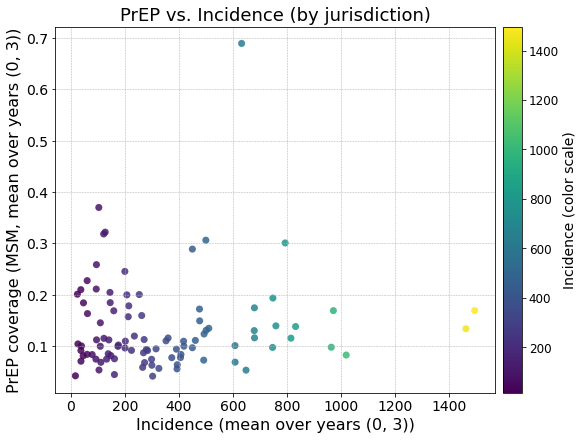

In [29]:
scatter_prep_vs_incidence(inf_list, prep_list, years_inc=(0,3), years_prep=(0,3))

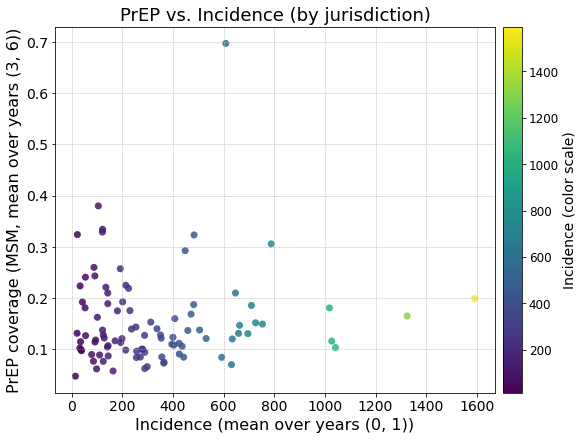

In [30]:
scatter_prep_vs_incidence(inf_list, prep_list, years_inc=(0,1), years_prep=(3,6))

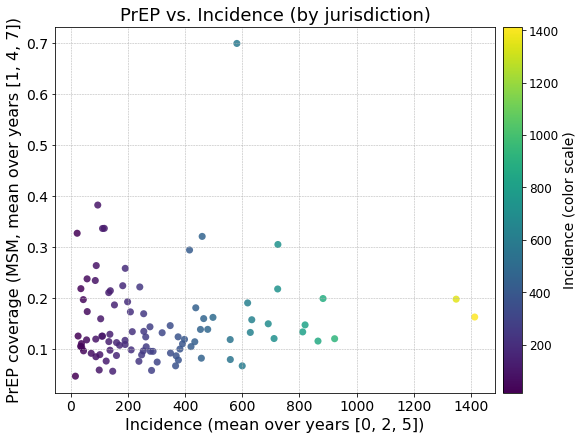

In [31]:
scatter_prep_vs_incidence(inf_list, prep_list, years_inc=[0,2,5], years_prep=[1,4,7])

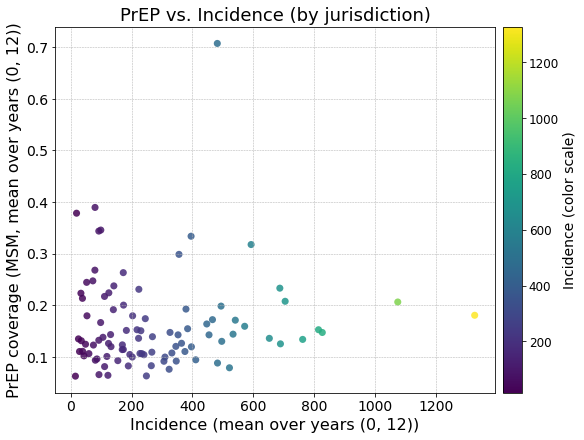

In [32]:
scatter_prep_vs_incidence(inf_list, prep_list, years_inc=(0,12), years_prep=(0,12))

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def _mean_over_years(arr, years, axis=0, weights=None):
    """
    Mean (or weighted mean) over selected years from an array whose time is on `axis` (default 0).
    years: (start, end) slice meaning start..end-1, or a list/array of indices.
    """
    T = arr.shape[axis]
    if isinstance(years, tuple):
        start, end = years
        start = max(0, start); end = min(T, end)
        idx = np.arange(start, end)
    else:
        idx = np.array(years, dtype=int)
        idx = idx[(idx >= 0) & (idx < T)]
    sel = np.take(arr, idx, axis=axis)
    if weights is not None:
        w = np.asarray(weights, dtype=float)
        if w.shape[0] != sel.shape[0]:
            raise ValueError("weights length must match number of selected years")
        w = w / w.sum()
        return np.tensordot(w, sel, axes=(0,0))  # weighted mean removes time axis
    else:
        return sel.mean(axis=axis)

def scatter_retention_vs_incidence(
    inf_list, drop_list,
    years_inc=(0,3),     # use years 0..2 for incidence
    years_ret=(0,3),     # use years 0..2 for retention
    cmap=plt.cm.viridis
):
    """
    Makes a 1x3 scatter: average retention (per risk group) vs incidence, one dot per jurisdiction.
    - inf_list: length T; each elem length J (new infections per jurisdiction)
    - drop_list: length T; each elem array (J, 3) dropout rates by risk group
    """
    # (T, J) infections
    inf_mat = np.stack([np.asarray(step, dtype=float) for step in inf_list], axis=0)

    # (T, J, 3) dropout -> retention
    drop_arr = np.stack(drop_list, axis=0).astype(float)
    ret_arr  = np.clip(1.0 - drop_arr, 0.0, 1.0)  # keep in [0,1]

    # averages over chosen windows
    incidence_j = _mean_over_years(inf_mat, years_inc, axis=0)   # (J,)
    avg_ret_JR  = _mean_over_years(ret_arr, years_ret, axis=0)   # (J, 3)

    # plotting
    risk_titles = ["Heterosexual Men", "Heterosexual Women", "Men Who Have Sex with Men (MSM)"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharey=False)

    norm = Normalize(vmin=incidence_j.min(), vmax=incidence_j.max())
    for r, ax in enumerate(axes):
        sc = ax.scatter(
            incidence_j,
            avg_ret_JR[:, r],
            c=incidence_j, cmap=cmap, norm=norm,
            s=50, edgecolors="none", alpha=0.85
        )
        ax.set_title(risk_titles[r], fontsize=18)
        ax.set_xlabel(f"Incidence (mean over years {years_inc})", fontsize=16)
        ax.set_ylabel(f"Average retention (years {years_ret})", fontsize=16)
        ax.tick_params(axis='both', labelsize=14)
        ax.grid(True, linestyle="--", linewidth=0.5)

    # shared colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.025, pad=0.02)
    cbar.set_label("Incidence (color scale)", fontsize=16)
    cbar.ax.tick_params(labelsize=14)

    fig.suptitle("Average Retention vs. Incidence (by jurisdiction)", fontsize=20, y=1.1)
    plt.savefig("./test_results/retention_scatter_3years.pdf", format='pdf')
    plt.show()

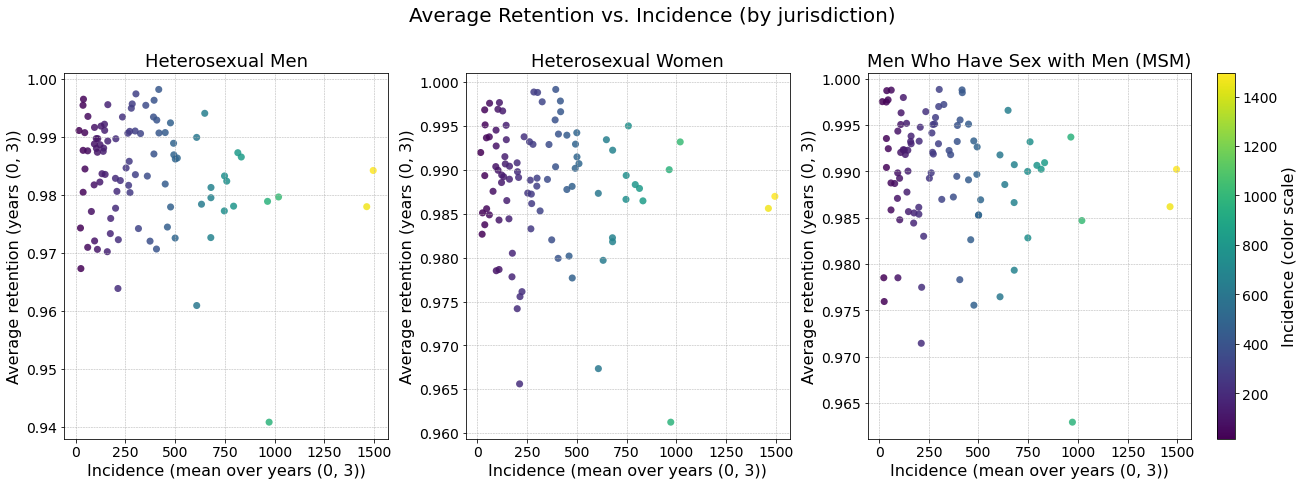

In [58]:
scatter_retention_vs_incidence(inf_list, drop_list, years_inc=(0,3), years_ret=(0,3))

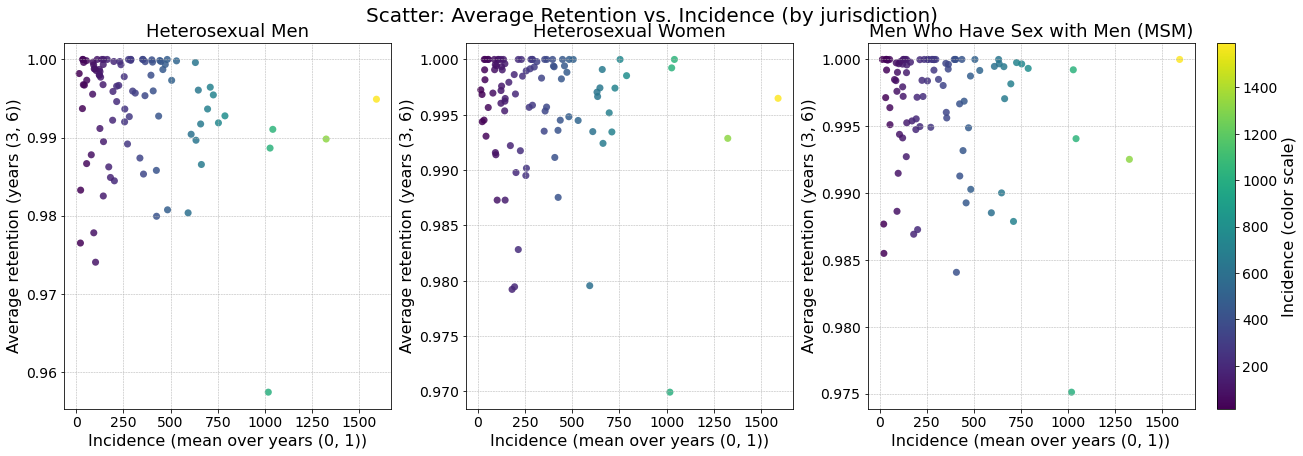

In [38]:
scatter_retention_vs_incidence(inf_list, drop_list, years_inc=(0,1), years_ret=(3,6))

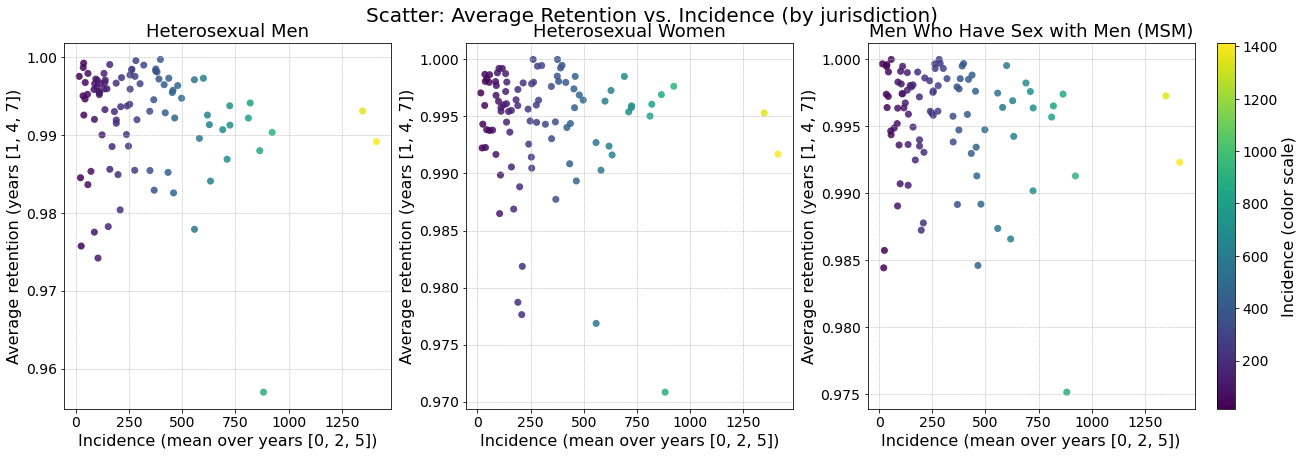

In [39]:
scatter_retention_vs_incidence(inf_list, drop_list, years_inc=[0,2,5], years_ret=[1,4,7])

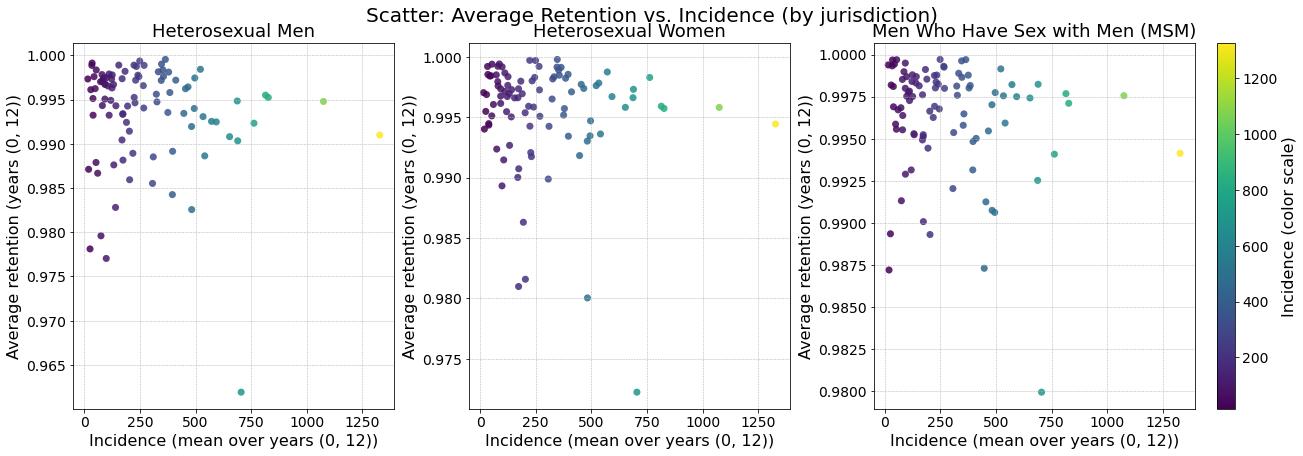

In [40]:
scatter_retention_vs_incidence(inf_list, drop_list, years_inc=(0,12), years_ret=(0,12))